### Hypothesis 1

Ok, so we can see that:
    - conv-deconv autoencoders don't capture harmonic frequency really well - dense are better for this
    - separate channels (t,f) for convolution are better
    - conv-deconv autoencoders provide slightly better results in terms of quality (PESQ and MSE)
    - my layer provides significantly worse results than plain convolutions...
    - with increase of denses in the convolutional model, the quality of speech improves
    
More hidden dense: better PESQ, more convos: better MSE. 

All results are very close to each other - the preference may be mixed. It would be beneficial to design an architecture that would reconstruct the convolutional structure - maybe summation would be good?

Nevertheless, in this experiment I compare three models in the noised source:
- separate axes Dense
- large inputs
- large convos
- summation model (own concept close to large inputs-convos but with Dense to predict fine structure at the end)

Keras optimizers for 0.001, 0.0001, 0.00001
9000 recordings
prepare the gsm.wavs
mean not removed, divided by STD, range from 0 to one digit number
if in 4 epochs the model doesnt improve == it has converged in that stage

##### Imports and initialization

In [1]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"


sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Switching to CPU only as GPU is busy or unavailable


##### Model definition

In [20]:
model_callbacks = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 129, 16 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, 129, 16 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

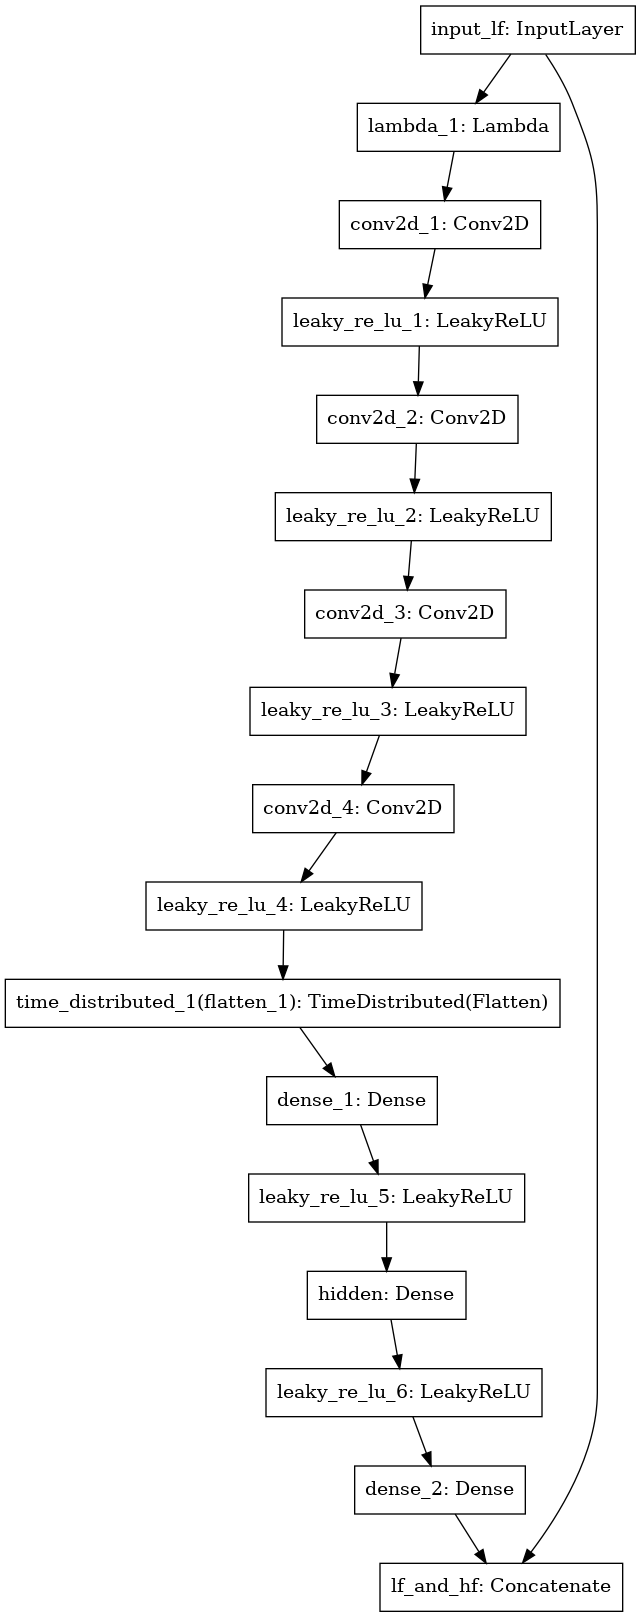

In [4]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512, name='hidden')(layer))
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, 129, 16 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, None, 129, 16 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (

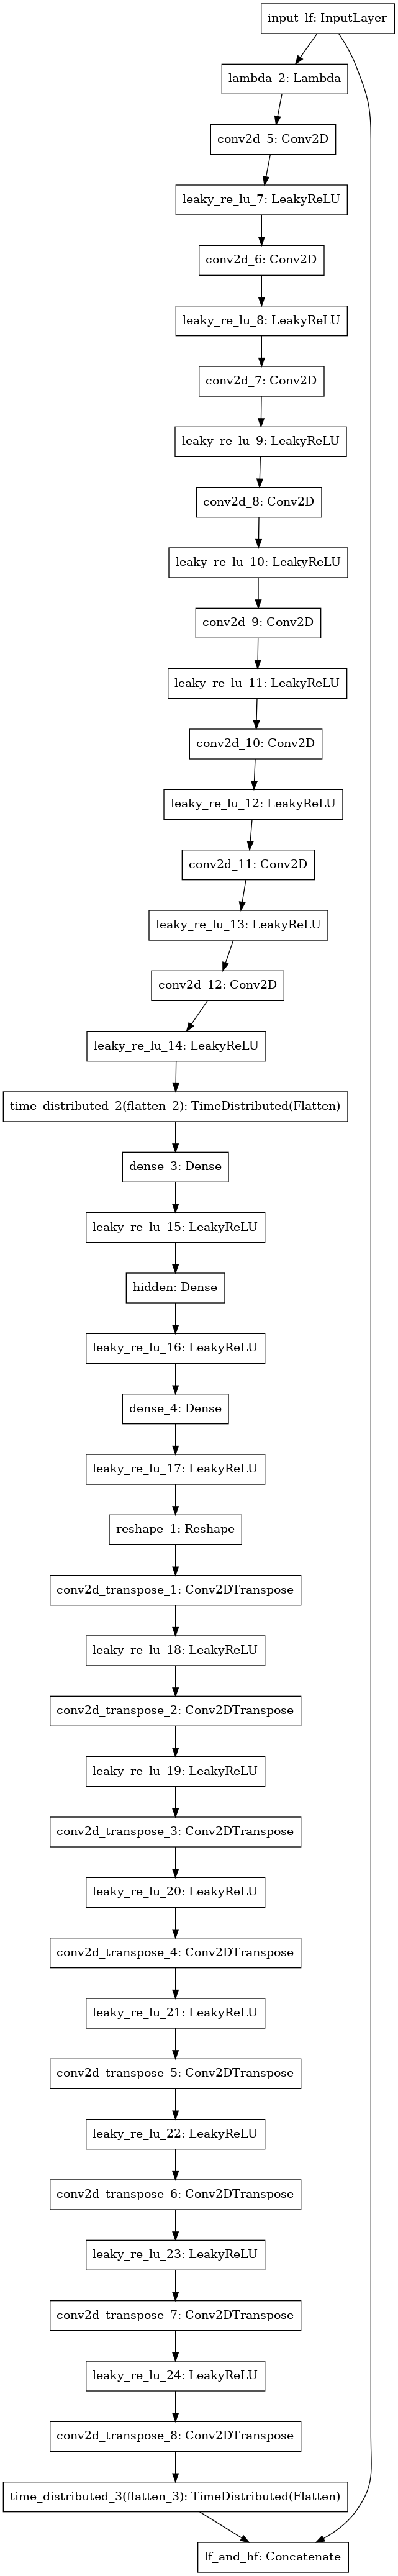

In [5]:
# baseline autoencoder - 4 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(40, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(40, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, None, 129, 16 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_25 (LeakyReLU)      (None, None, 129, 16 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

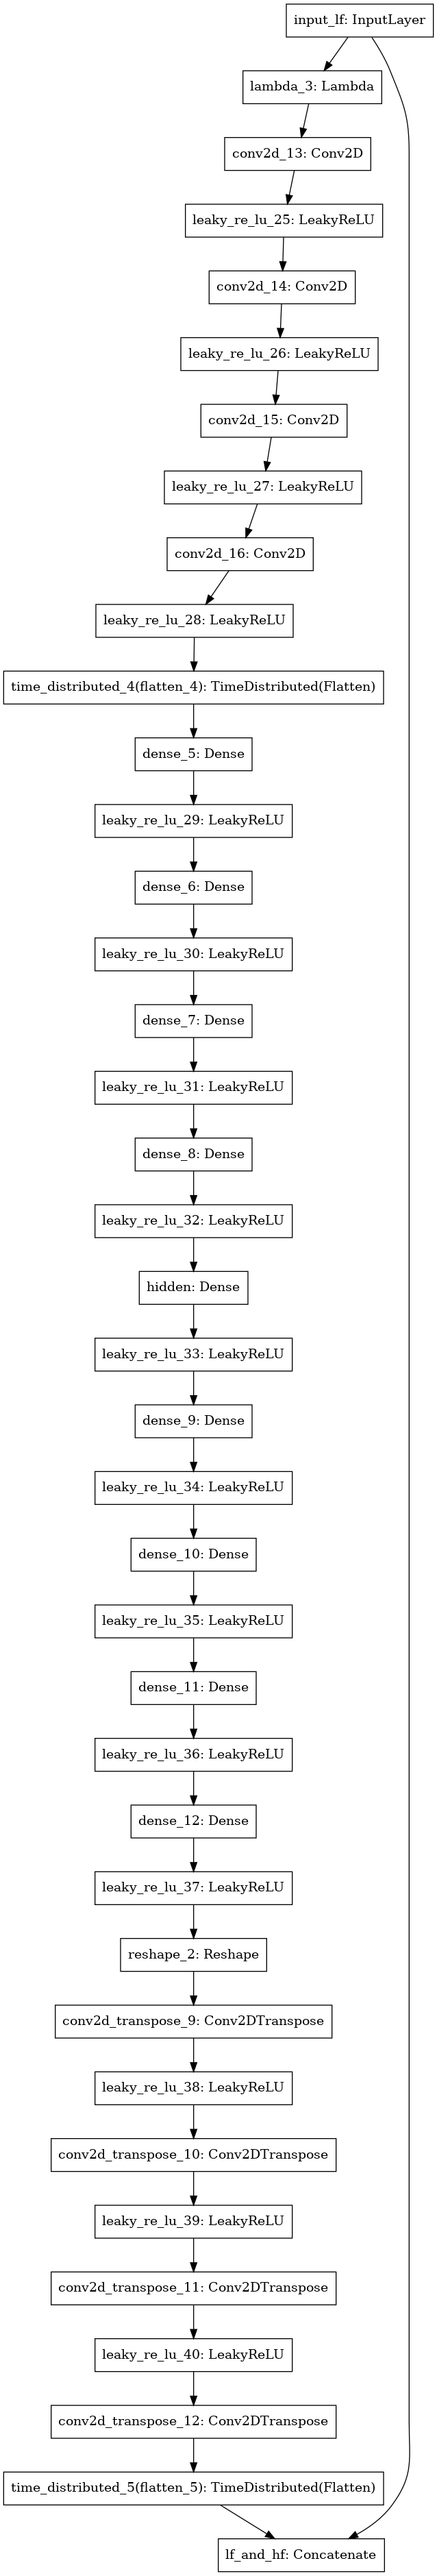

In [6]:
# baseline autoencoder - deeped mid representation - 4 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(192)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(192)(layer))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, 129, 16 160         lambda_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, None, 129, 16 0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 

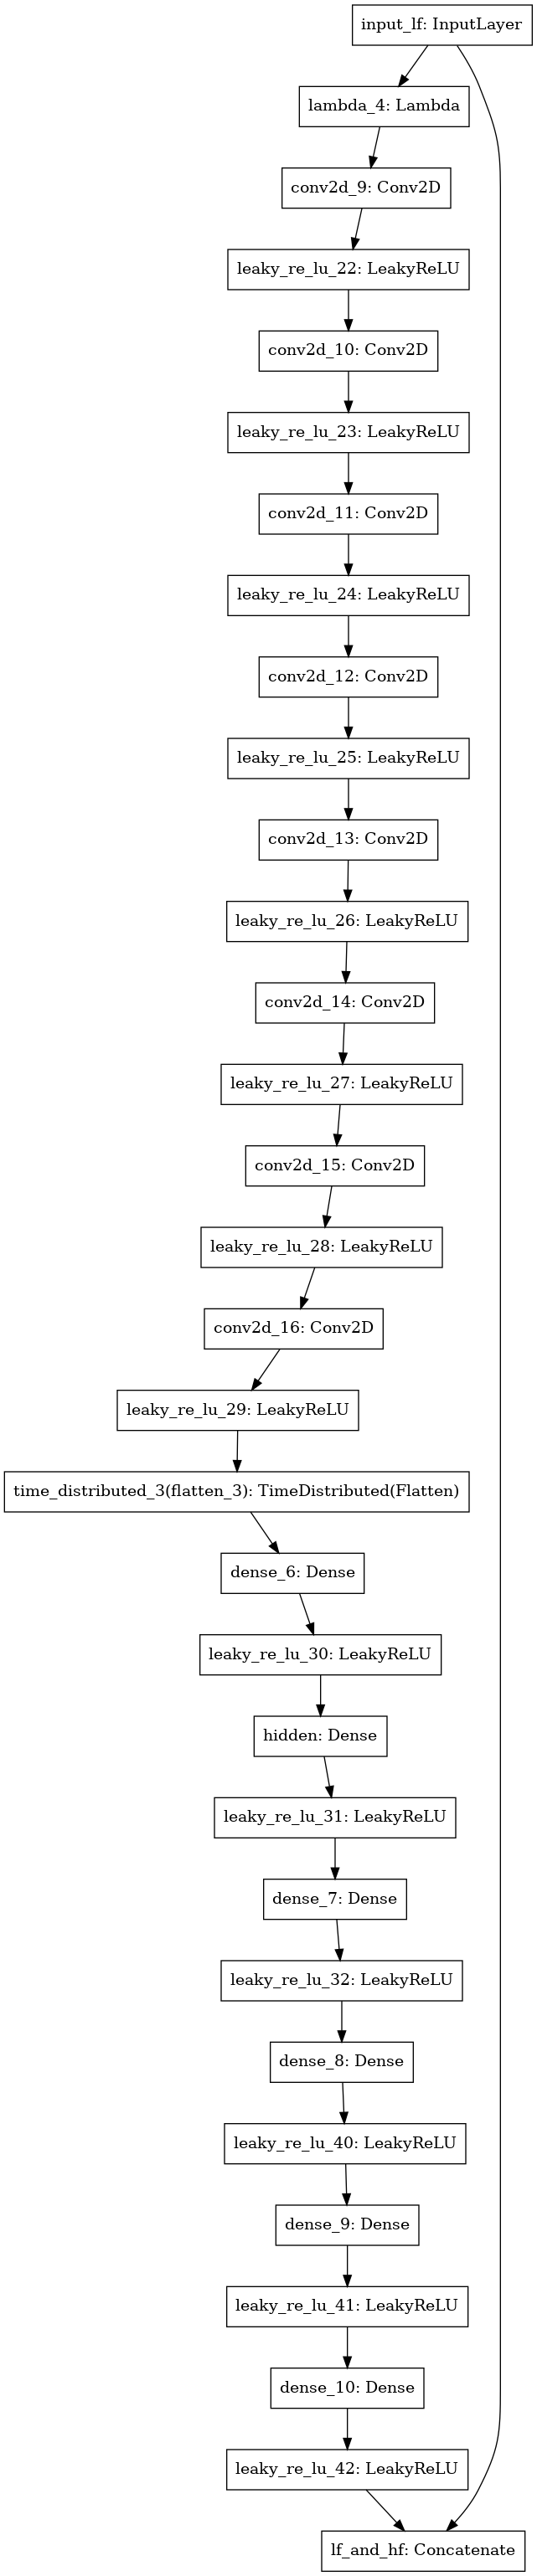

In [21]:
# own model

"""
Since most methods consist of estimation of the envelope and excitation signal (harmonics) and convolutionals are
really good in predicting the power envelope and Dense is good at detecting harmonics - we may use it combined.

We need to constrain the dense to be positive - maybe normalization to one mean?
"""

# baseline autoencoder - 4 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(40, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    common = layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(40, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))    
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    envelope = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(512)(common))
    layer = LeakyReLU(0.05)(Dense(256)(layer))
    layer = LeakyReLU(0.05)(Dense(128)(layer))
    excitation = Lambda(lambda x: x + (1 - K.mean(x, axis=-1)))(layer)
    final = Lambda(lambda x: x[0] * x[1])([excitation, envelope])
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)


##### Data loading

In [22]:
TRAIN = 9000
VALID = 80
TEST = 80

import numpy as np
import scipy.io.wavfile as sio
import gc

import tempfile
import subprocess

tempnam = tempfile.mktemp

log_fft_source = log_fft_target = phase = train = test = valid = experiment = None
gc.collect()

dataset = Dataset.from_folder("DAE-libri",
                              verbose = False,
                              dataset_pad = 8,
                              trim_lengths = 160000,
                              cache = "cache",
                              ram_cache_size = None,
                              filter=lambda x:x.endswith(".wav") and not x.endswith(".gsm.wav"))

import random
noises = [os.path.join("./NoiseCut", x) for x in os.listdir("./NoiseCut")]

log_fft_source = np.zeros([TRAIN + VALID + TEST, 1248, 129], np.float32)
log_fft_target = np.zeros([TRAIN + VALID + TEST, 1248, 257], np.float32)
phase = np.zeros([TEST, 1248, 129], np.float32)

SNR = 0 # dB
SNR /= 10. # B
SNR = np.log(10) * SNR

for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    noise = sio.read(random.choice(noises))[1]
    data = sio.read(dataset.root + "/" + file)[1] # .astype(np.float32) to generate noise in the experiment...
    data = data[:176000]
    noise = noise[:len(data)]
    if len(noise) < len(data):
        print("NOISE TOO SHORT:", len(noise))
        noise = np.pad(noise, ((0, len(data) - len(noise)),),'constant')
    log_power_of_signal = np.log((data ** 2).mean())
    log_power_of_noise = np.log((noise ** 2).mean())
    gain_of_noise = np.exp(log_power_of_signal - SNR - log_power_of_noise)   # SNR was miscalculated...
    print("Noise difference - logpower:", log_power_of_signal - log_power_of_noise)
    print("Noise gain - multiplicatively:", gain_of_noise)
    if np.isnan(gain_of_noise):
        print("NAN gain - generating some random white noise")
        noise = np.random.normal(0, 1500, size=data.shape)
    else:
        noise = noise * gain_of_noise
    noised = data + noise
    if np.abs(noised).max() >= 2**15 - 1:
        noised = noised / (np.abs(noised).max() / (2 ** 15 - 1))
    noised = noised.astype(np.int16)
    print("Amplitude of clean recording: ", np.abs(data).max())
    print("Amplitude of noised recording: ", np.abs(noised).max())
    oldname = tempnam() + '.oldwav'
    sio.write(oldname, 16000, noised)
    tmpname = tempnam() + '.gsm'
    newname = dataset.root + "/" + file + ".gsm.wav"
    subprocess.Popen(['sox', oldname, '-r', '8000', tmpname]).communicate()
    subprocess.Popen(['sox', tmpname, '-r', '16000', "-e", "signed", '-b', '16',  newname]).communicate()
    list(map(os.remove, [oldname, tmpname]))


window = np.hamming(512)
for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    r = sio.read(dataset.root + "/" + file)[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_target[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)
    r = sio.read(dataset.root + "/" + file + ".gsm.wav")[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_source[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)[:129]
        if ix >= TRAIN+VALID:
            phase[ix - TRAIN - VALID, time, :] = np.angle(fft)[:129]


0
Noise difference - logpower: -1.228914011185088
Noise gain - multiplicatively: 0.29261017657411154
Amplitude of clean recording:  18153
Amplitude of noised recording:  18233
1
Noise difference - logpower: -1.7415388187278467
Noise gain - multiplicatively: 0.17525051424376778
Amplitude of clean recording:  16891
Amplitude of noised recording:  16893
2
Noise difference - logpower: -1.0845202910954992
Noise gain - multiplicatively: 0.3380639192755575
Amplitude of clean recording:  17380
Amplitude of noised recording:  17234
3
Noise difference - logpower: 1.1251571601329928
Noise gain - multiplicatively: 3.0807009742492584
Amplitude of clean recording:  14036
Amplitude of noised recording:  26332
4
Noise difference - logpower: 0.7141826961709974
Noise gain - multiplicatively: 2.0425166432135673
Amplitude of clean recording:  8834
Amplitude of noised recording:  12411
5
Noise difference - logpower: 0.5402341459154858
Noise gain - multiplicatively: 1.716408705225702
Amplitude of clean reco

48
Noise difference - logpower: -0.8060782759226681
Noise gain - multiplicatively: 0.4466061022293028
Amplitude of clean recording:  10980
Amplitude of noised recording:  12818
49
Noise difference - logpower: 0.23115904950816013
Noise gain - multiplicatively: 1.2600596353776312
Amplitude of clean recording:  20444
Amplitude of noised recording:  21753
50
Noise difference - logpower: -0.27454269881123583
Noise gain - multiplicatively: 0.7599195558945031
Amplitude of clean recording:  13439
Amplitude of noised recording:  14479
51
Noise difference - logpower: 0.7037056741290062
Noise gain - multiplicatively: 2.0212288623223515
Amplitude of clean recording:  13567
Amplitude of noised recording:  25332
52
Noise difference - logpower: -0.34016958640832584
Noise gain - multiplicatively: 0.711649626424538
Amplitude of clean recording:  18429
Amplitude of noised recording:  19055
53
Noise difference - logpower: -1.4844779920446607
Noise gain - multiplicatively: 0.2266206075656478
Amplitude of 

96
Noise difference - logpower: -0.3819876060459846
Noise gain - multiplicatively: 0.6825035120701145
Amplitude of clean recording:  15933
Amplitude of noised recording:  15990
97
Noise difference - logpower: -0.04625926818799275
Noise gain - multiplicatively: 0.9547943822879037
Amplitude of clean recording:  26745
Amplitude of noised recording:  26759
98
Noise difference - logpower: -0.35935847420909806
Noise gain - multiplicatively: 0.6981240470248217
Amplitude of clean recording:  29771
Amplitude of noised recording:  29827
99
Noise difference - logpower: -0.3879624730848512
Noise gain - multiplicatively: 0.6784378024642452
Amplitude of clean recording:  32074
Amplitude of noised recording:  32110
100
Noise difference - logpower: -0.0321972854924466
Noise gain - multiplicatively: 0.9683155286278711
Amplitude of clean recording:  21472
Amplitude of noised recording:  22125
101
Noise difference - logpower: -0.8899121893661288
Noise gain - multiplicatively: 0.41069181427756707
Amplitud

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


131
Noise difference - logpower: 1.7861141995654917
Noise gain - multiplicatively: 5.966223809577441
Amplitude of clean recording:  17160
Amplitude of noised recording:  32767
132
Noise difference - logpower: 1.1754284571593692
Noise gain - multiplicatively: 3.239530646629678
Amplitude of clean recording:  15101
Amplitude of noised recording:  32767
133
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.2912089836300593
Noise gain - multiplicatively: 0.7473594758005943
Amplitude of clean recording:  23362
Amplitude of noised recording:  23336
134
Noise difference - logpower: 1.8911898921324592
Noise gain - multiplicatively: 6.627249703612015
Amplitude of clean recording:  18871
Amplitude of noised recording:  32767
135
Noise difference - logpower: 0.829360701731523
Noise gain - multiplicatively: 2.291853094106909
Amplitude of clean recording:  18648
Amplitude of noised recording:  20144
136
Noise difference - logpower: -0.48840022983743214
Noise gain - multiplicatively: 0.61360723

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


164
Noise difference - logpower: -0.8001877830309949
Noise gain - multiplicatively: 0.4492445956841538
Amplitude of clean recording:  30722
Amplitude of noised recording:  30869
165
Noise difference - logpower: 1.2362311676622566
Noise gain - multiplicatively: 3.4426143481222375
Amplitude of clean recording:  16607
Amplitude of noised recording:  32767
166
Noise difference - logpower: 0.18952116576549827
Noise gain - multiplicatively: 1.2086707061594302
Amplitude of clean recording:  24500
Amplitude of noised recording:  26447
167
Noise difference - logpower: -0.9214088861843415
Noise gain - multiplicatively: 0.3979579684498838
Amplitude of clean recording:  21545
Amplitude of noised recording:  21522
168
Noise difference - logpower: -0.6303799345869399
Noise gain - multiplicatively: 0.5323894893959968
Amplitude of clean recording:  19092
Amplitude of noised recording:  19078
169
Noise difference - logpower: 1.3502262714071183
Noise gain - multiplicatively: 3.8582984545547894
Amplitude

212
Noise difference - logpower: -0.2558989385023489
Noise gain - multiplicatively: 0.7742202086924632
Amplitude of clean recording:  17645
Amplitude of noised recording:  28470
213
Noise difference - logpower: -0.48432036346711627
Noise gain - multiplicatively: 0.6161157893016781
Amplitude of clean recording:  12917
Amplitude of noised recording:  12862
214
Noise difference - logpower: 0.9993523983498553
Noise gain - multiplicatively: 2.716522034545601
Amplitude of clean recording:  16598
Amplitude of noised recording:  32767
215
Noise difference - logpower: -0.02197656088934874
Noise gain - multiplicatively: 0.9782631644010437
Amplitude of clean recording:  21185
Amplitude of noised recording:  20622
216
Noise difference - logpower: -0.8663791357209982
Noise gain - multiplicatively: 0.4204712656299505
Amplitude of clean recording:  15344
Amplitude of noised recording:  15586
217
Noise difference - logpower: -0.5850308293382556
Noise gain - multiplicatively: 0.5570886868718633
Amplitu

259
Noise difference - logpower: -0.8506954016480899
Noise gain - multiplicatively: 0.4271178102220741
Amplitude of clean recording:  16704
Amplitude of noised recording:  16811
260
Noise difference - logpower: -0.8622298377047022
Noise gain - multiplicatively: 0.4222195507881038
Amplitude of clean recording:  17816
Amplitude of noised recording:  17699
261
Noise difference - logpower: -0.8975287632199418
Noise gain - multiplicatively: 0.4075756321234249
Amplitude of clean recording:  17671
Amplitude of noised recording:  17691
262
Noise difference - logpower: -0.4027568771627479
Noise gain - multiplicatively: 0.668474601010453
Amplitude of clean recording:  18242
Amplitude of noised recording:  18427
263
Noise difference - logpower: 1.0601405856957218
Noise gain - multiplicatively: 2.886776800266538
Amplitude of clean recording:  23700
Amplitude of noised recording:  32767
264
Noise difference - logpower: -0.6502287711266606
Noise gain - multiplicatively: 0.5219263614204098
Amplitude 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


273
Noise difference - logpower: -1.2874609610737808
Noise gain - multiplicatively: 0.2759705943713534
Amplitude of clean recording:  18279
Amplitude of noised recording:  18304
274
Noise difference - logpower: -0.45072803121378335
Noise gain - multiplicatively: 0.6371641073644541
Amplitude of clean recording:  21382
Amplitude of noised recording:  21547
275
Noise difference - logpower: 0.45296611821078336
Noise gain - multiplicatively: 1.5729708905431414
Amplitude of clean recording:  17774
Amplitude of noised recording:  19969
276
Noise difference - logpower: 2.165168161253315
Noise gain - multiplicatively: 8.716067498455287
Amplitude of clean recording:  14589
Amplitude of noised recording:  32767
277
Noise difference - logpower: 1.9565847329021837
Noise gain - multiplicatively: 7.075122323370587
Amplitude of clean recording:  19507
Amplitude of noised recording:  32767
278
Noise difference - logpower: -0.7144038014264913
Noise gain - multiplicatively: 0.4894838543951751
Amplitude o

321
Noise difference - logpower: -0.9768091200570055
Noise gain - multiplicatively: 0.3765105841982406
Amplitude of clean recording:  21668
Amplitude of noised recording:  24064
322
Noise difference - logpower: -1.6863363209697093
Noise gain - multiplicatively: 0.18519678417814475
Amplitude of clean recording:  17611
Amplitude of noised recording:  17611
323
Noise difference - logpower: -0.2683722736010372
Noise gain - multiplicatively: 0.7646230791255346
Amplitude of clean recording:  11371
Amplitude of noised recording:  29310
324
Noise difference - logpower: -0.22408398724994694
Noise gain - multiplicatively: 0.7992480049084373
Amplitude of clean recording:  9936
Amplitude of noised recording:  23597
325
Noise difference - logpower: 2.6791591905029026
Noise gain - multiplicatively: 14.572835165020152
Amplitude of clean recording:  18181
Amplitude of noised recording:  32767
326
Noise difference - logpower: -0.023322680622925418
Noise gain - multiplicatively: 0.976947190978425
Amplit

367
Noise difference - logpower: -0.7641167821962611
Noise gain - multiplicatively: 0.46574510373765743
Amplitude of clean recording:  12888
Amplitude of noised recording:  12893
368
Noise difference - logpower: -0.30568422372324555
Noise gain - multiplicatively: 0.7366191895991782
Amplitude of clean recording:  19642
Amplitude of noised recording:  24540
369
Noise difference - logpower: 0.5442639367491067
Noise gain - multiplicatively: 1.7233394285963999
Amplitude of clean recording:  7625
Amplitude of noised recording:  14601
370
Noise difference - logpower: -0.08877818283295014
Noise gain - multiplicatively: 0.9150485245360419
Amplitude of clean recording:  31222
Amplitude of noised recording:  31242
371
Noise difference - logpower: 0.665656574027107
Noise gain - multiplicatively: 1.945767642525518
Amplitude of clean recording:  11528
Amplitude of noised recording:  32767
372
Noise difference - logpower: 1.9173038140362717
Noise gain - multiplicatively: 6.802592666741921
Amplitude o

415
Noise difference - logpower: 0.3111059070159383
Noise gain - multiplicatively: 1.3649337695941721
Amplitude of clean recording:  20787
Amplitude of noised recording:  21532
416
Noise difference - logpower: -1.1397975342098317
Noise gain - multiplicatively: 0.31988378078278323
Amplitude of clean recording:  15271
Amplitude of noised recording:  15303
417
Noise difference - logpower: -1.1434539144512046
Noise gain - multiplicatively: 0.31871629972521115
Amplitude of clean recording:  11746
Amplitude of noised recording:  11673
418
Noise difference - logpower: 1.788664089409819
Noise gain - multiplicatively: 5.981456435584179
Amplitude of clean recording:  18171
Amplitude of noised recording:  32766
419
Noise difference - logpower: -0.23380364883950033
Noise gain - multiplicatively: 0.7915172159625026
Amplitude of clean recording:  17570
Amplitude of noised recording:  17564
420
Noise difference - logpower: 2.005841084265267
Noise gain - multiplicatively: 7.432342494917212
Amplitude o

463
Noise difference - logpower: 0.24232580213362365
Noise gain - multiplicatively: 1.2742092652940897
Amplitude of clean recording:  11586
Amplitude of noised recording:  12934
464
Noise difference - logpower: 0.15487777532207847
Noise gain - multiplicatively: 1.1675152532082975
Amplitude of clean recording:  12180
Amplitude of noised recording:  30509
465
Noise difference - logpower: 0.22317171480929332
Noise gain - multiplicatively: 1.2500352048645982
Amplitude of clean recording:  20445
Amplitude of noised recording:  32767
466
Noise difference - logpower: -0.17443973504985344
Noise gain - multiplicatively: 0.8399274708911498
Amplitude of clean recording:  18578
Amplitude of noised recording:  18990
467
Noise difference - logpower: 0.24200074049862774
Noise gain - multiplicatively: 1.273795136059396
Amplitude of clean recording:  15599
Amplitude of noised recording:  16955
468
Noise difference - logpower: 0.23872337569352453
Noise gain - multiplicatively: 1.2696272782374534
Amplitu

511
Noise difference - logpower: 0.004813882980205797
Noise gain - multiplicatively: 1.0048254883296712
Amplitude of clean recording:  16360
Amplitude of noised recording:  18986
512
Noise difference - logpower: -0.3047377346675608
Noise gain - multiplicatively: 0.7373167216514946
Amplitude of clean recording:  21875
Amplitude of noised recording:  21622
513
Noise difference - logpower: -0.6218729968566867
Noise gain - multiplicatively: 0.536937812351226
Amplitude of clean recording:  19278
Amplitude of noised recording:  19393
514
Noise difference - logpower: -1.1970056039904362
Noise gain - multiplicatively: 0.3020974583222725
Amplitude of clean recording:  32140
Amplitude of noised recording:  32126
515
Noise difference - logpower: 0.5158690978567462
Noise gain - multiplicatively: 1.6750936896911537
Amplitude of clean recording:  11915
Amplitude of noised recording:  21002
516
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


517
Noise difference - logpower: -0.8103998947079045
Noise gain - multiplicatively: 0.44468020540166076
Amplitude of clean recording:  11336
Amplitude of noised recording:  11409
518
Noise difference - logpower: -0.49577242848855185
Noise gain - multiplicatively: 0.6091002391638601
Amplitude of clean recording:  13621
Amplitude of noised recording:  15050
519
Noise difference - logpower: 0.35003227833655703
Noise gain - multiplicatively: 1.4191133544724528
Amplitude of clean recording:  10129
Amplitude of noised recording:  13906
520
Noise difference - logpower: 2.2717344724311888
Noise gain - multiplicatively: 9.696204036085383
Amplitude of clean recording:  31045
Amplitude of noised recording:  32767
521
Noise difference - logpower: 0.16649976670271727
Noise gain - multiplicatively: 1.1811632603081625
Amplitude of clean recording:  22255
Amplitude of noised recording:  22677
522
Noise difference - logpower: -0.40356800152631234
Noise gain - multiplicatively: 0.6679326048180236
Amplit

563
Noise difference - logpower: -0.8552489489508606
Noise gain - multiplicatively: 0.42517733045552825
Amplitude of clean recording:  15355
Amplitude of noised recording:  19917
564
Noise difference - logpower: -1.5707587842256707
Noise gain - multiplicatively: 0.2078873808306469
Amplitude of clean recording:  18037
Amplitude of noised recording:  18045
565
Noise difference - logpower: -0.0781379166960754
Noise gain - multiplicatively: 0.9248368673023198
Amplitude of clean recording:  27498
Amplitude of noised recording:  27472
566
Noise difference - logpower: -0.6695314157481826
Noise gain - multiplicatively: 0.5119484125546224
Amplitude of clean recording:  8231
Amplitude of noised recording:  9446
567
Noise difference - logpower: -0.06906757919742201
Noise gain - multiplicatively: 0.9332636087414089
Amplitude of clean recording:  11831
Amplitude of noised recording:  17743
568
Noise difference - logpower: 0.056831381330436415
Noise gain - multiplicatively: 1.058477316310366
Amplitu

611
Noise difference - logpower: 0.774111552071167
Noise gain - multiplicatively: 2.1686645255173533
Amplitude of clean recording:  21507
Amplitude of noised recording:  30698
612
Noise difference - logpower: 1.5850966789377887
Noise gain - multiplicatively: 4.879763126024025
Amplitude of clean recording:  23609
Amplitude of noised recording:  32767
613
Noise difference - logpower: -1.1634874876637475
Noise gain - multiplicatively: 0.31239480587861357
Amplitude of clean recording:  14843
Amplitude of noised recording:  14868
614
Noise difference - logpower: 2.1009542380256265
Noise gain - multiplicatively: 8.173966101540355
Amplitude of clean recording:  25484
Amplitude of noised recording:  32767
615
Noise difference - logpower: -0.44401200186438405
Noise gain - multiplicatively: 0.6414577220925317
Amplitude of clean recording:  11975
Amplitude of noised recording:  16907
616
Noise difference - logpower: -0.09191051325007038
Noise gain - multiplicatively: 0.9121867745226397
Amplitude 

659
Noise difference - logpower: -0.5631203260813447
Noise gain - multiplicatively: 0.5694294831888579
Amplitude of clean recording:  14630
Amplitude of noised recording:  14605
660
Noise difference - logpower: -0.3349017191036463
Noise gain - multiplicatively: 0.7154083938757692
Amplitude of clean recording:  16751
Amplitude of noised recording:  24553
661
Noise difference - logpower: 0.7587078283838924
Noise gain - multiplicatively: 2.135514985036543
Amplitude of clean recording:  17246
Amplitude of noised recording:  23712
662
Noise difference - logpower: -1.571360465972866
Noise gain - multiplicatively: 0.20776233641037392
Amplitude of clean recording:  11537
Amplitude of noised recording:  11509
663
Noise difference - logpower: 0.3146952088633581
Noise gain - multiplicatively: 1.3698417317045761
Amplitude of clean recording:  8612
Amplitude of noised recording:  32766
664
Noise difference - logpower: -0.24213755151629446
Noise gain - multiplicatively: 0.7849481993106866
Amplitude 

707
Noise difference - logpower: -0.9705524279789293
Noise gain - multiplicatively: 0.37887367985981296
Amplitude of clean recording:  13051
Amplitude of noised recording:  13085
708
Noise difference - logpower: 2.2221729973579825
Noise gain - multiplicatively: 9.227360125410527
Amplitude of clean recording:  27491
Amplitude of noised recording:  32767
709
Noise difference - logpower: -0.5455062606740668
Noise gain - multiplicatively: 0.5795483065419096
Amplitude of clean recording:  16403
Amplitude of noised recording:  16429
710
Noise difference - logpower: 3.110395011682238
Noise gain - multiplicatively: 22.429902724668146
Amplitude of clean recording:  10870
Amplitude of noised recording:  32767
711
Noise difference - logpower: -0.8616334728991744
Noise gain - multiplicatively: 0.4224714227647259
Amplitude of clean recording:  19625
Amplitude of noised recording:  19633
712
Noise difference - logpower: -0.4181302578743358
Noise gain - multiplicatively: 0.6582764771454205
Amplitude 

754
Noise difference - logpower: -0.08466079867357479
Noise gain - multiplicatively: 0.9188238978335211
Amplitude of clean recording:  16700
Amplitude of noised recording:  17194
755
Noise difference - logpower: -0.16103649732694159
Noise gain - multiplicatively: 0.8512610017890861
Amplitude of clean recording:  7395
Amplitude of noised recording:  14587
756
Noise difference - logpower: 0.8100695512081639
Noise gain - multiplicatively: 2.248064336829894
Amplitude of clean recording:  20363
Amplitude of noised recording:  32767
757
Noise difference - logpower: 0.7526829584564796
Noise gain - multiplicatively: 2.122687465893037
Amplitude of clean recording:  13464
Amplitude of noised recording:  26692
758
Noise difference - logpower: 0.2805233049487432
Noise gain - multiplicatively: 1.3238223939159413
Amplitude of clean recording:  7732
Amplitude of noised recording:  15798
759
Noise difference - logpower: -0.7215022831977214
Noise gain - multiplicatively: 0.4860215652140271
Amplitude of

802
Noise difference - logpower: -0.6850344059809705
Noise gain - multiplicatively: 0.5040728861543398
Amplitude of clean recording:  13242
Amplitude of noised recording:  13279
803
Noise difference - logpower: -1.153606770456249
Noise gain - multiplicatively: 0.3154967902911546
Amplitude of clean recording:  14472
Amplitude of noised recording:  14443
804
Noise difference - logpower: 0.2533712149797642
Noise gain - multiplicatively: 1.2883614471456795
Amplitude of clean recording:  25449
Amplitude of noised recording:  32767
805
Noise difference - logpower: -0.12144636480879711
Noise gain - multiplicatively: 0.8856385534681689
Amplitude of clean recording:  32718
Amplitude of noised recording:  32767
806
Noise difference - logpower: 0.45963474118212844
Noise gain - multiplicatively: 1.5834954936592638
Amplitude of clean recording:  15203
Amplitude of noised recording:  16670
807
Noise difference - logpower: 0.3874879686748489
Noise gain - multiplicatively: 1.4732752280590788
Amplitude

850
Noise difference - logpower: 0.8953909992419327
Noise gain - multiplicatively: 2.4482928829999757
Amplitude of clean recording:  23413
Amplitude of noised recording:  32766
851
Noise difference - logpower: -1.3516564142616314
Noise gain - multiplicatively: 0.25881120682450287
Amplitude of clean recording:  13137
Amplitude of noised recording:  13487
852
Noise difference - logpower: -0.7769431076726967
Noise gain - multiplicatively: 0.459809453116342
Amplitude of clean recording:  19561
Amplitude of noised recording:  19675
853
Noise difference - logpower: 3.158106346932855
Noise gain - multiplicatively: 23.526003632287768
Amplitude of clean recording:  11426
Amplitude of noised recording:  32767
854
Noise difference - logpower: -0.5943948614099668
Noise gain - multiplicatively: 0.5518964386707242
Amplitude of clean recording:  24299
Amplitude of noised recording:  24337
855
Noise difference - logpower: 0.07788612289223718
Noise gain - multiplicatively: 1.0809995505583079
Amplitude 

898
Noise difference - logpower: 1.6326255117111756
Noise gain - multiplicatively: 5.117292608087888
Amplitude of clean recording:  17369
Amplitude of noised recording:  32767
899
Noise difference - logpower: -0.9481909266082953
Noise gain - multiplicatively: 0.3874412995839842
Amplitude of clean recording:  15888
Amplitude of noised recording:  23165
900
Noise difference - logpower: -0.4712994851813974
Noise gain - multiplicatively: 0.6241906145769266
Amplitude of clean recording:  14112
Amplitude of noised recording:  21567
901
Noise difference - logpower: -0.5298393936062284
Noise gain - multiplicatively: 0.5886995109916577
Amplitude of clean recording:  12361
Amplitude of noised recording:  19262
902
Noise difference - logpower: 1.0576242661328576
Noise gain - multiplicatively: 2.8795218790086468
Amplitude of clean recording:  6495
Amplitude of noised recording:  32767
903
Noise difference - logpower: 0.8488250040549925
Noise gain - multiplicatively: 2.3368993908061646
Amplitude of

946
Noise difference - logpower: 0.8230710856620354
Noise gain - multiplicatively: 2.2774834551842544
Amplitude of clean recording:  20161
Amplitude of noised recording:  32767
947
Noise difference - logpower: -1.1938186079038848
Noise gain - multiplicatively: 0.30306177756431674
Amplitude of clean recording:  28884
Amplitude of noised recording:  28963
948
Noise difference - logpower: 0.5244846524312621
Noise gain - multiplicatively: 1.689587898961636
Amplitude of clean recording:  16501
Amplitude of noised recording:  16440
949
Noise difference - logpower: -0.4223108500010788
Noise gain - multiplicatively: 0.65553023614435
Amplitude of clean recording:  17856
Amplitude of noised recording:  18121
950
Noise difference - logpower: -0.6483390451911655
Noise gain - multiplicatively: 0.5229135917055531
Amplitude of clean recording:  14787
Amplitude of noised recording:  24542
951
Noise difference - logpower: -1.1687485944726976
Noise gain - multiplicatively: 0.3107555792924463
Amplitude o

994
Noise difference - logpower: 1.6624197325865868
Noise gain - multiplicatively: 5.272052379617205
Amplitude of clean recording:  29000
Amplitude of noised recording:  32767
995
Noise difference - logpower: 0.2024603021027822
Noise gain - multiplicatively: 1.224411477596123
Amplitude of clean recording:  18186
Amplitude of noised recording:  20353
996
Noise difference - logpower: -0.17684179195347127
Noise gain - multiplicatively: 0.8379123385114018
Amplitude of clean recording:  18588
Amplitude of noised recording:  25431
997
Noise difference - logpower: -0.730733972286119
Noise gain - multiplicatively: 0.4815554120211696
Amplitude of clean recording:  11959
Amplitude of noised recording:  12832
998
Noise difference - logpower: 0.05945613235089375
Noise gain - multiplicatively: 1.0612592050119771
Amplitude of clean recording:  9698
Amplitude of noised recording:  10619
999
Noise difference - logpower: 1.9302103179826107
Noise gain - multiplicatively: 6.890959381861267
Amplitude of c

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


1002
Noise difference - logpower: -1.2277373909132736
Noise gain - multiplicatively: 0.2929546702689962
Amplitude of clean recording:  13306
Amplitude of noised recording:  13296
1003
Noise difference - logpower: 0.7635870132204428
Noise gain - multiplicatively: 2.1459600182720653
Amplitude of clean recording:  20880
Amplitude of noised recording:  31230
1004
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.3191180809763754
Noise gain - multiplicatively: 0.7267897241990288
Amplitude of clean recording:  14676
Amplitude of noised recording:  14662
1005
Noise difference - logpower: -0.3661715581236651
Noise gain - multiplicatively: 0.6933838353754932
Amplitude of clean recording:  18361
Amplitude of noised recording:  26252
1006
Noise difference - logpower: -0.06388335460222105
Noise gain - multiplicatively: 0.9381144198785843
Amplitude of clean recording:  10042
Amplitude of noised recording:  11059
1007
Noise difference - logpower: 0.7160388649539211
Noise gain - multiplicativel

1048
Noise difference - logpower: 1.1518915243808356
Noise gain - multiplicatively: 3.164172361934875
Amplitude of clean recording:  14133
Amplitude of noised recording:  32767
1049
Noise difference - logpower: 1.9835838585204808
Noise gain - multiplicatively: 7.2687465199824155
Amplitude of clean recording:  22515
Amplitude of noised recording:  32767
1050
Noise difference - logpower: 0.6382279105519029
Noise gain - multiplicatively: 1.8931231215524558
Amplitude of clean recording:  13937
Amplitude of noised recording:  25484
1051
Noise difference - logpower: -1.9173224766068504
Noise gain - multiplicatively: 0.14700003169269632
Amplitude of clean recording:  31809
Amplitude of noised recording:  31781
1052
Noise difference - logpower: -0.4226967553338419
Noise gain - multiplicatively: 0.6552773123358966
Amplitude of clean recording:  22221
Amplitude of noised recording:  27877
1053
Noise difference - logpower: 0.9670224592055661
Noise gain - multiplicatively: 2.6301015541924424
Ampli

1094
Noise difference - logpower: -1.0667277718052075
Noise gain - multiplicatively: 0.3441327579430808
Amplitude of clean recording:  14771
Amplitude of noised recording:  16766
1095
Noise difference - logpower: -0.08863801453650932
Noise gain - multiplicatively: 0.9151767943183552
Amplitude of clean recording:  21018
Amplitude of noised recording:  30067
1096
Noise difference - logpower: -0.4435104526758815
Noise gain - multiplicatively: 0.6417795253858504
Amplitude of clean recording:  20052
Amplitude of noised recording:  20008
1097
Noise difference - logpower: 0.34527190096571303
Noise gain - multiplicatively: 1.4123738932894274
Amplitude of clean recording:  20460
Amplitude of noised recording:  20450
1098
Noise difference - logpower: -1.037401636028286
Noise gain - multiplicatively: 0.35437428007793764
Amplitude of clean recording:  15510
Amplitude of noised recording:  15585
1099
Noise difference - logpower: -0.7848131686868447
Noise gain - multiplicatively: 0.456204927189619
A

1140
Noise difference - logpower: -0.6984497887978138
Noise gain - multiplicatively: 0.4973557128863082
Amplitude of clean recording:  22817
Amplitude of noised recording:  22925
1141
Noise difference - logpower: -0.8938830185220308
Noise gain - multiplicatively: 0.4090642607543696
Amplitude of clean recording:  20256
Amplitude of noised recording:  20261
1142
Noise difference - logpower: -1.1258694761559234
Noise gain - multiplicatively: 0.32437031246027354
Amplitude of clean recording:  25064
Amplitude of noised recording:  25075
1143
Noise difference - logpower: -1.0060068426202742
Noise gain - multiplicatively: 0.36567627093811045
Amplitude of clean recording:  19270
Amplitude of noised recording:  18702
1144
Noise difference - logpower: -0.5090765392885439
Noise gain - multiplicatively: 0.6010503690107517
Amplitude of clean recording:  18732
Amplitude of noised recording:  23764
1145
Noise difference - logpower: 2.646525484738474
Noise gain - multiplicatively: 14.104945558818137
A

1187
Noise difference - logpower: 0.2026784711480225
Noise gain - multiplicatively: 1.2246786354208956
Amplitude of clean recording:  18559
Amplitude of noised recording:  19115
1188
Noise difference - logpower: -0.3307562982641006
Noise gain - multiplicatively: 0.718380218216025
Amplitude of clean recording:  14048
Amplitude of noised recording:  15417
1189
Noise difference - logpower: -0.7682361233737867
Noise gain - multiplicatively: 0.46383048694092743
Amplitude of clean recording:  14639
Amplitude of noised recording:  19827
1190
Noise difference - logpower: -0.6301131872869652
Noise gain - multiplicatively: 0.5325315217973657
Amplitude of clean recording:  20273
Amplitude of noised recording:  21348
1191
Noise difference - logpower: -0.06491171677674412
Noise gain - multiplicatively: 0.937150194365304
Amplitude of clean recording:  14841
Amplitude of noised recording:  15515
1192
Noise difference - logpower: 2.1454901981667645
Noise gain - multiplicatively: 8.546229556718425
Ampl

1233
Noise difference - logpower: 1.1417416668046734
Noise gain - multiplicatively: 3.1322188989827886
Amplitude of clean recording:  15180
Amplitude of noised recording:  32767
1234
Noise difference - logpower: -0.6488088234190235
Noise gain - multiplicatively: 0.5226679959773985
Amplitude of clean recording:  10041
Amplitude of noised recording:  18481
1235
Noise difference - logpower: 2.552103029833386
Noise gain - multiplicatively: 12.834065845070883
Amplitude of clean recording:  8110
Amplitude of noised recording:  32767
1236
Noise difference - logpower: 0.15490793751707344
Noise gain - multiplicatively: 1.1675504685621079
Amplitude of clean recording:  9732
Amplitude of noised recording:  11595
1237
Noise difference - logpower: 2.1397320339041537
Noise gain - multiplicatively: 8.497160372895147
Amplitude of clean recording:  18380
Amplitude of noised recording:  32767
1238
Noise difference - logpower: -1.3737175925171172
Noise gain - multiplicatively: 0.25316404718935204
Amplitu

1279
Noise difference - logpower: -1.1005079114316256
Noise gain - multiplicatively: 0.33270205759818955
Amplitude of clean recording:  15223
Amplitude of noised recording:  15213
1280
Noise difference - logpower: -1.180030957434428
Noise gain - multiplicatively: 0.30726922618697056
Amplitude of clean recording:  17808
Amplitude of noised recording:  17870
1281
Noise difference - logpower: 2.0509198347470656
Noise gain - multiplicatively: 7.775049578858819
Amplitude of clean recording:  32767
Amplitude of noised recording:  32767
1282
Noise difference - logpower: -0.6750114735391453
Noise gain - multiplicatively: 0.5091505788149393
Amplitude of clean recording:  14162
Amplitude of noised recording:  15591
1283
Noise difference - logpower: 0.10465580135946606
Noise gain - multiplicatively: 1.1103283710604908
Amplitude of clean recording:  30326
Amplitude of noised recording:  31266
1284
Noise difference - logpower: -0.7855454984239785
Noise gain - multiplicatively: 0.45587095705826625
A

1325
Noise difference - logpower: -1.1547993729913966
Noise gain - multiplicatively: 0.3151207522957257
Amplitude of clean recording:  11691
Amplitude of noised recording:  11679
1326
Noise difference - logpower: 0.17602965246743452
Noise gain - multiplicatively: 1.1924734179056133
Amplitude of clean recording:  24203
Amplitude of noised recording:  27105
1327
Noise difference - logpower: -1.073233755339201
Noise gain - multiplicatively: 0.3419011033122871
Amplitude of clean recording:  21403
Amplitude of noised recording:  21382
1328
Noise difference - logpower: -1.5407798364609295
Noise gain - multiplicatively: 0.21421398439799647
Amplitude of clean recording:  26336
Amplitude of noised recording:  26367
1329
Noise difference - logpower: 0.7203065254525027
Noise gain - multiplicatively: 2.055063043238346
Amplitude of clean recording:  16627
Amplitude of noised recording:  18078
1330
Noise difference - logpower: -0.41566201938138914
Noise gain - multiplicatively: 0.659903267312473
Amp

1371
Noise difference - logpower: -0.6442152497674876
Noise gain - multiplicatively: 0.5250744327530039
Amplitude of clean recording:  11273
Amplitude of noised recording:  16720
1372
Noise difference - logpower: -0.15577291627241419
Noise gain - multiplicatively: 0.8557534960021268
Amplitude of clean recording:  18445
Amplitude of noised recording:  18755
1373
Noise difference - logpower: -0.15303912174512302
Noise gain - multiplicatively: 0.8580961509358145
Amplitude of clean recording:  10268
Amplitude of noised recording:  10845
1374
Noise difference - logpower: 0.5678577135352176
Noise gain - multiplicatively: 1.7644829716020491
Amplitude of clean recording:  23546
Amplitude of noised recording:  26045
1375
Noise difference - logpower: -0.416673355010837
Noise gain - multiplicatively: 0.6592362209869631
Amplitude of clean recording:  21772
Amplitude of noised recording:  21824
1376
Noise difference - logpower: 0.09765953347921119
Noise gain - multiplicatively: 1.1025873271255657
A

1417
Noise difference - logpower: -0.16996323894367027
Noise gain - multiplicatively: 0.8436958311762909
Amplitude of clean recording:  23693
Amplitude of noised recording:  32767
1418
Noise difference - logpower: 0.8918838146475574
Noise gain - multiplicatively: 2.4397213077526367
Amplitude of clean recording:  17598
Amplitude of noised recording:  31931
1419
Noise difference - logpower: 0.4082550014093922
Noise gain - multiplicatively: 1.5041906830128913
Amplitude of clean recording:  16718
Amplitude of noised recording:  17584
1420
Noise difference - logpower: -0.46209664715965104
Noise gain - multiplicatively: 0.6299614530145619
Amplitude of clean recording:  9853
Amplitude of noised recording:  9827
1421
Noise difference - logpower: -0.6232908796736059
Noise gain - multiplicatively: 0.5361770369259952
Amplitude of clean recording:  9430
Amplitude of noised recording:  9500
1422
Noise difference - logpower: -0.40746435645259016
Noise gain - multiplicatively: 0.6653351658809202
Ampl

1463
Noise difference - logpower: 0.9926819230654829
Noise gain - multiplicatively: 2.698461843449875
Amplitude of clean recording:  20704
Amplitude of noised recording:  32767
1464
Noise difference - logpower: 1.9524802655507232
Noise gain - multiplicatively: 7.046142229396288
Amplitude of clean recording:  15804
Amplitude of noised recording:  32767
1465
Noise difference - logpower: -0.7981484749108709
Noise gain - multiplicatively: 0.4501616786255703
Amplitude of clean recording:  17135
Amplitude of noised recording:  20612
1466
Noise difference - logpower: -1.3244724583428464
Noise gain - multiplicatively: 0.26594321821545386
Amplitude of clean recording:  29754
Amplitude of noised recording:  29760
1467
Noise difference - logpower: -1.046572276303456
Noise gain - multiplicatively: 0.35113929713697484
Amplitude of clean recording:  23743
Amplitude of noised recording:  23754
1468
Noise difference - logpower: 0.46111421682413756
Noise gain - multiplicatively: 1.5858399705419426
Ampl

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


1503
Noise difference - logpower: -1.7139518999302146
Noise gain - multiplicatively: 0.1801524395822045
Amplitude of clean recording:  20421
Amplitude of noised recording:  20418
1504
Noise difference - logpower: -0.28696413937549803
Noise gain - multiplicatively: 0.750538643138939
Amplitude of clean recording:  18407
Amplitude of noised recording:  18883
1505
Noise difference - logpower: -0.45528418525997427
Noise gain - multiplicatively: 0.6342676928044992
Amplitude of clean recording:  11496
Amplitude of noised recording:  12056
1506
Noise difference - logpower: -0.24792636968221693
Noise gain - multiplicatively: 0.7804174035440259
Amplitude of clean recording:  26525
Amplitude of noised recording:  26581
1507
Noise difference - logpower: -0.16736273019363157
Noise gain - multiplicatively: 0.8458927248501792
Amplitude of clean recording:  18407
Amplitude of noised recording:  26118
1508
Noise difference - logpower: 1.1873961742950137
Noise gain - multiplicatively: 3.2785333542303086

1550
Noise difference - logpower: -0.6306732622040485
Noise gain - multiplicatively: 0.5322333477571456
Amplitude of clean recording:  18408
Amplitude of noised recording:  21441
1551
Noise difference - logpower: 0.45544126667958107
Noise gain - multiplicatively: 1.5768690493050512
Amplitude of clean recording:  15950
Amplitude of noised recording:  16279
1552
Noise difference - logpower: 1.2726258121646836
Noise gain - multiplicatively: 3.570214978924656
Amplitude of clean recording:  24779
Amplitude of noised recording:  32767
1553
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.5584417672870066
Noise gain - multiplicatively: 0.5720998343316763
Amplitude of clean recording:  32767
Amplitude of noised recording:  32767
1554
Noise difference - logpower: 0.5853864290717778
Noise gain - multiplicatively: 1.7956847563782885
Amplitude of clean recording:  16152
Amplitude of noised recording:  18050
1555
Noise difference - logpower: -0.8323543828322038
Noise gain - multiplicatively:

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


1568
Noise difference - logpower: -0.31062184850601327
Noise gain - multiplicatively: 0.7329910051112732
Amplitude of clean recording:  14306
Amplitude of noised recording:  14461
1569
Noise difference - logpower: -0.9494197282188832
Noise gain - multiplicatively: 0.3869655034804255
Amplitude of clean recording:  19086
Amplitude of noised recording:  19070
1570
Noise difference - logpower: -0.14508142301428517
Noise gain - multiplicatively: 0.8649518632555568
Amplitude of clean recording:  19562
Amplitude of noised recording:  20252
1571
Noise difference - logpower: -0.12411500517447482
Noise gain - multiplicatively: 0.8832782534716735
Amplitude of clean recording:  14891
Amplitude of noised recording:  15835
1572
Noise difference - logpower: -1.7416989435753374
Noise gain - multiplicatively: 0.1752224545284906
Amplitude of clean recording:  16168
Amplitude of noised recording:  16166
1573
Noise difference - logpower: 0.5487542777739884
Noise gain - multiplicatively: 1.731095210353171


1614
Noise difference - logpower: -0.3281027311095217
Noise gain - multiplicatively: 0.7202890198141392
Amplitude of clean recording:  13836
Amplitude of noised recording:  32767
1615
Noise difference - logpower: 0.1602608626324873
Noise gain - multiplicatively: 1.1738170360586462
Amplitude of clean recording:  16379
Amplitude of noised recording:  32767
1616
Noise difference - logpower: 1.9937237151023375
Noise gain - multiplicatively: 7.342825507668391
Amplitude of clean recording:  15795
Amplitude of noised recording:  32767
1617
Noise difference - logpower: -0.07757402081615528
Noise gain - multiplicatively: 0.9253585260681813
Amplitude of clean recording:  12222
Amplitude of noised recording:  12523
1618
Noise difference - logpower: 3.273037735674455
Noise gain - multiplicatively: 26.39138775883932
Amplitude of clean recording:  22421
Amplitude of noised recording:  32767
1619
Noise difference - logpower: 0.02235195972894033
Noise gain - multiplicatively: 1.0226036364387172
Amplit

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


1648
Noise difference - logpower: -0.43670255308614614
Noise gain - multiplicatively: 0.6461636021982223
Amplitude of clean recording:  16388
Amplitude of noised recording:  16922
1649
Noise difference - logpower: -1.3238908046426863
Noise gain - multiplicatively: 0.2660979500681763
Amplitude of clean recording:  14713
Amplitude of noised recording:  14728
1650
Noise difference - logpower: -0.13781381733817977
Noise gain - multiplicatively: 0.8712608903177481
Amplitude of clean recording:  20172
Amplitude of noised recording:  28390
1651
Noise difference - logpower: -1.099945028139528
Noise gain - multiplicatively: 0.33288938274380947
Amplitude of clean recording:  19860
Amplitude of noised recording:  19813
1652
Noise difference - logpower: -1.2884586281364365
Noise gain - multiplicatively: 0.2756954048956511
Amplitude of clean recording:  31414
Amplitude of noised recording:  31410
1653
Noise difference - logpower: -0.823236144867348
Noise gain - multiplicatively: 0.43900865762176056

1694
Noise difference - logpower: 0.7646856853518926
Noise gain - multiplicatively: 2.1483190203869955
Amplitude of clean recording:  22310
Amplitude of noised recording:  32767
1695
Noise difference - logpower: -0.36560613976878376
Noise gain - multiplicatively: 0.6937759981805688
Amplitude of clean recording:  14028
Amplitude of noised recording:  13941
1696
Noise difference - logpower: -1.01941558090523
Noise gain - multiplicatively: 0.36080574033341245
Amplitude of clean recording:  16581
Amplitude of noised recording:  17563
1697
Noise difference - logpower: 0.18429496734836093
Noise gain - multiplicatively: 1.202370430812606
Amplitude of clean recording:  21902
Amplitude of noised recording:  32766
1698
Noise difference - logpower: -0.20631896995519572
Noise gain - multiplicatively: 0.8135735293790747
Amplitude of clean recording:  17547
Amplitude of noised recording:  17577
1699
Noise difference - logpower: 0.12120487196065888
Noise gain - multiplicatively: 1.1288561596532227
Am

1740
Noise difference - logpower: 0.6600229101785784
Noise gain - multiplicatively: 1.934836661347692
Amplitude of clean recording:  9191
Amplitude of noised recording:  32766
1741
Noise difference - logpower: -0.6627799662245
Noise gain - multiplicatively: 0.51541650055772
Amplitude of clean recording:  14137
Amplitude of noised recording:  13987
1742
Noise difference - logpower: 1.5981795222898176
Noise gain - multiplicatively: 4.944023741809618
Amplitude of clean recording:  17044
Amplitude of noised recording:  32767
1743
Noise difference - logpower: 0.749965982153193
Noise gain - multiplicatively: 2.116928002055316
Amplitude of clean recording:  18368
Amplitude of noised recording:  23570
1744
Noise difference - logpower: -0.9431219832982283
Noise gain - multiplicatively: 0.38941020348289723
Amplitude of clean recording:  9162
Amplitude of noised recording:  9179
1745
Noise difference - logpower: -0.40405590525894475
Noise gain - multiplicatively: 0.6676067974947538
Amplitude of c

1786
Noise difference - logpower: -0.5432226838199101
Noise gain - multiplicatively: 0.5808732618834969
Amplitude of clean recording:  18620
Amplitude of noised recording:  18632
1787
Noise difference - logpower: -0.18725622218489058
Noise gain - multiplicatively: 0.8292312417231092
Amplitude of clean recording:  18437
Amplitude of noised recording:  20448
1788
Noise difference - logpower: -0.950318082334789
Noise gain - multiplicatively: 0.38661802752925467
Amplitude of clean recording:  12185
Amplitude of noised recording:  15422
1789
Noise difference - logpower: 1.6925620838772488
Noise gain - multiplicatively: 5.433383671947207
Amplitude of clean recording:  13656
Amplitude of noised recording:  32767
1790
Noise difference - logpower: -0.185050099226042
Noise gain - multiplicatively: 0.8310626472137349
Amplitude of clean recording:  15073
Amplitude of noised recording:  15042
1791
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.3008946681535649
Noise gain - multiplicatively

1832
Noise difference - logpower: 2.0289558949314976
Noise gain - multiplicatively: 7.606140601445353
Amplitude of clean recording:  18823
Amplitude of noised recording:  32766
1833
Noise difference - logpower: 0.6076378753816387
Noise gain - multiplicatively: 1.8360892008914262
Amplitude of clean recording:  17499
Amplitude of noised recording:  32767
1834
Noise difference - logpower: -0.7675497612360713
Noise gain - multiplicatively: 0.464148951904126
Amplitude of clean recording:  9530
Amplitude of noised recording:  12576
1835
Noise difference - logpower: 0.700953634988938
Noise gain - multiplicatively: 2.0156740084757145
Amplitude of clean recording:  14893
Amplitude of noised recording:  25816
1836
Noise difference - logpower: -0.43394515874685613
Noise gain - multiplicatively: 0.6479477887797049
Amplitude of clean recording:  12682
Amplitude of noised recording:  12725
1837
Noise difference - logpower: 0.7626790119614757
Noise gain - multiplicatively: 2.144012368241935
Amplitude

1878
Noise difference - logpower: -0.7804157216284144
Noise gain - multiplicatively: 0.4582154816181287
Amplitude of clean recording:  19187
Amplitude of noised recording:  19028
1879
Noise difference - logpower: 0.9627740857990652
Noise gain - multiplicatively: 2.618951602043463
Amplitude of clean recording:  23383
Amplitude of noised recording:  32767
1880
Noise difference - logpower: -1.33772158079372
Noise gain - multiplicatively: 0.26244294294300974
Amplitude of clean recording:  21816
Amplitude of noised recording:  21953
1881
Noise difference - logpower: 0.29348364341509736
Noise gain - multiplicatively: 1.3410912435579907
Amplitude of clean recording:  5232
Amplitude of noised recording:  6121
1882
Noise difference - logpower: 2.778399051059959
Noise gain - multiplicatively: 16.093235864334854
Amplitude of clean recording:  25980
Amplitude of noised recording:  32767
1883
Noise difference - logpower: 1.0602353528665303
Noise gain - multiplicatively: 2.887050384899871
Amplitude 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


1898
Noise difference - logpower: -0.8224366595779395
Noise gain - multiplicatively: 0.439359778924908
Amplitude of clean recording:  22010
Amplitude of noised recording:  22044
1899
Noise difference - logpower: 0.11309673949012033
Noise gain - multiplicatively: 1.1197402508101248
Amplitude of clean recording:  19217
Amplitude of noised recording:  20586
1900
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.20919677934869885
Noise gain - multiplicatively: 0.8112355855258424
Amplitude of clean recording:  6677
Amplitude of noised recording:  8186
1901
Noise difference - logpower: -0.7668340584878273
Noise gain - multiplicatively: 0.4644812634885705
Amplitude of clean recording:  11181
Amplitude of noised recording:  11232
1902
Noise difference - logpower: -0.42737837485327557
Noise gain - multiplicatively: 0.6522167231269659
Amplitude of clean recording:  17039
Amplitude of noised recording:  17176
1903
Noise difference - logpower: 1.9290347775889112
Noise gain - multiplicatively

1944
Noise difference - logpower: -0.9498302609545712
Noise gain - multiplicatively: 0.38680667407823
Amplitude of clean recording:  19839
Amplitude of noised recording:  19789
1945
Noise difference - logpower: -0.8222477037930949
Noise gain - multiplicatively: 0.4394428063407722
Amplitude of clean recording:  13521
Amplitude of noised recording:  13510
1946
Noise difference - logpower: -0.23364757475328357
Noise gain - multiplicatively: 0.7916407609295418
Amplitude of clean recording:  14952
Amplitude of noised recording:  15317
1947
Noise difference - logpower: 0.5718526191556075
Noise gain - multiplicatively: 1.7715460132413414
Amplitude of clean recording:  16617
Amplitude of noised recording:  20030
1948
Noise difference - logpower: -0.5822315620859335
Noise gain - multiplicatively: 0.5586503116725178
Amplitude of clean recording:  18297
Amplitude of noised recording:  18296
1949
Noise difference - logpower: -0.8178869861521489
Noise gain - multiplicatively: 0.44136327660957764
Am

1990
Noise difference - logpower: -1.1967756046164002
Noise gain - multiplicatively: 0.30216694853963144
Amplitude of clean recording:  20170
Amplitude of noised recording:  20165
1991
Noise difference - logpower: -1.2990628509530442
Noise gain - multiplicatively: 0.27278731565680975
Amplitude of clean recording:  11447
Amplitude of noised recording:  11586
1992
Noise difference - logpower: 0.7452661462093877
Noise gain - multiplicatively: 2.1070021309941938
Amplitude of clean recording:  21506
Amplitude of noised recording:  32767
1993
Noise difference - logpower: -0.26907223055014207
Noise gain - multiplicatively: 0.7640880631537722
Amplitude of clean recording:  13058
Amplitude of noised recording:  18900
1994
Noise difference - logpower: -0.11736599284290783
Noise gain - multiplicatively: 0.8892596709225956
Amplitude of clean recording:  11340
Amplitude of noised recording:  32187
1995
Noise difference - logpower: -0.5029400955766405
Noise gain - multiplicatively: 0.604750020510314

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


2024
Noise difference - logpower: -0.4035475611982635
Noise gain - multiplicatively: 0.667946257719115
Amplitude of clean recording:  13463
Amplitude of noised recording:  24899
2025
Noise difference - logpower: -0.025286271294787888
Noise gain - multiplicatively: 0.9750307487571189
Amplitude of clean recording:  9493
Amplitude of noised recording:  25319
2026
Noise difference - logpower: -0.44635874417455135
Noise gain - multiplicatively: 0.6399541510528399
Amplitude of clean recording:  16711
Amplitude of noised recording:  30251
2027
Noise difference - logpower: -0.6045638764292018
Noise gain - multiplicatively: 0.5463126345088346
Amplitude of clean recording:  15731
Amplitude of noised recording:  26132
2028
Noise difference - logpower: 0.9076194980372803
Noise gain - multiplicatively: 2.4784156322024247
Amplitude of clean recording:  14139
Amplitude of noised recording:  32767
2029
Noise difference - logpower: -0.3826503807395438
Noise gain - multiplicatively: 0.682051315882697
Am

2070
Noise difference - logpower: 0.4767860703588127
Noise gain - multiplicatively: 1.6108887903288236
Amplitude of clean recording:  15488
Amplitude of noised recording:  18664
2071
Noise difference - logpower: 0.3503665879016431
Noise gain - multiplicatively: 1.4195878569517337
Amplitude of clean recording:  17900
Amplitude of noised recording:  32766
2072
Noise difference - logpower: -0.2870253191387322
Noise gain - multiplicatively: 0.7504927267670445
Amplitude of clean recording:  17533
Amplitude of noised recording:  27820
2073
Noise difference - logpower: 1.170014271066366
Noise gain - multiplicatively: 3.2220386201273774
Amplitude of clean recording:  22654
Amplitude of noised recording:  32767
2074
Noise difference - logpower: 1.3615141365203733
Noise gain - multiplicatively: 3.9020971388436068
Amplitude of clean recording:  14717
Amplitude of noised recording:  32767
2075
Noise difference - logpower: -0.9526005780935112
Noise gain - multiplicatively: 0.3857365798541431
Amplit

2116
Noise difference - logpower: 0.3474931385903588
Noise gain - multiplicatively: 1.415514598155852
Amplitude of clean recording:  15778
Amplitude of noised recording:  32767
2117
Noise difference - logpower: -0.5181463053466713
Noise gain - multiplicatively: 0.5956236296036579
Amplitude of clean recording:  15239
Amplitude of noised recording:  15873
2118
Noise difference - logpower: 1.7601181965082446
Noise gain - multiplicatively: 5.813124444809677
Amplitude of clean recording:  21570
Amplitude of noised recording:  32767
2119
Noise difference - logpower: -0.7341626310164528
Noise gain - multiplicatively: 0.4799071501320675
Amplitude of clean recording:  23496
Amplitude of noised recording:  23933
2120
Noise difference - logpower: -0.5174687330662424
Noise gain - multiplicatively: 0.5960273444221853
Amplitude of clean recording:  25788
Amplitude of noised recording:  25734
2121
Noise difference - logpower: 0.031073483536987467
Noise gain - multiplicatively: 1.0315613038746911
Ampl

2162
Noise difference - logpower: 1.711179820746393
Noise gain - multiplicatively: 5.535488510688701
Amplitude of clean recording:  13553
Amplitude of noised recording:  32767
2163
Noise difference - logpower: 0.34855619912767466
Noise gain - multiplicatively: 1.4170201759835457
Amplitude of clean recording:  20970
Amplitude of noised recording:  21522
2164
Noise difference - logpower: -0.8034798201306081
Noise gain - multiplicatively: 0.4477680974852482
Amplitude of clean recording:  19331
Amplitude of noised recording:  19548
2165
Noise difference - logpower: 1.0294645642349156
Noise gain - multiplicatively: 2.799566445319997
Amplitude of clean recording:  25289
Amplitude of noised recording:  28544
2166
Noise difference - logpower: -0.8048290451336131
Noise gain - multiplicatively: 0.4471643649496758
Amplitude of clean recording:  8335
Amplitude of noised recording:  8349
2167
Noise difference - logpower: -0.5060213019589215
Noise gain - multiplicatively: 0.6028895286390802
Amplitud

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


2194
Noise difference - logpower: -0.34081503769324417
Noise gain - multiplicatively: 0.7111904394660985
Amplitude of clean recording:  16276
Amplitude of noised recording:  23389
2195
Noise difference - logpower: 1.0487895819979816
Noise gain - multiplicatively: 2.854194258251103
Amplitude of clean recording:  15733
Amplitude of noised recording:  27272
2196
Noise difference - logpower: 0.12249779133867289
Noise gain - multiplicatively: 1.1303166235846402
Amplitude of clean recording:  16051
Amplitude of noised recording:  16321
2197
Noise difference - logpower: -0.12671358357631757
Noise gain - multiplicatively: 0.8809859653145431
Amplitude of clean recording:  17201
Amplitude of noised recording:  17513
2198
Noise difference - logpower: -0.6498479344946348
Noise gain - multiplicatively: 0.5221251679520608
Amplitude of clean recording:  6743
Amplitude of noised recording:  6717
2199
Noise difference - logpower: 0.5800388311432858
Noise gain - multiplicatively: 1.7861077860108552
Ampl

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


2240
Noise difference - logpower: 0.013631704451894322
Noise gain - multiplicatively: 1.013725039759256
Amplitude of clean recording:  15692
Amplitude of noised recording:  32767
2241
Noise difference - logpower: 0.2793655400662862
Noise gain - multiplicatively: 1.3222906057340407
Amplitude of clean recording:  21362
Amplitude of noised recording:  32767
2242
Noise difference - logpower: 0.5222841914372625
Noise gain - multiplicatively: 1.685874114211799
Amplitude of clean recording:  17255
Amplitude of noised recording:  18946
2243
Noise difference - logpower: 0.3813408637821869
Noise gain - multiplicatively: 1.4642466289993779
Amplitude of clean recording:  22110
Amplitude of noised recording:  32767
2244
Noise difference - logpower: 0.3794168622561047
Noise gain - multiplicatively: 1.4614321246741542
Amplitude of clean recording:  21395
Amplitude of noised recording:  23900
2245
Noise difference - logpower: 1.3182905375427314
Noise gain - multiplicatively: 3.7370276054681413
Amplitu

2286
Noise difference - logpower: -0.3347240637383244
Noise gain - multiplicatively: 0.7155355013056617
Amplitude of clean recording:  26264
Amplitude of noised recording:  26917
2287
Noise difference - logpower: -0.4208589399788698
Noise gain - multiplicatively: 0.6564826983414547
Amplitude of clean recording:  24195
Amplitude of noised recording:  24980
2288
Noise difference - logpower: 2.4500779849309477
Noise gain - multiplicatively: 11.589250470881133
Amplitude of clean recording:  11969
Amplitude of noised recording:  32767
2289
Noise difference - logpower: -0.1496132073943599
Noise gain - multiplicatively: 0.8610409562988796
Amplitude of clean recording:  17151
Amplitude of noised recording:  17371
2290
Noise difference - logpower: -0.0867731162821137
Noise gain - multiplicatively: 0.9168850983360318
Amplitude of clean recording:  16455
Amplitude of noised recording:  17620
2291
Noise difference - logpower: -0.5019492770708727
Noise gain - multiplicatively: 0.6053495149680561
Am

2332
Noise difference - logpower: -0.6782593579084759
Noise gain - multiplicatively: 0.5074995991552006
Amplitude of clean recording:  15160
Amplitude of noised recording:  15262
2333
Noise difference - logpower: -1.0820526301335427
Noise gain - multiplicatively: 0.3388991765538414
Amplitude of clean recording:  22102
Amplitude of noised recording:  22099
2334
Noise difference - logpower: -0.1388190931633222
Noise gain - multiplicatively: 0.8703854728990268
Amplitude of clean recording:  27328
Amplitude of noised recording:  27329
2335
Noise difference - logpower: 0.17545769217938112
Noise gain - multiplicatively: 1.1917915654808549
Amplitude of clean recording:  8926
Amplitude of noised recording:  10421
2336
Noise difference - logpower: -0.03296582766479972
Noise gain - multiplicatively: 0.9675716232059368
Amplitude of clean recording:  22316
Amplitude of noised recording:  24336
2337
Noise difference - logpower: -1.0921152302905544
Noise gain - multiplicatively: 0.33550607001479843


Noise difference - logpower: -1.2086857072856807
Noise gain - multiplicatively: 0.2985894556023624
Amplitude of clean recording:  17843
Amplitude of noised recording:  17843
2379
Noise difference - logpower: 0.9380758493827299
Noise gain - multiplicatively: 2.555060364445718
Amplitude of clean recording:  18358
Amplitude of noised recording:  32767
2380
Noise difference - logpower: -0.08838610112564638
Noise gain - multiplicatively: 0.9154073686673206
Amplitude of clean recording:  21413
Amplitude of noised recording:  21553
2381
Noise difference - logpower: -0.7321241589008869
Noise gain - multiplicatively: 0.4808864252490781
Amplitude of clean recording:  21045
Amplitude of noised recording:  21040
2382
Noise difference - logpower: 0.7077572149304325
Noise gain - multiplicatively: 2.0294345651723185
Amplitude of clean recording:  18014
Amplitude of noised recording:  24975
2383
Noise difference - logpower: 0.34768026006010455
Noise gain - multiplicatively: 1.4157794961111798
Amplitud

NOISE TOO SHORT: 160000
Noise difference - logpower: -0.40765444900678194
Noise gain - multiplicatively: 0.6652087026400854
Amplitude of clean recording:  17959
Amplitude of noised recording:  17915
2425
Noise difference - logpower: 0.8149024031500334
Noise gain - multiplicatively: 2.258955194679697
Amplitude of clean recording:  22270
Amplitude of noised recording:  27894
2426
Noise difference - logpower: -0.9504608566042316
Noise gain - multiplicatively: 0.3865628323631394
Amplitude of clean recording:  21117
Amplitude of noised recording:  21221
2427
Noise difference - logpower: 1.288661416837952
Noise gain - multiplicatively: 3.627927022008598
Amplitude of clean recording:  20754
Amplitude of noised recording:  32767
2428
Noise difference - logpower: -0.3010849277472465
Noise gain - multiplicatively: 0.7400149222775932
Amplitude of clean recording:  7398
Amplitude of noised recording:  30303
2429


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  17522
Amplitude of noised recording:  18099
2430
Noise difference - logpower: -1.7076908425200061
Noise gain - multiplicatively: 0.18128392279343464
Amplitude of clean recording:  11549
Amplitude of noised recording:  11547
2431
Noise difference - logpower: 1.4000289006782465
Noise gain - multiplicatively: 4.0553171665677095
Amplitude of clean recording:  20472
Amplitude of noised recording:  32767
2432
Noise difference - logpower: 0.10930720433371821
Noise gain - multiplicatively: 1.1155049856751071
Amplitude of clean recording:  15123
Amplitude of noised recording:  15334
2433
Noise difference - logpower: 2.873147497675191
Noise gain - multiplicatively: 17.692618128039822
Amplitude of clean recording:  20221
Amplitude of noised recording:  32767
2434
Noise difference - logpower: -0.3230283587556899
Noise gain - multiplicatively: 0.7239533236

Noise difference - logpower: -0.19592146481939654
Noise gain - multiplicatively: 0.8220767940925547
Amplitude of clean recording:  17515
Amplitude of noised recording:  29916
2476
Noise difference - logpower: 1.0462806019607216
Noise gain - multiplicatively: 2.847042117875284
Amplitude of clean recording:  11629
Amplitude of noised recording:  32767
2477
Noise difference - logpower: -0.74079584313073
Noise gain - multiplicatively: 0.4767343587426519
Amplitude of clean recording:  18132
Amplitude of noised recording:  18134
2478
Noise difference - logpower: -0.04032098699536579
Noise gain - multiplicatively: 0.9604810877281166
Amplitude of clean recording:  18849
Amplitude of noised recording:  19062
2479
Noise difference - logpower: 1.4349933213402002
Noise gain - multiplicatively: 4.199616960881292
Amplitude of clean recording:  16850
Amplitude of noised recording:  32767
2480
Noise difference - logpower: 0.4274973038510339
Noise gain - multiplicatively: 1.5334150453474353
Amplitude o

Noise difference - logpower: -1.0208788487532878
Noise gain - multiplicatively: 0.360278170975961
Amplitude of clean recording:  25458
Amplitude of noised recording:  25515
2522
Noise difference - logpower: -0.715444506004939
Noise gain - multiplicatively: 0.4889747112865649
Amplitude of clean recording:  22421
Amplitude of noised recording:  23009
2523
Noise difference - logpower: 0.7980706282360401
Noise gain - multiplicatively: 2.221251172263478
Amplitude of clean recording:  25802
Amplitude of noised recording:  29475
2524
Noise difference - logpower: -0.8794272761210387
Noise gain - multiplicatively: 0.41502053579969456
Amplitude of clean recording:  26455
Amplitude of noised recording:  26347
2525
Noise difference - logpower: 1.6743553562377818
Noise gain - multiplicatively: 5.335354637153985
Amplitude of clean recording:  15309
Amplitude of noised recording:  32767
2526
Noise difference - logpower: 0.36000433619523964
Noise gain - multiplicatively: 1.4333356297699997
Amplitude o

Noise difference - logpower: -0.5451171294349102
Noise gain - multiplicatively: 0.5797738707767842
Amplitude of clean recording:  23072
Amplitude of noised recording:  23075
2568
Noise difference - logpower: 0.028401297240801426
Noise gain - multiplicatively: 1.028808459589264
Amplitude of clean recording:  12444
Amplitude of noised recording:  24587
2569
Noise difference - logpower: -0.4327502574027715
Noise gain - multiplicatively: 0.6487224852141447
Amplitude of clean recording:  9075
Amplitude of noised recording:  8980
2570
Noise difference - logpower: -0.7168417600165045
Noise gain - multiplicatively: 0.4882919665046863
Amplitude of clean recording:  26785
Amplitude of noised recording:  26829
2571
Noise difference - logpower: -0.20590997779328646
Noise gain - multiplicatively: 0.8139063426300939
Amplitude of clean recording:  17210
Amplitude of noised recording:  16981
2572
Noise difference - logpower: -0.6308142610164094
Noise gain - multiplicatively: 0.5321583087775409
Amplitu

2613
Noise difference - logpower: 1.4165183003751798
Noise gain - multiplicatively: 4.12274127605765
Amplitude of clean recording:  9741
Amplitude of noised recording:  32767
2614
Noise difference - logpower: 0.005836287357166903
Noise gain - multiplicatively: 1.005853351663471
Amplitude of clean recording:  32747
Amplitude of noised recording:  32767
2615
Noise difference - logpower: -0.14318285929633578
Noise gain - multiplicatively: 0.8665955893465256
Amplitude of clean recording:  6334
Amplitude of noised recording:  6691
2616
Noise difference - logpower: -0.5050023961633014
Noise gain - multiplicatively: 0.6035041293308611
Amplitude of clean recording:  9199
Amplitude of noised recording:  9536
2617
Noise difference - logpower: 0.29023869439118677
Noise gain - multiplicatively: 1.3367465238456073
Amplitude of clean recording:  16933
Amplitude of noised recording:  16939
2618
Noise difference - logpower: 0.5043723728268397
Noise gain - multiplicatively: 1.6559458776108555
Amplitude

2659
Noise difference - logpower: -0.2925345329658393
Noise gain - multiplicatively: 0.7463694702394249
Amplitude of clean recording:  16746
Amplitude of noised recording:  22022
2660
Noise difference - logpower: -0.5400100957568315
Noise gain - multiplicatively: 0.5827423691190378
Amplitude of clean recording:  15074
Amplitude of noised recording:  15104
2661
Noise difference - logpower: -0.7517419573990027
Noise gain - multiplicatively: 0.47154442659167983
Amplitude of clean recording:  22038
Amplitude of noised recording:  23332
2662
Noise difference - logpower: 0.8943774058004568
Noise gain - multiplicatively: 2.4458125666195136
Amplitude of clean recording:  25344
Amplitude of noised recording:  25096
2663
Noise difference - logpower: 0.1791321228566014
Noise gain - multiplicatively: 1.196178776284755
Amplitude of clean recording:  20513
Amplitude of noised recording:  21214
2664
Noise difference - logpower: -0.29097880988948877
Noise gain - multiplicatively: 0.7475315181257434
Am

Noise difference - logpower: 0.07381793847973128
Noise gain - multiplicatively: 1.0766107782572256
Amplitude of clean recording:  24114
Amplitude of noised recording:  32367
2706
Noise difference - logpower: -0.03814885910356569
Noise gain - multiplicatively: 0.9625696429716919
Amplitude of clean recording:  17341
Amplitude of noised recording:  32767
2707
Noise difference - logpower: 1.182630603790014
Noise gain - multiplicatively: 3.2629464421410694
Amplitude of clean recording:  17135
Amplitude of noised recording:  32767
2708
Noise difference - logpower: 0.7758724199448377
Noise gain - multiplicatively: 2.172486621324381
Amplitude of clean recording:  29366
Amplitude of noised recording:  32767
2709
Noise difference - logpower: 0.8549886078516664
Noise gain - multiplicatively: 2.351347593521752
Amplitude of clean recording:  23904
Amplitude of noised recording:  32766
2710
Noise difference - logpower: -0.14186210892505713
Noise gain - multiplicatively: 0.8677409019624462
Amplitude 

Noise difference - logpower: 0.8487701619834667
Noise gain - multiplicatively: 2.3367712339168523
Amplitude of clean recording:  17606
Amplitude of noised recording:  32766
2752
Noise difference - logpower: -0.11208756541039655
Noise gain - multiplicatively: 0.8939659735755686
Amplitude of clean recording:  14738
Amplitude of noised recording:  15536
2753
Noise difference - logpower: 1.612483896050679
Noise gain - multiplicatively: 5.01525313669189
Amplitude of clean recording:  30095
Amplitude of noised recording:  32767
2754
Noise difference - logpower: -0.28624625389358105
Noise gain - multiplicatively: 0.7510776373793883
Amplitude of clean recording:  16885
Amplitude of noised recording:  17331
2755
Noise difference - logpower: 0.47280564987806084
Noise gain - multiplicatively: 1.6044895199380806
Amplitude of clean recording:  9854
Amplitude of noised recording:  32767
2756
Noise difference - logpower: 1.5852427033979497
Noise gain - multiplicatively: 4.880475742828692
Amplitude of

2797
Noise difference - logpower: 0.1559466035429331
Noise gain - multiplicatively: 1.1687637935779354
Amplitude of clean recording:  9901
Amplitude of noised recording:  14829
2798
Noise difference - logpower: 2.3882837845393325
Noise gain - multiplicatively: 10.894780099094486
Amplitude of clean recording:  14968
Amplitude of noised recording:  32767
2799
Noise difference - logpower: 0.9184094095596889
Noise gain - multiplicatively: 2.5053023091724826
Amplitude of clean recording:  14322
Amplitude of noised recording:  32767
2800
Noise difference - logpower: 1.150364787874964
Noise gain - multiplicatively: 3.1593451903262446
Amplitude of clean recording:  13140
Amplitude of noised recording:  32767
2801
Noise difference - logpower: 0.38451777657645003
Noise gain - multiplicatively: 1.4689058098359367
Amplitude of clean recording:  25613
Amplitude of noised recording:  27510
2802
Noise difference - logpower: -0.09382800733386887
Noise gain - multiplicatively: 0.9104393376645042
Amplit

Noise difference - logpower: -0.36971918452883923
Noise gain - multiplicatively: 0.6909283267611411
Amplitude of clean recording:  13251
Amplitude of noised recording:  30031
2844
Noise difference - logpower: 0.36341764955323796
Noise gain - multiplicatively: 1.4382364126172356
Amplitude of clean recording:  17081
Amplitude of noised recording:  16797
2845
Noise difference - logpower: -1.7568375050220073
Noise gain - multiplicatively: 0.1725898160910966
Amplitude of clean recording:  12528
Amplitude of noised recording:  12535
2846
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.38870780461550947
Noise gain - multiplicatively: 0.677932329774245
Amplitude of clean recording:  12690
Amplitude of noised recording:  12557
2847
Noise difference - logpower: -0.290737521286057
Noise gain - multiplicatively: 0.7477119107242369
Amplitude of clean recording:  14607
Amplitude of noised recording:  14800
2848
Noise difference - logpower: 0.467447690419756
Noise gain - multiplicatively: 1.5

2889
Noise difference - logpower: -0.5229391448184044
Noise gain - multiplicatively: 0.5927757313725839
Amplitude of clean recording:  21576
Amplitude of noised recording:  21525
2890
Noise difference - logpower: -0.5764848904085467
Noise gain - multiplicatively: 0.5618699337913323
Amplitude of clean recording:  13057
Amplitude of noised recording:  13195
2891
Noise difference - logpower: -0.27617021181818746
Noise gain - multiplicatively: 0.7586837828241968
Amplitude of clean recording:  22964
Amplitude of noised recording:  23419
2892
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.4300957593932111
Noise gain - multiplicatively: 0.6504468053495714
Amplitude of clean recording:  22161
Amplitude of noised recording:  22153
2893
Noise difference - logpower: -0.7330434534411019
Noise gain - multiplicatively: 0.4804445521207793
Amplitude of clean recording:  16047
Amplitude of noised recording:  15979
2894
Noise difference - logpower: -0.07532366925161504
Noise gain - multiplicati

2935
Noise difference - logpower: -1.2534381717844258
Noise gain - multiplicatively: 0.2855214356026821
Amplitude of clean recording:  27767
Amplitude of noised recording:  27868
2936
Noise difference - logpower: 1.5234469611026888
Noise gain - multiplicatively: 4.588012671319069
Amplitude of clean recording:  26405
Amplitude of noised recording:  32767
2937
Noise difference - logpower: 0.30961043178855263
Noise gain - multiplicatively: 1.362894070494599
Amplitude of clean recording:  19923
Amplitude of noised recording:  23478
2938
Noise difference - logpower: 0.550529096826434
Noise gain - multiplicatively: 1.7341703191877655
Amplitude of clean recording:  13265
Amplitude of noised recording:  24247
2939
Noise difference - logpower: -0.30768214576122155
Noise gain - multiplicatively: 0.7351489510867061
Amplitude of clean recording:  21335
Amplitude of noised recording:  22447
2940
Noise difference - logpower: -0.8260192528425021
Noise gain - multiplicatively: 0.4377885477618618
Ampli

2981
Noise difference - logpower: 0.0012395157660058942
Noise gain - multiplicatively: 1.0012402842831698
Amplitude of clean recording:  19034
Amplitude of noised recording:  32395
2982
Noise difference - logpower: -1.4159539614693557
Noise gain - multiplicatively: 0.2426939822747665
Amplitude of clean recording:  17457
Amplitude of noised recording:  17410
2983
Noise difference - logpower: 0.022286765174834855
Noise gain - multiplicatively: 1.0225369704237672
Amplitude of clean recording:  20527
Amplitude of noised recording:  20561
2984
Noise difference - logpower: -0.8411078130916287
Noise gain - multiplicatively: 0.4312325336699719
Amplitude of clean recording:  23558
Amplitude of noised recording:  23594
2985
Noise difference - logpower: -0.7728160621008602
Noise gain - multiplicatively: 0.4617110289296852
Amplitude of clean recording:  13032
Amplitude of noised recording:  13024
2986
Noise difference - logpower: -0.11630904287469512
Noise gain - multiplicatively: 0.89020007079377

3027
Noise difference - logpower: -0.10618082890669367
Noise gain - multiplicatively: 0.8992620208044582
Amplitude of clean recording:  20514
Amplitude of noised recording:  30077
3028
Noise difference - logpower: 0.20977877148616386
Noise gain - multiplicatively: 1.2334051653801306
Amplitude of clean recording:  26821
Amplitude of noised recording:  26823
3029
Noise difference - logpower: -1.1578987853925495
Noise gain - multiplicatively: 0.31414557514693203
Amplitude of clean recording:  18322
Amplitude of noised recording:  18318
3030
Noise difference - logpower: 0.5165034080752937
Noise gain - multiplicatively: 1.6761565557933271
Amplitude of clean recording:  6069
Amplitude of noised recording:  32767
3031
Noise difference - logpower: -0.7248531520893602
Noise gain - multiplicatively: 0.484395696228703
Amplitude of clean recording:  19489
Amplitude of noised recording:  20212
3032
Noise difference - logpower: -0.24354515678709898
Noise gain - multiplicatively: 0.7838440793528687
A

Noise difference - logpower: 1.614768231878898
Noise gain - multiplicatively: 5.026722754361359
Amplitude of clean recording:  18907
Amplitude of noised recording:  32766
3074
Noise difference - logpower: 0.7654704080683272
Noise gain - multiplicatively: 2.150005516753903
Amplitude of clean recording:  12512
Amplitude of noised recording:  32767
3075
Noise difference - logpower: -0.3906083064217052
Noise gain - multiplicatively: 0.6766451416960979
Amplitude of clean recording:  16938
Amplitude of noised recording:  16728
3076
Noise difference - logpower: -0.10009940249368743
Noise gain - multiplicatively: 0.904747479410361
Amplitude of clean recording:  26212
Amplitude of noised recording:  30739
3077
Noise difference - logpower: 0.06532541546982795
Noise gain - multiplicatively: 1.0675063509491474
Amplitude of clean recording:  23339
Amplitude of noised recording:  23910
3078
Noise difference - logpower: 1.0121793497225884
Noise gain - multiplicatively: 2.751591164772052
Amplitude of 

3119
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.8270081218365171
Noise gain - multiplicatively: 0.43735584621887524
Amplitude of clean recording:  15994
Amplitude of noised recording:  15994
3120
Noise difference - logpower: -0.933557587644156
Noise gain - multiplicatively: 0.3931525448290505
Amplitude of clean recording:  16833
Amplitude of noised recording:  16836
3121
Noise difference - logpower: 0.59387656530967
Noise gain - multiplicatively: 1.8109952667917864
Amplitude of clean recording:  13063
Amplitude of noised recording:  25312
3122
Noise difference - logpower: 0.12256012300830843
Noise gain - multiplicatively: 1.1303870803028246
Amplitude of clean recording:  15390
Amplitude of noised recording:  15680
3123
Noise difference - logpower: 1.7580731475068276
Noise gain - multiplicatively: 5.801248468084878
Amplitude of clean recording:  22073
Amplitude of noised recording:  32766
3124
Noise difference - logpower: -0.7741114036036905
Noise gain - multiplicatively: 0

Noise difference - logpower: -0.8768587565466204
Noise gain - multiplicatively: 0.4160878943485381
Amplitude of clean recording:  21965
Amplitude of noised recording:  21953
3166
Noise difference - logpower: 0.6128709679859146
Noise gain - multiplicatively: 1.8457228105101289
Amplitude of clean recording:  16682
Amplitude of noised recording:  20893
3167
Noise difference - logpower: -1.2329795937704926
Noise gain - multiplicatively: 0.2914229607332302
Amplitude of clean recording:  14797
Amplitude of noised recording:  14805
3168
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.032244647531544324
Noise gain - multiplicatively: 0.9682696683159728
Amplitude of clean recording:  21941
Amplitude of noised recording:  21967
3169
Noise difference - logpower: -0.6070056335648673
Noise gain - multiplicatively: 0.544980299017034
Amplitude of clean recording:  16070
Amplitude of noised recording:  20101
3170
Noise difference - logpower: -0.008085522871833284
Noise gain - multiplicatively:

Noise difference - logpower: 0.19177463613554213
Noise gain - multiplicatively: 1.2113974809821253
Amplitude of clean recording:  21717
Amplitude of noised recording:  22968
3212
Noise difference - logpower: -0.6353910475939362
Noise gain - multiplicatively: 0.5297282988330355
Amplitude of clean recording:  28212
Amplitude of noised recording:  28234
3213
Noise difference - logpower: 0.03430986518772716
Noise gain - multiplicatively: 1.0349052381551944
Amplitude of clean recording:  18562
Amplitude of noised recording:  18212
3214
Noise difference - logpower: 0.0877932432195534
Noise gain - multiplicatively: 1.0917623694185465
Amplitude of clean recording:  18442
Amplitude of noised recording:  17958
3215
Noise difference - logpower: 0.44766372585364334
Noise gain - multiplicatively: 1.5646524550092658
Amplitude of clean recording:  12080
Amplitude of noised recording:  32767
3216
Noise difference - logpower: -0.5374534673384082
Noise gain - multiplicatively: 0.5842341309483338
Amplitu

3257
Noise difference - logpower: 0.7422439804649805
Noise gain - multiplicatively: 2.100644033781607
Amplitude of clean recording:  9515
Amplitude of noised recording:  18372
3258
Noise difference - logpower: 0.19815484723537402
Noise gain - multiplicatively: 1.219151161393042
Amplitude of clean recording:  6498
Amplitude of noised recording:  30026
3259
Noise difference - logpower: 0.16074210279251755
Noise gain - multiplicatively: 1.174382059902103
Amplitude of clean recording:  31284
Amplitude of noised recording:  31362
3260
Noise difference - logpower: 0.3043073100327449
Noise gain - multiplicatively: 1.355685607869669
Amplitude of clean recording:  16812
Amplitude of noised recording:  18118
3261
Noise difference - logpower: -1.195219223237891
Noise gain - multiplicatively: 0.30263760171445175
Amplitude of clean recording:  21590
Amplitude of noised recording:  21603
3262
Noise difference - logpower: -0.9653909850037543
Noise gain - multiplicatively: 0.3808342701380744
Amplitude

Noise difference - logpower: -0.8090172935165301
Noise gain - multiplicatively: 0.44529544600161586
Amplitude of clean recording:  30373
Amplitude of noised recording:  30386
3304
Noise difference - logpower: -1.5071732628350842
Noise gain - multiplicatively: 0.22153531582066943
Amplitude of clean recording:  17979
Amplitude of noised recording:  17951
3305
Noise difference - logpower: -1.1975248207766667
Noise gain - multiplicatively: 0.3019406449644208
Amplitude of clean recording:  22716
Amplitude of noised recording:  22751
3306
Noise difference - logpower: 2.1793007133740963
Noise gain - multiplicatively: 8.840122317491206
Amplitude of clean recording:  15652
Amplitude of noised recording:  32767
3307
Noise difference - logpower: -0.7042325648036529
Noise gain - multiplicatively: 0.4944879161083692
Amplitude of clean recording:  15296
Amplitude of noised recording:  16194
3308
Noise difference - logpower: 0.32196734813872485
Noise gain - multiplicatively: 1.3798397208865363
Amplit

Noise difference - logpower: -0.03391894914158389
Noise gain - multiplicatively: 0.9666498492625848
Amplitude of clean recording:  11468
Amplitude of noised recording:  30212
3350
Noise difference - logpower: -0.35911015012460634
Noise gain - multiplicatively: 0.6982974295663003
Amplitude of clean recording:  25101
Amplitude of noised recording:  24754
3351
Noise difference - logpower: 1.8713715747219668
Noise gain - multiplicatively: 6.497201688355225
Amplitude of clean recording:  17118
Amplitude of noised recording:  32767
3352
Noise difference - logpower: -0.9013045739194068
Noise gain - multiplicatively: 0.4060396053887966
Amplitude of clean recording:  17959
Amplitude of noised recording:  18709
3353
Noise difference - logpower: -0.21722642890693233
Noise gain - multiplicatively: 0.8047477305247371
Amplitude of clean recording:  25876
Amplitude of noised recording:  25813
3354
Noise difference - logpower: 0.5576896117360572
Noise gain - multiplicatively: 1.7466324359531509
Amplit

Noise difference - logpower: 0.3699054373289794
Noise gain - multiplicatively: 1.4475977194839218
Amplitude of clean recording:  10541
Amplitude of noised recording:  16517
3396
Noise difference - logpower: -0.3782667528348318
Noise gain - multiplicatively: 0.6850477378646359
Amplitude of clean recording:  15239
Amplitude of noised recording:  15502
3397
Noise difference - logpower: 0.6701155599955975
Noise gain - multiplicatively: 1.954463165341164
Amplitude of clean recording:  18658
Amplitude of noised recording:  32767
3398
Noise difference - logpower: -1.464283747892483
Noise gain - multiplicatively: 0.23124356086335915
Amplitude of clean recording:  28325
Amplitude of noised recording:  28264
3399
Noise difference - logpower: -0.09497025312267304
Noise gain - multiplicatively: 0.9093999858757029
Amplitude of clean recording:  14505
Amplitude of noised recording:  15318
3400
Noise difference - logpower: -0.4487883424113459
Noise gain - multiplicatively: 0.6384012068549674
Amplitud

Noise difference - logpower: -1.2519967527737332
Noise gain - multiplicatively: 0.28593328838282506
Amplitude of clean recording:  15710
Amplitude of noised recording:  15727
3442
Noise difference - logpower: 1.9401604174563216
Noise gain - multiplicatively: 6.95986736530936
Amplitude of clean recording:  10269
Amplitude of noised recording:  32767
3443
Noise difference - logpower: 1.87346658613831
Noise gain - multiplicatively: 6.510827668374678
Amplitude of clean recording:  12010
Amplitude of noised recording:  32767
3444
Noise difference - logpower: -1.871085133056905
Noise gain - multiplicatively: 0.15395650784339693
Amplitude of clean recording:  17351
Amplitude of noised recording:  17371
3445
Noise difference - logpower: -1.021987580402766
Noise gain - multiplicatively: 0.35987894052579894
Amplitude of clean recording:  16602
Amplitude of noised recording:  16588
3446
Noise difference - logpower: -0.5270367423205098
Noise gain - multiplicatively: 0.590351744668956
Amplitude of 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  18307
Amplitude of noised recording:  21015
3457
Noise difference - logpower: -0.18627047363741056
Noise gain - multiplicatively: 0.8300490582296569
Amplitude of clean recording:  18395
Amplitude of noised recording:  18484
3458
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.5500163027300813
Noise gain - multiplicatively: 0.5769404046001277
Amplitude of clean recording:  13011
Amplitude of noised recording:  12998
3459
Noise difference - logpower: 1.2751624058003657
Noise gain - multiplicatively: 3.579282659166189
Amplitude of clean recording:  11864
Amplitude of noised recording:  32767
3460
Noise difference - logpower: 0.3937121091885354
Noise gain - multiplicatively: 1.4824736966788057
Amplitude of clean recording:  14424
Amplitude of noised recording:  15572
3461
Noise difference - logpower: -0.43288161729879704
Noise gain - multi

Noise difference - logpower: 2.3380535587118976
Noise gain - multiplicatively: 10.361049747862923
Amplitude of clean recording:  21600
Amplitude of noised recording:  32767
3503
Noise difference - logpower: -0.4210712823798701
Noise gain - multiplicatively: 0.6563433140281973
Amplitude of clean recording:  18016
Amplitude of noised recording:  19596
3504
Noise difference - logpower: 0.17149678308797522
Noise gain - multiplicatively: 1.1870803239931769
Amplitude of clean recording:  21944
Amplitude of noised recording:  32767
3505
Noise difference - logpower: -0.2620225969799366
Noise gain - multiplicatively: 0.7694936352788758
Amplitude of clean recording:  20580
Amplitude of noised recording:  26160
3506
Noise difference - logpower: 1.0497116491159977
Noise gain - multiplicatively: 2.856827230627144
Amplitude of clean recording:  19911
Amplitude of noised recording:  25668
3507
Noise difference - logpower: -0.3964586488542432
Noise gain - multiplicatively: 0.6726980929630069
Amplitude

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  13747
Amplitude of noised recording:  14477
3532
Noise difference - logpower: 0.9274031185178968
Noise gain - multiplicatively: 2.527935896378512
Amplitude of clean recording:  15486
Amplitude of noised recording:  22685
3533
Noise difference - logpower: 0.6975668082215538
Noise gain - multiplicatively: 2.008858817240063
Amplitude of clean recording:  15092
Amplitude of noised recording:  17351
3534
Noise difference - logpower: -0.5689818883225444
Noise gain - multiplicatively: 0.5661014999501587
Amplitude of clean recording:  16694
Amplitude of noised recording:  17427
3535
Noise difference - logpower: 0.1846142777804456
Noise gain - multiplicatively: 1.2027544215372539
Amplitude of clean recording:  14540
Amplitude of noised recording:  32767
3536
Noise difference - logpower: -1.410867382991369
Noise gain - multiplicatively: 0.24393160923662

Noise difference - logpower: -0.8896095945905085
Noise gain - multiplicatively: 0.41081610627906423
Amplitude of clean recording:  19482
Amplitude of noised recording:  19479
3578
Noise difference - logpower: 0.1564257478166029
Noise gain - multiplicatively: 1.16932393424028
Amplitude of clean recording:  15602
Amplitude of noised recording:  16269
3579
Noise difference - logpower: 0.24915181817000942
Noise gain - multiplicatively: 1.282936791401419
Amplitude of clean recording:  14767
Amplitude of noised recording:  16333
3580
Noise difference - logpower: -1.4335546692282222
Noise gain - multiplicatively: 0.2384597683066366
Amplitude of clean recording:  27235
Amplitude of noised recording:  28015
3581
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.381438566076195
Noise gain - multiplicatively: 0.6828783366651893
Amplitude of clean recording:  15298
Amplitude of noised recording:  15254
3582
Noise difference - logpower: -0.7753167114818327
Noise gain - multiplicatively: 0.460

3623
Noise difference - logpower: 1.0919584632806307
Noise gain - multiplicatively: 2.9801047868769737
Amplitude of clean recording:  14735
Amplitude of noised recording:  32767
3624
Noise difference - logpower: 1.1441147515376295
Noise gain - multiplicatively: 3.139660746407079
Amplitude of clean recording:  24178
Amplitude of noised recording:  32767
3625
Noise difference - logpower: -1.733386942467324
Noise gain - multiplicatively: 0.17668497357427876
Amplitude of clean recording:  24800
Amplitude of noised recording:  24773
3626
Noise difference - logpower: -0.4257178681257274
Noise gain - multiplicatively: 0.6533006330543469
Amplitude of clean recording:  13031
Amplitude of noised recording:  30603
3627
Noise difference - logpower: -0.5561168474936666
Noise gain - multiplicatively: 0.5734314679311191
Amplitude of clean recording:  13470
Amplitude of noised recording:  19617
3628
Noise difference - logpower: 1.087003100875922
Noise gain - multiplicatively: 2.9653738164465118
Amplit

Noise difference - logpower: -0.40889338921291873
Noise gain - multiplicatively: 0.6643850591607794
Amplitude of clean recording:  11526
Amplitude of noised recording:  11694
3670
Noise difference - logpower: 0.8872121117953675
Noise gain - multiplicatively: 2.428350236574434
Amplitude of clean recording:  12634
Amplitude of noised recording:  25689
3671
Noise difference - logpower: 1.4367179996487085
Noise gain - multiplicatively: 4.20686619866243
Amplitude of clean recording:  12745
Amplitude of noised recording:  32767
3672
Noise difference - logpower: -0.5258346685901332
Noise gain - multiplicatively: 0.5910618176874621
Amplitude of clean recording:  17979
Amplitude of noised recording:  17635
3673
Noise difference - logpower: 1.021898899342962
Noise gain - multiplicatively: 2.7784657846645056
Amplitude of clean recording:  20048
Amplitude of noised recording:  32767
3674
Noise difference - logpower: -0.27137602331560196
Noise gain - multiplicatively: 0.762329788729318
Amplitude of

3716
Noise difference - logpower: -1.4385327401621906
Noise gain - multiplicatively: 0.2372756484268105
Amplitude of clean recording:  16005
Amplitude of noised recording:  15968
3717
Noise difference - logpower: 0.30013081263304375
Noise gain - multiplicatively: 1.3500353977107178
Amplitude of clean recording:  15918
Amplitude of noised recording:  17787
3718
Noise difference - logpower: 0.38121275210454986
Noise gain - multiplicatively: 1.4640590539227978
Amplitude of clean recording:  11774
Amplitude of noised recording:  20502
3719
Noise difference - logpower: -0.7089132173412844
Noise gain - multiplicatively: 0.49217879829386313
Amplitude of clean recording:  21413
Amplitude of noised recording:  21631
3720
Noise difference - logpower: -0.6963621842708392
Noise gain - multiplicatively: 0.49839507943973616
Amplitude of clean recording:  15026
Amplitude of noised recording:  23009
3721
Noise difference - logpower: 0.8470614255640561
Noise gain - multiplicatively: 2.3327817172925127


3762
Noise difference - logpower: -0.6909449158064502
Noise gain - multiplicatively: 0.5011023457598254
Amplitude of clean recording:  21644
Amplitude of noised recording:  21633
3763
Noise difference - logpower: 2.781276028699626
Noise gain - multiplicatively: 16.139602409842432
Amplitude of clean recording:  24100
Amplitude of noised recording:  32767
3764
Noise difference - logpower: -0.8306053211290712
Noise gain - multiplicatively: 0.4357854163463016
Amplitude of clean recording:  19525
Amplitude of noised recording:  19585
3765
Noise difference - logpower: 0.0830996133638795
Noise gain - multiplicatively: 1.0866500480237429
Amplitude of clean recording:  17379
Amplitude of noised recording:  18304
3766
Noise difference - logpower: -0.7302215038639126
Noise gain - multiplicatively: 0.4818022572081525
Amplitude of clean recording:  12679
Amplitude of noised recording:  12672
3767
Noise difference - logpower: 1.5801580112232978
Noise gain - multiplicatively: 4.855723009355584
Amplit

3808
Noise difference - logpower: -0.3308590033157026
Noise gain - multiplicatively: 0.7183064407273685
Amplitude of clean recording:  16409
Amplitude of noised recording:  17572
3809
Noise difference - logpower: -0.9102491541949567
Noise gain - multiplicatively: 0.40242394592752045
Amplitude of clean recording:  27095
Amplitude of noised recording:  27067
3810
Noise difference - logpower: 0.35399952251061606
Noise gain - multiplicatively: 1.4247545061745746
Amplitude of clean recording:  15470
Amplitude of noised recording:  19125
3811
Noise difference - logpower: 0.885489978731588
Noise gain - multiplicatively: 2.424171893205883
Amplitude of clean recording:  17754
Amplitude of noised recording:  32254
3812
Noise difference - logpower: 1.8900805806400554
Noise gain - multiplicatively: 6.619902095499309
Amplitude of clean recording:  21151
Amplitude of noised recording:  32767
3813
Noise difference - logpower: -1.1515672756258013
Noise gain - multiplicatively: 0.31614090097091013
Ampl

3854
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  31805
Amplitude of noised recording:  32766
3855
Noise difference - logpower: -0.8576013737642869
Noise gain - multiplicatively: 0.42417830827624775
Amplitude of clean recording:  20497
Amplitude of noised recording:  20468


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


3856
Noise difference - logpower: -0.6867174091651309
Noise gain - multiplicatively: 0.5032252433747206
Amplitude of clean recording:  22613
Amplitude of noised recording:  22725
3857
Noise difference - logpower: 0.12420753127593276
Noise gain - multiplicatively: 1.1322508240764724
Amplitude of clean recording:  22685
Amplitude of noised recording:  23041
3858
Noise difference - logpower: 0.5199339857068299
Noise gain - multiplicatively: 1.6819166154974614
Amplitude of clean recording:  20888
Amplitude of noised recording:  23203
3859
Noise difference - logpower: -0.7008324734452032
Noise gain - multiplicatively: 0.49617208173478355
Amplitude of clean recording:  14020
Amplitude of noised recording:  22375
3860
Noise difference - logpower: -0.2304789201438524
Noise gain - multiplicatively: 0.7941531754604859
Amplitude of clean recording:  16537
Amplitude of noised recording:  16328
3861
Noise difference - logpower: -0.3945948861718511
Noise gain - multiplicatively: 0.6739530116372265
A

3902
Noise difference - logpower: 1.2029165476950006
Noise gain - multiplicatively: 3.329814336705815
Amplitude of clean recording:  25479
Amplitude of noised recording:  32766
3903
Noise difference - logpower: 0.6009160463813243
Noise gain - multiplicatively: 1.823788710464716
Amplitude of clean recording:  12698
Amplitude of noised recording:  16518
3904
Noise difference - logpower: -0.44968236942340933
Noise gain - multiplicatively: 0.6378307139875209
Amplitude of clean recording:  12521
Amplitude of noised recording:  12596
3905
Noise difference - logpower: -1.7784757216777756
Noise gain - multiplicatively: 0.16889539474934837
Amplitude of clean recording:  32739
Amplitude of noised recording:  32746
3906
Noise difference - logpower: 0.3512791193955396
Noise gain - multiplicatively: 1.4208838668145294
Amplitude of clean recording:  25477
Amplitude of noised recording:  32767
3907
Noise difference - logpower: -1.0554630843316861
Noise gain - multiplicatively: 0.3480312221773658
Ampl

3949
Noise difference - logpower: -0.19691245226131482
Noise gain - multiplicatively: 0.8212625298427773
Amplitude of clean recording:  22654
Amplitude of noised recording:  22675
3950
Noise difference - logpower: -0.530326844341027
Noise gain - multiplicatively: 0.5884126189110077
Amplitude of clean recording:  15273
Amplitude of noised recording:  15315
3951
Noise difference - logpower: -0.02079107581125683
Noise gain - multiplicatively: 0.9794235684698419
Amplitude of clean recording:  19402
Amplitude of noised recording:  19405
3952
Noise difference - logpower: -0.349290222845104
Noise gain - multiplicatively: 0.7051884387732816
Amplitude of clean recording:  15363
Amplitude of noised recording:  15969
3953
Noise difference - logpower: -0.904029658366162
Noise gain - multiplicatively: 0.4049346194491938
Amplitude of clean recording:  17933
Amplitude of noised recording:  18028
3954
Noise difference - logpower: 1.6350309728065255
Noise gain - multiplicatively: 5.129616873197691
Ampl

3996
Noise difference - logpower: -0.05717928670186723
Noise gain - multiplicatively: 0.9444247313917004
Amplitude of clean recording:  18562
Amplitude of noised recording:  18189
3997
Noise difference - logpower: 1.5572968500087843
Noise gain - multiplicatively: 4.745974808276137
Amplitude of clean recording:  11369
Amplitude of noised recording:  32767
3998
Noise difference - logpower: -0.2331406709774848
Noise gain - multiplicatively: 0.7920421483441366
Amplitude of clean recording:  16606
Amplitude of noised recording:  16811
3999
Noise difference - logpower: 0.9176497995724056
Noise gain - multiplicatively: 2.503399979123195
Amplitude of clean recording:  10018
Amplitude of noised recording:  32767
4000
Noise difference - logpower: -0.9561067647032218
Noise gain - multiplicatively: 0.38438648365069766
Amplitude of clean recording:  19876
Amplitude of noised recording:  19811
4001
Noise difference - logpower: 0.5746795426949776
Noise gain - multiplicatively: 1.7765611236942938
Ampl

4042
Noise difference - logpower: 0.20726516289420083
Noise gain - multiplicatively: 1.2303087607639989
Amplitude of clean recording:  32762
Amplitude of noised recording:  32767
4043
Noise difference - logpower: 0.050099573935620256
Noise gain - multiplicatively: 1.051375780788327
Amplitude of clean recording:  17112
Amplitude of noised recording:  32766
4044
Noise difference - logpower: -0.1875263651633956
Noise gain - multiplicatively: 0.8290072609803754
Amplitude of clean recording:  17714
Amplitude of noised recording:  17718
4045
Noise difference - logpower: -1.4382821336601577
Noise gain - multiplicatively: 0.2373351186985875
Amplitude of clean recording:  14194
Amplitude of noised recording:  14169
4046
Noise difference - logpower: -1.058304552486553
Noise gain - multiplicatively: 0.34704370620467256
Amplitude of clean recording:  14078
Amplitude of noised recording:  14078
4047
Noise difference - logpower: -0.8873973234966606
Noise gain - multiplicatively: 0.41172594891407827


4088
Noise difference - logpower: -1.288109464169426
Noise gain - multiplicatively: 0.27579168460463543
Amplitude of clean recording:  11013
Amplitude of noised recording:  11902
4089
Noise difference - logpower: 2.150425138482877
Noise gain - multiplicatively: 8.58850892678791
Amplitude of clean recording:  15557
Amplitude of noised recording:  32767
4090
Noise difference - logpower: 1.420212448961987
Noise gain - multiplicatively: 4.13799946056471
Amplitude of clean recording:  13977
Amplitude of noised recording:  32767
4091
Noise difference - logpower: -0.6920618214579353
Noise gain - multiplicatively: 0.5005429741586755
Amplitude of clean recording:  30864
Amplitude of noised recording:  31158
4092
Noise difference - logpower: -0.19088810758825314
Noise gain - multiplicatively: 0.8262250312906513
Amplitude of clean recording:  10274
Amplitude of noised recording:  12863
4093
Noise difference - logpower: -0.9649691472944291
Noise gain - multiplicatively: 0.38099495428315505
Amplitu

4134
Noise difference - logpower: -1.4339698438428528
Noise gain - multiplicatively: 0.23836078641303154
Amplitude of clean recording:  15650
Amplitude of noised recording:  15666
4135
Noise difference - logpower: 1.8217943739220717
Noise gain - multiplicatively: 6.182943013688704
Amplitude of clean recording:  13199
Amplitude of noised recording:  32767
4136
Noise difference - logpower: 0.008396249070260708
Noise gain - multiplicatively: 1.0084315964286363
Amplitude of clean recording:  17114
Amplitude of noised recording:  32438
4137
Noise difference - logpower: 0.45503321671501684
Noise gain - multiplicatively: 1.5762257392056178
Amplitude of clean recording:  12441
Amplitude of noised recording:  20108
4138
Noise difference - logpower: -0.5479254000386273
Noise gain - multiplicatively: 0.5781479928797548
Amplitude of clean recording:  24565
Amplitude of noised recording:  24615
4139
Noise difference - logpower: 0.9317258026131663
Noise gain - multiplicatively: 2.538887016736199
Amp

4180
NOISE TOO SHORT: 160000
Noise difference - logpower: 0.3725591811651032
Noise gain - multiplicatively: 1.451444374770608
Amplitude of clean recording:  24370
Amplitude of noised recording:  24457
4181
Noise difference - logpower: 0.21985353416897357
Noise gain - multiplicatively: 1.2458942362884284
Amplitude of clean recording:  13731
Amplitude of noised recording:  14124
4182
Noise difference - logpower: -1.205554155421929
Noise gain - multiplicatively: 0.29952596957425165
Amplitude of clean recording:  11942
Amplitude of noised recording:  11968
4183
Noise difference - logpower: -0.5948986888883656
Noise gain - multiplicatively: 0.5516184481152122
Amplitude of clean recording:  18931
Amplitude of noised recording:  28653
4184
Noise difference - logpower: 0.9390692959753641
Noise gain - multiplicatively: 2.5575999417170783
Amplitude of clean recording:  12197
Amplitude of noised recording:  32767
4185
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.31401021273075624
Noise

4226
Noise difference - logpower: -0.05994964270529124
Noise gain - multiplicatively: 0.9418119594925228
Amplitude of clean recording:  22219
Amplitude of noised recording:  21754
4227
Noise difference - logpower: -1.450092005211867
Noise gain - multiplicatively: 0.23454870739752734
Amplitude of clean recording:  19241
Amplitude of noised recording:  19223
4228
Noise difference - logpower: 0.390803715641475
Noise gain - multiplicatively: 1.4781683436110644
Amplitude of clean recording:  11383
Amplitude of noised recording:  24092
4229
Noise difference - logpower: -0.03093802765092324
Noise gain - multiplicatively: 0.9695356556163709
Amplitude of clean recording:  32755
Amplitude of noised recording:  32737
4230
Noise difference - logpower: -0.35820558432609495
Noise gain - multiplicatively: 0.6989293713116291
Amplitude of clean recording:  15330
Amplitude of noised recording:  25807
4231
Noise difference - logpower: 0.7877931091789883
Noise gain - multiplicatively: 2.198539132637533
Am

4272
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.8048567439237049
Noise gain - multiplicatively: 0.44715197920933036
Amplitude of clean recording:  8187
Amplitude of noised recording:  8559
4273
Noise difference - logpower: 0.5990507547049875
Noise gain - multiplicatively: 1.8203899833578165
Amplitude of clean recording:  17928
Amplitude of noised recording:  32767
4274
Noise difference - logpower: 0.9023741139317618
Noise gain - multiplicatively: 2.465449426332884
Amplitude of clean recording:  11005
Amplitude of noised recording:  32351
4275
Noise difference - logpower: -0.9426702981115707
Noise gain - multiplicatively: 0.3895861340329644
Amplitude of clean recording:  23634
Amplitude of noised recording:  23688
4276
Noise difference - logpower: 0.5654764530882472
Noise gain - multiplicatively: 1.760286276787184
Amplitude of clean recording:  29300
Amplitude of noised recording:  31636
4277
Noise difference - logpower: -0.4392942469284167
Noise gain - multiplicatively: 0.

4318
Noise difference - logpower: 1.5380856773399776
Noise gain - multiplicatively: 4.655669281682986
Amplitude of clean recording:  17482
Amplitude of noised recording:  32767
4319
Noise difference - logpower: 0.46219457643262274
Noise gain - multiplicatively: 1.5875541738028878
Amplitude of clean recording:  17788
Amplitude of noised recording:  18334
4320
Noise difference - logpower: 0.568467279240382
Noise gain - multiplicatively: 1.7655588677902792
Amplitude of clean recording:  17851
Amplitude of noised recording:  24542
4321
Noise difference - logpower: -0.5275202632954912
Noise gain - multiplicatively: 0.5900663662165855
Amplitude of clean recording:  27403
Amplitude of noised recording:  27427
4322
Noise difference - logpower: 0.3511787850322712
Noise gain - multiplicatively: 1.420741310488243
Amplitude of clean recording:  12378
Amplitude of noised recording:  32767
4323
Noise difference - logpower: 2.127917126040706
Noise gain - multiplicatively: 8.397357945198415
Amplitude 

4364
Noise difference - logpower: 0.9836838869788895
Noise gain - multiplicatively: 2.6742898995053674
Amplitude of clean recording:  15808
Amplitude of noised recording:  32766
4365
Noise difference - logpower: -0.012852842325094649
Noise gain - multiplicatively: 0.9872294027148991
Amplitude of clean recording:  12371
Amplitude of noised recording:  32767
4366
Noise difference - logpower: -1.1668537176249565
Noise gain - multiplicatively: 0.3113449810905078
Amplitude of clean recording:  25201
Amplitude of noised recording:  25194
4367
Noise difference - logpower: -0.386444348438137
Noise gain - multiplicatively: 0.679468537807832
Amplitude of clean recording:  17358
Amplitude of noised recording:  17724
4368
Noise difference - logpower: 1.2378335828291034
Noise gain - multiplicatively: 3.4481352677886226
Amplitude of clean recording:  18158
Amplitude of noised recording:  32767
4369
Noise difference - logpower: 1.5405937971860082
Noise gain - multiplicatively: 4.667360914083547
Ampli

4410
Noise difference - logpower: -0.22337147894239706
Noise gain - multiplicatively: 0.799817678676273
Amplitude of clean recording:  13321
Amplitude of noised recording:  14297
4411
Noise difference - logpower: 2.405744564605371
Noise gain - multiplicatively: 11.086681960830324
Amplitude of clean recording:  18612
Amplitude of noised recording:  32767
4412
Noise difference - logpower: 0.20362243975980743
Noise gain - multiplicatively: 1.2258352394253094
Amplitude of clean recording:  13872
Amplitude of noised recording:  15638
4413
Noise difference - logpower: -0.319611848644608
Noise gain - multiplicatively: 0.7264309475150682
Amplitude of clean recording:  14850
Amplitude of noised recording:  14883
4414
Noise difference - logpower: -0.1418441493758973
Noise gain - multiplicatively: 0.8677564863377768
Amplitude of clean recording:  17603
Amplitude of noised recording:  17318
4415
Noise difference - logpower: -1.2098602551334885
Noise gain - multiplicatively: 0.29823895388072286
Amp

4456
Noise difference - logpower: -0.2424478208662988
Noise gain - multiplicatively: 0.7847046917215236
Amplitude of clean recording:  6202
Amplitude of noised recording:  6306
4457
Noise difference - logpower: -1.161651408701366
Noise gain - multiplicatively: 0.3129689143025587
Amplitude of clean recording:  10756
Amplitude of noised recording:  10755
4458
Noise difference - logpower: -0.35625117441093224
Noise gain - multiplicatively: 0.7002967015315539
Amplitude of clean recording:  20774
Amplitude of noised recording:  20997
4459
Noise difference - logpower: -0.009090697718643348
Noise gain - multiplicatively: 0.9909504977475091
Amplitude of clean recording:  17250
Amplitude of noised recording:  32577
4460
Noise difference - logpower: -0.6970109843163792
Noise gain - multiplicatively: 0.4980718255644025
Amplitude of clean recording:  23074
Amplitude of noised recording:  23021
4461
Noise difference - logpower: 0.46641890520091867
Noise gain - multiplicatively: 1.5942747094525858
A

4502
Noise difference - logpower: 2.470191404834588
Noise gain - multiplicatively: 11.824709941706704
Amplitude of clean recording:  16375
Amplitude of noised recording:  32767
4503
Noise difference - logpower: -1.0814411184763557
Noise gain - multiplicatively: 0.3391064807289149
Amplitude of clean recording:  12767
Amplitude of noised recording:  13042
4504
Noise difference - logpower: 2.555450980701563
Noise gain - multiplicatively: 12.877105674374095
Amplitude of clean recording:  32605
Amplitude of noised recording:  32767
4505
Noise difference - logpower: -0.17381990293193894
Noise gain - multiplicatively: 0.8404482462943142
Amplitude of clean recording:  8159
Amplitude of noised recording:  24877
4506
Noise difference - logpower: -1.1102016700705688
Noise gain - multiplicatively: 0.32949250559751814
Amplitude of clean recording:  18464
Amplitude of noised recording:  18476
4507
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random w

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


4508
Noise difference - logpower: 1.8181029939416753
Noise gain - multiplicatively: 6.160161495117782
Amplitude of clean recording:  18585
Amplitude of noised recording:  32767
4509
Noise difference - logpower: 0.9711985535669614
Noise gain - multiplicatively: 2.6411080725966065
Amplitude of clean recording:  10569
Amplitude of noised recording:  28202
4510
Noise difference - logpower: 0.4530675913679012
Noise gain - multiplicatively: 1.5731305129640178
Amplitude of clean recording:  19884
Amplitude of noised recording:  21279
4511
Noise difference - logpower: -0.19193201313176722
Noise gain - multiplicatively: 0.8253629804284179
Amplitude of clean recording:  22734
Amplitude of noised recording:  22959
4512
Noise difference - logpower: -0.6969599866086487
Noise gain - multiplicatively: 0.49809722673348666
Amplitude of clean recording:  8557
Amplitude of noised recording:  20991
4513
Noise difference - logpower: 0.7265855820595934
Noise gain - multiplicatively: 2.068007497368524
Amplit

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


4544
Noise difference - logpower: 0.22735880222493865
Noise gain - multiplicatively: 1.2552801844712713
Amplitude of clean recording:  22587
Amplitude of noised recording:  21551
4545
Noise difference - logpower: 0.18145217559849947
Noise gain - multiplicatively: 1.1989571959282603
Amplitude of clean recording:  21726
Amplitude of noised recording:  22331
4546
Noise difference - logpower: -0.8093700667521384
Noise gain - multiplicatively: 0.44513838539134687
Amplitude of clean recording:  11084
Amplitude of noised recording:  11021
4547
Noise difference - logpower: 1.3017366396304055
Noise gain - multiplicatively: 3.675674449979842
Amplitude of clean recording:  19094
Amplitude of noised recording:  32767
4548
Noise difference - logpower: -0.06023583091084195
Noise gain - multiplicatively: 0.9415424625831273
Amplitude of clean recording:  15801
Amplitude of noised recording:  16010
4549
Noise difference - logpower: -0.5999704441562024
Noise gain - multiplicatively: 0.5488278569247261
A

4591
Noise difference - logpower: 2.0048511952102697
Noise gain - multiplicatively: 7.424988940630421
Amplitude of clean recording:  12126
Amplitude of noised recording:  32767
4592
Noise difference - logpower: -0.872844024460135
Noise gain - multiplicatively: 0.41776173352845425
Amplitude of clean recording:  14792
Amplitude of noised recording:  16977
4593
Noise difference - logpower: -0.233877937486624
Noise gain - multiplicatively: 0.7914584174034134
Amplitude of clean recording:  14649
Amplitude of noised recording:  25384
4594
Noise difference - logpower: -1.1079539585015903
Noise gain - multiplicatively: 0.3302339426704268
Amplitude of clean recording:  13702
Amplitude of noised recording:  13748
4595
Noise difference - logpower: -0.5542472852308693
Noise gain - multiplicatively: 0.5745045365355931
Amplitude of clean recording:  19230
Amplitude of noised recording:  19252
4596
Noise difference - logpower: -0.6800415821001078
Noise gain - multiplicatively: 0.5065959266050791
Ampl

4637
Noise difference - logpower: 1.3129719284213222
Noise gain - multiplicatively: 3.717204578553426
Amplitude of clean recording:  10805
Amplitude of noised recording:  32767
4638
Noise difference - logpower: -0.5267520806363528
Noise gain - multiplicatively: 0.5905198191118806
Amplitude of clean recording:  12802
Amplitude of noised recording:  20302
4639
Noise difference - logpower: -0.47339815062566704
Noise gain - multiplicatively: 0.6228820209339032
Amplitude of clean recording:  14852
Amplitude of noised recording:  15512
4640
Noise difference - logpower: -0.1899706733167399
Noise gain - multiplicatively: 0.826983386267571
Amplitude of clean recording:  18946
Amplitude of noised recording:  18980
4641
Noise difference - logpower: -0.8817718238707739
Noise gain - multiplicatively: 0.41404864010951953
Amplitude of clean recording:  20510
Amplitude of noised recording:  20417
4642
Noise difference - logpower: 0.6913487201036697
Noise gain - multiplicatively: 1.996406311609317
Ampl

4684
Noise difference - logpower: -0.7043419737139294
Noise gain - multiplicatively: 0.4944338176838017
Amplitude of clean recording:  12231
Amplitude of noised recording:  12165
4685
Noise difference - logpower: 0.11001011725353749
Noise gain - multiplicatively: 1.116289364184259
Amplitude of clean recording:  3732
Amplitude of noised recording:  4379
4686
Noise difference - logpower: 0.5702476994759333
Noise gain - multiplicatively: 1.768705104506204
Amplitude of clean recording:  14346
Amplitude of noised recording:  19751
4687
NOISE TOO SHORT: 160000
Noise difference - logpower: 0.10683649899850689
Noise gain - multiplicatively: 1.1127523034891122
Amplitude of clean recording:  12952
Amplitude of noised recording:  12810
4688
Noise difference - logpower: -0.13716077221782097
Noise gain - multiplicatively: 0.8718300488135915
Amplitude of clean recording:  23606
Amplitude of noised recording:  24022
4689
Noise difference - logpower: -0.6945407627844302
Noise gain - multiplicatively: 

4731
Noise difference - logpower: -0.4829981416217928
Noise gain - multiplicatively: 0.6169309698635519
Amplitude of clean recording:  21689
Amplitude of noised recording:  21754
4732
Noise difference - logpower: 0.06440805118352255
Noise gain - multiplicatively: 1.0665275077939047
Amplitude of clean recording:  19870
Amplitude of noised recording:  31837
4733
Noise difference - logpower: -0.4962412673656118
Noise gain - multiplicatively: 0.6088147362243821
Amplitude of clean recording:  20917
Amplitude of noised recording:  22696
4734
Noise difference - logpower: -0.31767069539727544
Noise gain - multiplicatively: 0.7278424308172832
Amplitude of clean recording:  10407
Amplitude of noised recording:  9671
4735
Noise difference - logpower: 0.6319512337587128
Noise gain - multiplicatively: 1.8812778130639898
Amplitude of clean recording:  11033
Amplitude of noised recording:  32767
4736
Noise difference - logpower: -0.5934785218776959
Noise gain - multiplicatively: 0.5524023949736754
Am

4778
Noise difference - logpower: 0.6890686718856376
Noise gain - multiplicatively: 1.9918595942931425
Amplitude of clean recording:  11673
Amplitude of noised recording:  28017
4779
Noise difference - logpower: 1.9219671394559672
Noise gain - multiplicatively: 6.834389451799932
Amplitude of clean recording:  13621
Amplitude of noised recording:  32767
4780
Noise difference - logpower: -0.13314660275152246
Noise gain - multiplicatively: 0.8753367559248548
Amplitude of clean recording:  18502
Amplitude of noised recording:  19298
4781
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.7442170794725431
Noise gain - multiplicatively: 0.4751061247040505
Amplitude of clean recording:  12502
Amplitude of noised recording:  12504
4782
Noise difference - logpower: 1.8625605636915772
Noise gain - multiplicatively: 6.440206235127204
Amplitude of clean recording:  26042
Amplitude of noised recording:  32767
4783
Noise difference - logpower: 0.7841588368291008
Noise gain - multiplicatively: 2

4825
Noise difference - logpower: 1.925130339451668
Noise gain - multiplicatively: 6.856042220448833
Amplitude of clean recording:  15000
Amplitude of noised recording:  32766
4826
Noise difference - logpower: -0.16387217664889064
Noise gain - multiplicatively: 0.8488505178636832
Amplitude of clean recording:  16143
Amplitude of noised recording:  16274
4827
Noise difference - logpower: 2.3111882852700427
Noise gain - multiplicatively: 10.086403060907454
Amplitude of clean recording:  15425
Amplitude of noised recording:  32767
4828
Noise difference - logpower: 1.9433915185104302
Noise gain - multiplicatively: 6.982391769807171
Amplitude of clean recording:  27482
Amplitude of noised recording:  32767
4829
Noise difference - logpower: -0.5515673567108825
Noise gain - multiplicatively: 0.576046232522732
Amplitude of clean recording:  22965
Amplitude of noised recording:  23387
4830
Noise difference - logpower: -0.6932731267491237
Noise gain - multiplicatively: 0.499937030870855
Amplitud

4871
Noise difference - logpower: 3.4135885666846457
Noise gain - multiplicatively: 30.374048215014128
Amplitude of clean recording:  14465
Amplitude of noised recording:  32767
4872
Noise difference - logpower: 0.3376744095722346
Noise gain - multiplicatively: 1.4016840541908093
Amplitude of clean recording:  15564
Amplitude of noised recording:  22046
4873
Noise difference - logpower: 0.8003730439718408
Noise gain - multiplicatively: 2.226371307994331
Amplitude of clean recording:  13793
Amplitude of noised recording:  21395
4874
Noise difference - logpower: 0.31429329335221645
Noise gain - multiplicatively: 1.3692912816894043
Amplitude of clean recording:  20745
Amplitude of noised recording:  22136
4875
Noise difference - logpower: -0.07076857927602997
Noise gain - multiplicatively: 0.9316774766574206
Amplitude of clean recording:  13272
Amplitude of noised recording:  27976
4876
Noise difference - logpower: -1.3518684205340081
Noise gain - multiplicatively: 0.25875634304123324
Amp

4917
Noise difference - logpower: 1.3465131807021846
Noise gain - multiplicatively: 3.843998806800054
Amplitude of clean recording:  24585
Amplitude of noised recording:  32767
4918
Noise difference - logpower: 0.07716403465145305
Noise gain - multiplicatively: 1.0802192552494947
Amplitude of clean recording:  19244
Amplitude of noised recording:  28590
4919
Noise difference - logpower: 1.742635317224642
Noise gain - multiplicatively: 5.712377531049983
Amplitude of clean recording:  16373
Amplitude of noised recording:  32767
4920
Noise difference - logpower: -0.34012843390497327
Noise gain - multiplicatively: 0.711678913190783
Amplitude of clean recording:  23530
Amplitude of noised recording:  24434
4921
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.8600082767814783
Noise gain - multiplicatively: 0.42315857991215794
Amplitude of clean recording:  14467
Amplitude of noised recording:  14467
4922
NOISE TOO SHORT: 160000
Noise difference - logpower: 0.17214597915135066
Noise g

4963
Noise difference - logpower: 2.610467153083407
Noise gain - multiplicatively: 13.605405174472917
Amplitude of clean recording:  20691
Amplitude of noised recording:  32767
4964
Noise difference - logpower: 0.5172027577032718
Noise gain - multiplicatively: 1.6773291852482473
Amplitude of clean recording:  22196
Amplitude of noised recording:  27214
4965
Noise difference - logpower: -0.7004666189282149
Noise gain - multiplicatively: 0.496353641742339
Amplitude of clean recording:  13297
Amplitude of noised recording:  17445
4966
Noise difference - logpower: 0.41698457834975144
Noise gain - multiplicatively: 1.517379112264683
Amplitude of clean recording:  13729
Amplitude of noised recording:  21709
4967
Noise difference - logpower: -0.12229405560796547
Noise gain - multiplicatively: 0.8848881239260512
Amplitude of clean recording:  12052
Amplitude of noised recording:  11784
4968
Noise difference - logpower: 2.1320663429742943
Noise gain - multiplicatively: 8.432272789522534
Amplitu

5009
Noise difference - logpower: -2.4314673940824356
Noise gain - multiplicatively: 0.08790774259131284
Amplitude of clean recording:  17707
Amplitude of noised recording:  17697
5010
Noise difference - logpower: 1.3365419856120422
Noise gain - multiplicatively: 3.8058600054798926
Amplitude of clean recording:  22867
Amplitude of noised recording:  32767
5011
Noise difference - logpower: -0.799255606477594
Noise gain - multiplicatively: 0.4496635662099042
Amplitude of clean recording:  19039
Amplitude of noised recording:  19085
5012
Noise difference - logpower: -0.32014413555427
Noise gain - multiplicatively: 0.7260443807222815
Amplitude of clean recording:  18122
Amplitude of noised recording:  18127
5013
Noise difference - logpower: -0.7644819891091652
Noise gain - multiplicatively: 0.46557504146197076
Amplitude of clean recording:  15084
Amplitude of noised recording:  15180
5014
Noise difference - logpower: -1.1036492763126926
Noise gain - multiplicatively: 0.33165855890178975
Am

5055
Noise difference - logpower: -0.6641336750863811
Noise gain - multiplicatively: 0.5147192487178304
Amplitude of clean recording:  11790
Amplitude of noised recording:  11821
5056
Noise difference - logpower: 1.3171766055963294
Noise gain - multiplicatively: 3.732867128708021
Amplitude of clean recording:  13238
Amplitude of noised recording:  32766
5057
Noise difference - logpower: 0.7271124627979964
Noise gain - multiplicatively: 2.069097377779045
Amplitude of clean recording:  14471
Amplitude of noised recording:  32766
5058
Noise difference - logpower: 1.1351152201088128
Noise gain - multiplicatively: 3.1115320333115313
Amplitude of clean recording:  14174
Amplitude of noised recording:  32766
5059
Noise difference - logpower: 1.3752226953957978
Noise gain - multiplicatively: 3.9559575983766124
Amplitude of clean recording:  15754
Amplitude of noised recording:  32767
5060
Noise difference - logpower: -0.032112109592826954
Noise gain - multiplicatively: 0.96839800928677
Amplitu

5101
Noise difference - logpower: -0.9333454911720978
Noise gain - multiplicatively: 0.39323593994038125
Amplitude of clean recording:  24742
Amplitude of noised recording:  24887
5102
Noise difference - logpower: -1.1532914468734168
Noise gain - multiplicatively: 0.3155962895558492
Amplitude of clean recording:  22689
Amplitude of noised recording:  22728
5103
Noise difference - logpower: 0.26517835957631064
Noise gain - multiplicatively: 1.3036634759086547
Amplitude of clean recording:  12626
Amplitude of noised recording:  12804
5104
Noise difference - logpower: 1.9758353624587048
Noise gain - multiplicatively: 7.212642308533026
Amplitude of clean recording:  14093
Amplitude of noised recording:  32767
5105
Noise difference - logpower: 2.1364544062936863
Noise gain - multiplicatively: 8.469355437450437
Amplitude of clean recording:  31652
Amplitude of noised recording:  32767
5106
Noise difference - logpower: -0.25128487261517307
Noise gain - multiplicatively: 0.7778007658575047
Amp

5147
Noise difference - logpower: -0.8475689760188807
Noise gain - multiplicatively: 0.42845525190721917
Amplitude of clean recording:  12548
Amplitude of noised recording:  16750
5148
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.060578975703919014
Noise gain - multiplicatively: 0.9412194326158263
Amplitude of clean recording:  21282
Amplitude of noised recording:  21272
5149
Noise difference - logpower: 0.9369364327933463
Noise gain - multiplicatively: 2.552150744229153
Amplitude of clean recording:  17703
Amplitude of noised recording:  32767
5150
Noise difference - logpower: -0.4566662269362407
Noise gain - multiplicatively: 0.6333917138782553
Amplitude of clean recording:  29858
Amplitude of noised recording:  30360
5151
Noise difference - logpower: -1.7524151293686474
Noise gain - multiplicatively: 0.17335476328702523
Amplitude of clean recording:  32758
Amplitude of noised recording:  32767
5152
Noise difference - logpower: -0.24053530543705737
Noise gain - multiplicat

5193
Noise difference - logpower: 0.2594154860270175
Noise gain - multiplicatively: 1.2961722344173257
Amplitude of clean recording:  19089
Amplitude of noised recording:  19470
5194
Noise difference - logpower: -0.7429419749893755
Noise gain - multiplicatively: 0.47571232105334826
Amplitude of clean recording:  14890
Amplitude of noised recording:  15224
5195
Noise difference - logpower: -1.0221795399584277
Noise gain - multiplicatively: 0.35980986495435374
Amplitude of clean recording:  24274
Amplitude of noised recording:  24301
5196
Noise difference - logpower: -0.4232673586512563
Noise gain - multiplicatively: 0.654903515582627
Amplitude of clean recording:  10314
Amplitude of noised recording:  10535
5197
Noise difference - logpower: 0.44268480634185714
Noise gain - multiplicatively: 1.556881537810668
Amplitude of clean recording:  15206
Amplitude of noised recording:  25410
5198
Noise difference - logpower: 0.8044524723422875
Noise gain - multiplicatively: 2.2354721808295412
Amp

5240
Noise difference - logpower: -1.1671017795613237
Noise gain - multiplicatively: 0.31126775783009203
Amplitude of clean recording:  17866
Amplitude of noised recording:  17778
5241
Noise difference - logpower: 0.4798271609171554
Noise gain - multiplicatively: 1.615795105512796
Amplitude of clean recording:  17812
Amplitude of noised recording:  18629
5242
Noise difference - logpower: 0.28056764125950107
Noise gain - multiplicatively: 1.3238810886181298
Amplitude of clean recording:  18466
Amplitude of noised recording:  32766
5243
Noise difference - logpower: 0.829053946210248
Noise gain - multiplicatively: 2.2911501633358005
Amplitude of clean recording:  19623
Amplitude of noised recording:  23677
5244
Noise difference - logpower: -2.2402616816706287
Noise gain - multiplicatively: 0.10643064978465161
Amplitude of clean recording:  14537
Amplitude of noised recording:  14378
5245
Noise difference - logpower: -1.3793507651904546
Noise gain - multiplicatively: 0.25174193964612857
Am

5286
Noise difference - logpower: -0.9835758577758629
Noise gain - multiplicatively: 0.3739714363889156
Amplitude of clean recording:  12967
Amplitude of noised recording:  17015
5287
Noise difference - logpower: 1.96706451619976
Noise gain - multiplicatively: 7.1496579485630045
Amplitude of clean recording:  19527
Amplitude of noised recording:  32767
5288
Noise difference - logpower: 0.4804304167527924
Noise gain - multiplicatively: 1.616770137406661
Amplitude of clean recording:  22892
Amplitude of noised recording:  23779
5289
Noise difference - logpower: 0.7177350157665785
Noise gain - multiplicatively: 2.049785217615701
Amplitude of clean recording:  21175
Amplitude of noised recording:  23353
5290
Noise difference - logpower: 0.36378997652130174
Noise gain - multiplicatively: 1.4387720065219443
Amplitude of clean recording:  13262
Amplitude of noised recording:  16245
5291
Noise difference - logpower: 0.6538390804092051
Noise gain - multiplicatively: 1.9229088785012953
Amplitude

5332
Noise difference - logpower: 1.753767317742727
Noise gain - multiplicatively: 5.776322980724954
Amplitude of clean recording:  13798
Amplitude of noised recording:  32767
5333
Noise difference - logpower: -0.5409154559318194
Noise gain - multiplicatively: 0.5822150161439718
Amplitude of clean recording:  19608
Amplitude of noised recording:  24981
5334
Noise difference - logpower: 0.6234672694676835
Noise gain - multiplicatively: 1.8653846331910697
Amplitude of clean recording:  16846
Amplitude of noised recording:  30478
5335
Noise difference - logpower: -0.3005920590816853
Noise gain - multiplicatively: 0.7403797423416355
Amplitude of clean recording:  20554
Amplitude of noised recording:  20268
5336
Noise difference - logpower: 0.1827206798929577
Noise gain - multiplicatively: 1.20047904331107
Amplitude of clean recording:  18313
Amplitude of noised recording:  17593
5337
Noise difference - logpower: 1.5018855096192407
Noise gain - multiplicatively: 4.490147309730645
Amplitude 

5378
Noise difference - logpower: 0.9965481288344638
Noise gain - multiplicatively: 2.708914845905034
Amplitude of clean recording:  9050
Amplitude of noised recording:  32767
5379
Noise difference - logpower: 0.63574365754162
Noise gain - multiplicatively: 1.8884259616214671
Amplitude of clean recording:  10788
Amplitude of noised recording:  32767
5380
Noise difference - logpower: 0.11945026406552994
Noise gain - multiplicatively: 1.1268771963830304
Amplitude of clean recording:  24875
Amplitude of noised recording:  24174
5381
Noise difference - logpower: 1.0130007671932928
Noise gain - multiplicatively: 2.7538522983672133
Amplitude of clean recording:  19611
Amplitude of noised recording:  32089
5382
Noise difference - logpower: 0.07075009647510644
Noise gain - multiplicatively: 1.0733129676564859
Amplitude of clean recording:  18340
Amplitude of noised recording:  17846
5383
Noise difference - logpower: -0.11661940538128324
Noise gain - multiplicatively: 0.8899238289382085
Amplitu

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


5398
Noise difference - logpower: 0.44710601185453225
Noise gain - multiplicatively: 1.563780069724719
Amplitude of clean recording:  20904
Amplitude of noised recording:  22422
5399
Noise difference - logpower: -0.6306780829513468
Noise gain - multiplicatively: 0.5322307820008568
Amplitude of clean recording:  19054
Amplitude of noised recording:  18950
5400
Noise difference - logpower: -0.20652453925908
Noise gain - multiplicatively: 0.8134063008240993
Amplitude of clean recording:  10420
Amplitude of noised recording:  23675
5401
Noise difference - logpower: 2.08594899480135
Noise gain - multiplicatively: 8.05222938078285
Amplitude of clean recording:  20614
Amplitude of noised recording:  32767
5402
Noise difference - logpower: -0.16320074813917973
Noise gain - multiplicatively: 0.849420651682491
Amplitude of clean recording:  11972
Amplitude of noised recording:  30784
5403
Noise difference - logpower: -0.6627427951556664
Noise gain - multiplicatively: 0.5154356594960171
Amplitude

5444
Noise difference - logpower: 0.17584195648624856
Noise gain - multiplicatively: 1.192249616441376
Amplitude of clean recording:  17872
Amplitude of noised recording:  32767
5445
Noise difference - logpower: 1.0535924220028177
Noise gain - multiplicatively: 2.8679354686192973
Amplitude of clean recording:  18569
Amplitude of noised recording:  32767
5446
Noise difference - logpower: -0.526793359433321
Noise gain - multiplicatively: 0.5904954436672597
Amplitude of clean recording:  12614
Amplitude of noised recording:  26491
5447
Noise difference - logpower: -0.2986154789984461
Noise gain - multiplicatively: 0.7418446094310182
Amplitude of clean recording:  18407
Amplitude of noised recording:  32767
5448
Noise difference - logpower: 2.1153466386139748
Noise gain - multiplicatively: 8.292459754728554
Amplitude of clean recording:  14921
Amplitude of noised recording:  32767
5449
Noise difference - logpower: -0.06182841570517805
Noise gain - multiplicatively: 0.9400441697698516
Ampli

5490
Noise difference - logpower: -0.4549311971249992
Noise gain - multiplicatively: 0.6344916212941821
Amplitude of clean recording:  14428
Amplitude of noised recording:  22468
5491
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.1882704730662521
Noise gain - multiplicatively: 0.8283906195782774
Amplitude of clean recording:  20219
Amplitude of noised recording:  20559
5492
Noise difference - logpower: 0.1785150151332182
Noise gain - multiplicatively: 1.1954408328420802
Amplitude of clean recording:  12720
Amplitude of noised recording:  32767
5493
Noise difference - logpower: -0.3689190818164736
Noise gain - multiplicatively: 0.6914813616022684
Amplitude of clean recording:  21783
Amplitude of noised recording:  21598
5494
Noise difference - logpower: -0.27758576805108426
Noise gain - multiplicatively: 0.7576105830331553
Amplitude of clean recording:  15332
Amplitude of noised recording:  16023
5495
Noise difference - logpower: 1.8692632757224752
Noise gain - multiplicativel

5536
Noise difference - logpower: 0.8305157812065271
Noise gain - multiplicatively: 2.2945018960695225
Amplitude of clean recording:  12275
Amplitude of noised recording:  21192
5537
Noise difference - logpower: -0.33895700907970294
Noise gain - multiplicatively: 0.7125130800237949
Amplitude of clean recording:  19704
Amplitude of noised recording:  19473
5538
Noise difference - logpower: 1.7025591191153966
Noise gain - multiplicatively: 5.487973815123135
Amplitude of clean recording:  18506
Amplitude of noised recording:  32767
5539
Noise difference - logpower: -0.12266446479061965
Noise gain - multiplicatively: 0.884560413936469
Amplitude of clean recording:  26851
Amplitude of noised recording:  26812
5540
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.3328034063511218
Noise gain - multiplicatively: 0.716911120475731
Amplitude of clean recording:  27662
Amplitude of noised recording:  27604
5541
Noise difference - logpower: -0.8537421298189694
Noise gain - multiplicatively:

5582
Noise difference - logpower: 0.21769517370453517
Noise gain - multiplicatively: 1.2432080473507587
Amplitude of clean recording:  31064
Amplitude of noised recording:  32767
5583
Noise difference - logpower: -0.7573596222955015
Noise gain - multiplicatively: 0.46890287464297603
Amplitude of clean recording:  9900
Amplitude of noised recording:  9948
5584
Noise difference - logpower: 1.259492576281831
Noise gain - multiplicatively: 3.523633058670093
Amplitude of clean recording:  17580
Amplitude of noised recording:  32767
5585
Noise difference - logpower: -0.24624246007062922
Noise gain - multiplicatively: 0.7817326629891241
Amplitude of clean recording:  16555
Amplitude of noised recording:  19171
5586
Noise difference - logpower: 1.2202071092267097
Noise gain - multiplicatively: 3.387889324103989
Amplitude of clean recording:  11262
Amplitude of noised recording:  32766
5587
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random whi

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


5588
Noise difference - logpower: -0.7757407795286158
Noise gain - multiplicatively: 0.4603626274446313
Amplitude of clean recording:  27283
Amplitude of noised recording:  27302
5589
Noise difference - logpower: 1.8347870282796395
Noise gain - multiplicatively: 6.263799991112085
Amplitude of clean recording:  28366
Amplitude of noised recording:  32767
5590
Noise difference - logpower: -1.4076960255780353
Noise gain - multiplicatively: 0.2447064315237243
Amplitude of clean recording:  12887
Amplitude of noised recording:  12909
5591
Noise difference - logpower: 0.46354902208533844
Noise gain - multiplicatively: 1.589705886512061
Amplitude of clean recording:  24524
Amplitude of noised recording:  23581
5592
Noise difference - logpower: -0.12980183158072744
Noise gain - multiplicatively: 0.8782694589469372
Amplitude of clean recording:  8702
Amplitude of noised recording:  8948
5593
Noise difference - logpower: -0.6147196822362924
Noise gain - multiplicatively: 0.5407924677992968
Ampli

5634
Noise difference - logpower: -0.7482476169965873
Noise gain - multiplicatively: 0.4731950455657765
Amplitude of clean recording:  14817
Amplitude of noised recording:  14837
5635
Noise difference - logpower: -0.875039349591562
Noise gain - multiplicatively: 0.41684561665102465
Amplitude of clean recording:  14254
Amplitude of noised recording:  14387
5636
Noise difference - logpower: 0.7743528461033051
Noise gain - multiplicatively: 2.1691878744630197
Amplitude of clean recording:  15376
Amplitude of noised recording:  32767
5637
Noise difference - logpower: -0.5051880655164265
Noise gain - multiplicatively: 0.6033920875112478
Amplitude of clean recording:  26574
Amplitude of noised recording:  26280
5638
Noise difference - logpower: -0.9531162483838953
Noise gain - multiplicatively: 0.3855377182379183
Amplitude of clean recording:  32633
Amplitude of noised recording:  32397
5639
Noise difference - logpower: 0.3720235756667787
Noise gain - multiplicatively: 1.4506671813360867
Amp

5680
Noise difference - logpower: 0.36381239439311486
Noise gain - multiplicatively: 1.4388042610898928
Amplitude of clean recording:  17438
Amplitude of noised recording:  20286
5681
Noise difference - logpower: 0.43668485636238596
Noise gain - multiplicatively: 1.5475682938979025
Amplitude of clean recording:  10328
Amplitude of noised recording:  12579
5682
Noise difference - logpower: -0.751653064292138
Noise gain - multiplicatively: 0.4715863455039079
Amplitude of clean recording:  10768
Amplitude of noised recording:  10823
5683
Noise difference - logpower: -0.19386057679486335
Noise gain - multiplicatively: 0.8237727492993712
Amplitude of clean recording:  9828
Amplitude of noised recording:  24470
5684
Noise difference - logpower: -0.2729899082534111
Noise gain - multiplicatively: 0.761100468423234
Amplitude of clean recording:  13468
Amplitude of noised recording:  32766
5685
Noise difference - logpower: -0.3347168480442244
Noise gain - multiplicatively: 0.7155406644095844
Amp

5726
Noise difference - logpower: -0.9411184533718666
Noise gain - multiplicatively: 0.39019118057344676
Amplitude of clean recording:  23454
Amplitude of noised recording:  23445
5727
Noise difference - logpower: 0.1988865185443558
Noise gain - multiplicatively: 1.2200435057307106
Amplitude of clean recording:  16874
Amplitude of noised recording:  19770
5728
Noise difference - logpower: 0.6056777816825605
Noise gain - multiplicatively: 1.8324938188118052
Amplitude of clean recording:  18043
Amplitude of noised recording:  32767
5729
Noise difference - logpower: -0.6788431085477198
Noise gain - multiplicatively: 0.5072034323919566
Amplitude of clean recording:  5103
Amplitude of noised recording:  5052
5730
Noise difference - logpower: 0.16390252318685672
Noise gain - multiplicatively: 1.178099472113442
Amplitude of clean recording:  16327
Amplitude of noised recording:  17145
5731
Noise difference - logpower: -0.5196535097523451
Noise gain - multiplicatively: 0.594726579233947
Amplit

5773
Noise difference - logpower: -1.8149448163179969
Noise gain - multiplicatively: 0.16284689463349633
Amplitude of clean recording:  32757
Amplitude of noised recording:  32745
5774
Noise difference - logpower: -0.46597103406918006
Noise gain - multiplicatively: 0.6275254606431692
Amplitude of clean recording:  19248
Amplitude of noised recording:  21115
5775
Noise difference - logpower: -0.39361538159045306
Noise gain - multiplicatively: 0.6746134751104655
Amplitude of clean recording:  24259
Amplitude of noised recording:  24080
5776
Noise difference - logpower: 2.103485120046958
Noise gain - multiplicatively: 8.194679646102001
Amplitude of clean recording:  14459
Amplitude of noised recording:  32767
5777
Noise difference - logpower: 1.6659162588159306
Noise gain - multiplicatively: 5.290518513892994
Amplitude of clean recording:  14360
Amplitude of noised recording:  32767
5778
Noise difference - logpower: -0.391161352492329
Noise gain - multiplicatively: 0.6762710292195293
Ampl

5819
Noise difference - logpower: -0.6618506962504282
Noise gain - multiplicatively: 0.5158956842468536
Amplitude of clean recording:  15128
Amplitude of noised recording:  15095
5820
Noise difference - logpower: 0.7303762472607467
Noise gain - multiplicatively: 2.0758614979632926
Amplitude of clean recording:  14146
Amplitude of noised recording:  26993
5821
Noise difference - logpower: -0.7847536186510613
Noise gain - multiplicatively: 0.4562320950182723
Amplitude of clean recording:  29353
Amplitude of noised recording:  29285
5822
Noise difference - logpower: -1.2563629915608772
Noise gain - multiplicatively: 0.284687556928106
Amplitude of clean recording:  17453
Amplitude of noised recording:  17440
5823
Noise difference - logpower: -0.9585217699137756
Noise gain - multiplicatively: 0.38345930830708425
Amplitude of clean recording:  14936
Amplitude of noised recording:  19722
5824
Noise difference - logpower: 0.15012727749506283
Noise gain - multiplicatively: 1.1619821274913773
Am

5865
Noise difference - logpower: -1.5132656891658982
Noise gain - multiplicatively: 0.22018973132862946
Amplitude of clean recording:  15711
Amplitude of noised recording:  15707
5866
Noise difference - logpower: 0.05086899947535173
Noise gain - multiplicatively: 1.052185047461219
Amplitude of clean recording:  16824
Amplitude of noised recording:  32767
5867
Noise difference - logpower: -0.20808439799139755
Noise gain - multiplicatively: 0.812138490962044
Amplitude of clean recording:  17294
Amplitude of noised recording:  17224
5868
Noise difference - logpower: 0.5255751454284576
Noise gain - multiplicatively: 1.6914313877066973
Amplitude of clean recording:  16173
Amplitude of noised recording:  16783
5869
Noise difference - logpower: 0.3561153054000403
Noise gain - multiplicatively: 1.4277721686139233
Amplitude of clean recording:  25328
Amplitude of noised recording:  24822
5870
Noise difference - logpower: 0.4187507602144134
Noise gain - multiplicatively: 1.520061447783483
Ampli

5912
Noise difference - logpower: -0.4335002086087041
Noise gain - multiplicatively: 0.6482361573879062
Amplitude of clean recording:  27830
Amplitude of noised recording:  27755
5913
Noise difference - logpower: -0.41345449182468474
Noise gain - multiplicatively: 0.6613616310566622
Amplitude of clean recording:  21308
Amplitude of noised recording:  21206
5914
Noise difference - logpower: 2.5199217031727636
Noise gain - multiplicatively: 12.427623581986882
Amplitude of clean recording:  18274
Amplitude of noised recording:  32767
5915
Noise difference - logpower: 1.684322910401085
Noise gain - multiplicatively: 5.388800995717062
Amplitude of clean recording:  12063
Amplitude of noised recording:  32767
5916
Noise difference - logpower: 0.35106614859085106
Noise gain - multiplicatively: 1.4205812922549623
Amplitude of clean recording:  9698
Amplitude of noised recording:  32767
5917
Noise difference - logpower: 0.3101185012333669
Noise gain - multiplicatively: 1.3635866912631616
Amplit

5958
Noise difference - logpower: -0.5935401700543359
Noise gain - multiplicatively: 0.5523683414229341
Amplitude of clean recording:  19346
Amplitude of noised recording:  19308
5959
Noise difference - logpower: -1.0876435542015077
Noise gain - multiplicatively: 0.3370097038620341
Amplitude of clean recording:  13019
Amplitude of noised recording:  13025
5960
Noise difference - logpower: -0.8062931188034757
Noise gain - multiplicatively: 0.446510162394078
Amplitude of clean recording:  19254
Amplitude of noised recording:  19226
5961
Noise difference - logpower: 1.8977078622987298
Noise gain - multiplicatively: 6.670587001644276
Amplitude of clean recording:  18314
Amplitude of noised recording:  32766
5962
Noise difference - logpower: 0.04585316180329446
Noise gain - multiplicatively: 1.0469206717262878
Amplitude of clean recording:  15983
Amplitude of noised recording:  16802
5963
Noise difference - logpower: -0.9199218672319596
Noise gain - multiplicatively: 0.3985501796967681
Ampl

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


5980
Noise difference - logpower: 0.7591299579372821
Noise gain - multiplicatively: 2.136416639317504
Amplitude of clean recording:  18708
Amplitude of noised recording:  32766
5981
Noise difference - logpower: 0.18020402877493158
Noise gain - multiplicatively: 1.1974616548341568
Amplitude of clean recording:  22185
Amplitude of noised recording:  23149
5982
Noise difference - logpower: -1.2394981785935908
Noise gain - multiplicatively: 0.2895294735774356
Amplitude of clean recording:  12676
Amplitude of noised recording:  12658
5983
Noise difference - logpower: 0.3813615947829989
Noise gain - multiplicatively: 1.4642769846120827
Amplitude of clean recording:  9934
Amplitude of noised recording:  20105
5984
Noise difference - logpower: -0.039635354497000286
Noise gain - multiplicatively: 0.9611398505847335
Amplitude of clean recording:  14711
Amplitude of noised recording:  14502
5985
Noise difference - logpower: -0.8925804252858374
Noise gain - multiplicatively: 0.4095974522840457
Amp

6026
Noise difference - logpower: -1.85136805927117
Noise gain - multiplicatively: 0.15702220362485617
Amplitude of clean recording:  5630
Amplitude of noised recording:  5623
6027
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.39525372084410737
Noise gain - multiplicatively: 0.6735091342626466
Amplitude of clean recording:  28818
Amplitude of noised recording:  28850
6028
Noise difference - logpower: -0.520698628833121
Noise gain - multiplicatively: 0.5941053438271803
Amplitude of clean recording:  26973
Amplitude of noised recording:  32766
6029
Noise difference - logpower: -1.761154676182053
Noise gain - multiplicatively: 0.17184632236415562
Amplitude of clean recording:  11679
Amplitude of noised recording:  11641
6030
Noise difference - logpower: 1.6661800143429808
Noise gain - multiplicatively: 5.2919141014308675
Amplitude of clean recording:  17354
Amplitude of noised recording:  32767
6031
Noise difference - logpower: -1.4841926342872984
Noise gain - multiplicatively: 

6073
Noise difference - logpower: -0.23530678341405675
Noise gain - multiplicatively: 0.7903283528033366
Amplitude of clean recording:  21583
Amplitude of noised recording:  27350
6074
Noise difference - logpower: -1.4080230209240518
Noise gain - multiplicatively: 0.24462642674078441
Amplitude of clean recording:  22400
Amplitude of noised recording:  22423
6075
Noise difference - logpower: 1.9052539711160952
Noise gain - multiplicatively: 6.721114379813341
Amplitude of clean recording:  10963
Amplitude of noised recording:  32767
6076
Noise difference - logpower: 1.616342139461973
Noise gain - multiplicatively: 5.034640580751469
Amplitude of clean recording:  15027
Amplitude of noised recording:  32767
6077
Noise difference - logpower: 0.10945739520615483
Noise gain - multiplicatively: 1.1156725369241323
Amplitude of clean recording:  19288
Amplitude of noised recording:  19589
6078
Noise difference - logpower: -0.07571414876605775
Noise gain - multiplicatively: 0.9270811759847792
Amp

6119
Noise difference - logpower: -0.18094373681142883
Noise gain - multiplicatively: 0.834482308010473
Amplitude of clean recording:  19571
Amplitude of noised recording:  32113
6120
Noise difference - logpower: 0.9612803081335457
Noise gain - multiplicatively: 2.6150423911061567
Amplitude of clean recording:  23046
Amplitude of noised recording:  32766
6121
Noise difference - logpower: 0.24119892653091135
Noise gain - multiplicatively: 1.2727741986829157
Amplitude of clean recording:  26565
Amplitude of noised recording:  27825
6122
Noise difference - logpower: 0.2559598032190662
Noise gain - multiplicatively: 1.2917008046818592
Amplitude of clean recording:  13218
Amplitude of noised recording:  19861
6123
Noise difference - logpower: 0.05816489599869268
Noise gain - multiplicatively: 1.059889752880818
Amplitude of clean recording:  19301
Amplitude of noised recording:  18356
6124
Noise difference - logpower: 0.1565849378757873
Noise gain - multiplicatively: 1.16951009380356
Amplitu

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


6165
Noise difference - logpower: 1.6154330574546147
Noise gain - multiplicatively: 5.03006575934497
Amplitude of clean recording:  10605
Amplitude of noised recording:  32767
6166
Noise difference - logpower: -0.5553283323398324
Noise gain - multiplicatively: 0.5738838056474033
Amplitude of clean recording:  14082
Amplitude of noised recording:  14760
6167
Noise difference - logpower: 0.13399229481906438
Noise gain - multiplicatively: 1.1433840096300325
Amplitude of clean recording:  19113
Amplitude of noised recording:  19306
6168
Noise difference - logpower: 1.8956146781489451
Noise gain - multiplicatively: 6.6566388377931505
Amplitude of clean recording:  14510
Amplitude of noised recording:  32767
6169
Noise difference - logpower: 0.41038237962520085
Noise gain - multiplicatively: 1.507394071705875
Amplitude of clean recording:  13887
Amplitude of noised recording:  14319
6170
Noise difference - logpower: -0.11702465278155572
Noise gain - multiplicatively: 0.8895632626842939
Ampli

6211
Noise difference - logpower: -0.2423806215006703
Noise gain - multiplicatively: 0.7847574251508196
Amplitude of clean recording:  22436
Amplitude of noised recording:  22497
6212
Noise difference - logpower: -0.7469624313065086
Noise gain - multiplicatively: 0.47380358002308215
Amplitude of clean recording:  18877
Amplitude of noised recording:  18901
6213
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.19851518898553788
Noise gain - multiplicatively: 0.8199473164778894
Amplitude of clean recording:  19621
Amplitude of noised recording:  19593
6214
Noise difference - logpower: -1.459633208747463
Noise gain - multiplicatively: 0.23232147258781083
Amplitude of clean recording:  25173
Amplitude of noised recording:  25156
6215
Noise difference - logpower: 0.3506341650530773
Noise gain - multiplicatively: 1.4199677570507339
Amplitude of clean recording:  13626
Amplitude of noised recording:  17425
6216
Noise difference - logpower: 2.260117718698841
Noise gain - multiplicativel

6257
Noise difference - logpower: 0.7798204888245657
Noise gain - multiplicatively: 2.181080701993708
Amplitude of clean recording:  19710
Amplitude of noised recording:  32767
6258
Noise difference - logpower: -0.7429556798722032
Noise gain - multiplicatively: 0.47570580151640335
Amplitude of clean recording:  18741
Amplitude of noised recording:  18570
6259
Noise difference - logpower: 0.3673874673630877
Noise gain - multiplicatively: 1.4439572970641348
Amplitude of clean recording:  19605
Amplitude of noised recording:  19617
6260
Noise difference - logpower: 0.8148045982440868
Noise gain - multiplicatively: 2.258734268583348
Amplitude of clean recording:  17051
Amplitude of noised recording:  32767
6261
Noise difference - logpower: 0.1323677632264033
Noise gain - multiplicatively: 1.1415280541211958
Amplitude of clean recording:  19171
Amplitude of noised recording:  19197
6262
Noise difference - logpower: -0.4034279694984031
Noise gain - multiplicatively: 0.6680261433242235
Amplit

6303
Noise difference - logpower: 0.7131367622248241
Noise gain - multiplicatively: 2.0403814225653427
Amplitude of clean recording:  14443
Amplitude of noised recording:  21791
6304
Noise difference - logpower: 1.6637876314597237
Noise gain - multiplicatively: 5.279268948769536
Amplitude of clean recording:  8258
Amplitude of noised recording:  32767
6305
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  25131
Amplitude of noised recording:  23525
6306
Noise difference - logpower: -0.4287643185801038
Noise gain - multiplicatively: 0.6513134135637196
Amplitude of clean recording:  13591
Amplitude of noised recording:  14127


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


6307
Noise difference - logpower: -0.8801566595455368
Noise gain - multiplicatively: 0.41471793706872045
Amplitude of clean recording:  14910
Amplitude of noised recording:  14946
6308
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.29632776599675736
Noise gain - multiplicatively: 0.74354367974084
Amplitude of clean recording:  30764
Amplitude of noised recording:  30711
6309
Noise difference - logpower: -0.7991717495759998
Noise gain - multiplicatively: 0.44970127518438313
Amplitude of clean recording:  13670
Amplitude of noised recording:  15923
6310
Noise difference - logpower: 0.4549438222998603
Noise gain - multiplicatively: 1.576084839725414
Amplitude of clean recording:  12496
Amplitude of noised recording:  14264
6311
Noise difference - logpower: 0.8447390475096839
Noise gain - multiplicatively: 2.3273704022184516
Amplitude of clean recording:  9530
Amplitude of noised recording:  32767
6312
Noise difference - logpower: -0.4887813107564183
Noise gain - multiplicatively:

6353
Noise difference - logpower: -0.10332103341421117
Noise gain - multiplicatively: 0.9018374070619029
Amplitude of clean recording:  8861
Amplitude of noised recording:  22219
6354
Noise difference - logpower: -0.11470887689364506
Noise gain - multiplicatively: 0.8916256789640381
Amplitude of clean recording:  13784
Amplitude of noised recording:  15065
6355
Noise difference - logpower: 0.8373673783292768
Noise gain - multiplicatively: 2.310276878859937
Amplitude of clean recording:  15092
Amplitude of noised recording:  32767
6356
Noise difference - logpower: -1.064630208927861
Noise gain - multiplicatively: 0.3448553556231169
Amplitude of clean recording:  14440
Amplitude of noised recording:  24227
6357
Noise difference - logpower: -1.139669997202561
Noise gain - multiplicatively: 0.3199245804045342
Amplitude of clean recording:  13481
Amplitude of noised recording:  13713
6358
Noise difference - logpower: -0.7984800695004557
Noise gain - multiplicatively: 0.45001243219452175
Amp

6399
Noise difference - logpower: -0.3316711552569851
Noise gain - multiplicatively: 0.717723303587129
Amplitude of clean recording:  21548
Amplitude of noised recording:  21674
6400
Noise difference - logpower: 0.15716601080856485
Noise gain - multiplicatively: 1.1701898619419857
Amplitude of clean recording:  19254
Amplitude of noised recording:  31861
6401
Noise difference - logpower: -0.33914076699748374
Noise gain - multiplicatively: 0.712382162132786
Amplitude of clean recording:  14597
Amplitude of noised recording:  14549
6402
Noise difference - logpower: -0.7051947400545249
Noise gain - multiplicatively: 0.4940123608940516
Amplitude of clean recording:  14603
Amplitude of noised recording:  21759
6403
Noise difference - logpower: 0.7375159355148337
Noise gain - multiplicatively: 2.090735536733555
Amplitude of clean recording:  23185
Amplitude of noised recording:  27236
6404
Noise difference - logpower: -0.29071635418672326
Noise gain - multiplicatively: 0.7477277377840302
Amp

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


6427
Noise difference - logpower: 1.4164593216593904
Noise gain - multiplicatively: 4.12249812924197
Amplitude of clean recording:  21505
Amplitude of noised recording:  32767
6428
Noise difference - logpower: -0.5854697155256687
Noise gain - multiplicatively: 0.5568442419876966
Amplitude of clean recording:  24883
Amplitude of noised recording:  24920
6429
Noise difference - logpower: -0.4403872819061192
Noise gain - multiplicatively: 0.6437870457227735
Amplitude of clean recording:  13768
Amplitude of noised recording:  13829
6430
Noise difference - logpower: 0.2440106470695511
Noise gain - multiplicatively: 1.276357919888656
Amplitude of clean recording:  11682
Amplitude of noised recording:  14928
6431
Noise difference - logpower: -0.7398173560482961
Noise gain - multiplicatively: 0.47720106545043955
Amplitude of clean recording:  15861
Amplitude of noised recording:  15671
6432
Noise difference - logpower: -0.768136129405141
Noise gain - multiplicatively: 0.4638768695110455
Amplit

6473
Noise difference - logpower: -0.8647978464982309
Noise gain - multiplicatively: 0.4211366782770443
Amplitude of clean recording:  18900
Amplitude of noised recording:  18864
6474
Noise difference - logpower: 2.324522292881988
Noise gain - multiplicatively: 10.221795894619712
Amplitude of clean recording:  18376
Amplitude of noised recording:  32767
6475
Noise difference - logpower: 1.4745505367312246
Noise gain - multiplicatively: 4.369071594349452
Amplitude of clean recording:  13331
Amplitude of noised recording:  32767
6476
Noise difference - logpower: -0.4365135948261498
Noise gain - multiplicatively: 0.6462857116846014
Amplitude of clean recording:  10753
Amplitude of noised recording:  11207
6477
Noise difference - logpower: -0.140581520367566
Noise gain - multiplicatively: 0.8688528328433925
Amplitude of clean recording:  21066
Amplitude of noised recording:  21800
6478
Noise difference - logpower: 0.55744475067526
Noise gain - multiplicatively: 1.7462048060391542
Amplitude

6519
Noise difference - logpower: -0.5850401703800134
Noise gain - multiplicatively: 0.5570834831074808
Amplitude of clean recording:  22162
Amplitude of noised recording:  22310
6520
Noise difference - logpower: -0.8443695140547609
Noise gain - multiplicatively: 0.42982827348292646
Amplitude of clean recording:  19111
Amplitude of noised recording:  20747
6521
Noise difference - logpower: 0.18811530525643239
Noise gain - multiplicatively: 1.2069726776204803
Amplitude of clean recording:  30982
Amplitude of noised recording:  32767
6522
Noise difference - logpower: 0.701059708663343
Noise gain - multiplicatively: 2.015887829764401
Amplitude of clean recording:  32741
Amplitude of noised recording:  32767
6523
Noise difference - logpower: 0.5384325770934559
Noise gain - multiplicatively: 1.7133192605756908
Amplitude of clean recording:  10679
Amplitude of noised recording:  11536
6524
Noise difference - logpower: -0.3923378273892446
Noise gain - multiplicatively: 0.6754758811577215
Ampl

6565
Noise difference - logpower: -0.3508233424385834
Noise gain - multiplicatively: 0.7041081288944261
Amplitude of clean recording:  12935
Amplitude of noised recording:  12899
6566
Noise difference - logpower: -0.24235202383760246
Noise gain - multiplicatively: 0.7847798677001547
Amplitude of clean recording:  12586
Amplitude of noised recording:  12716
6567
Noise difference - logpower: -0.9137494298850317
Noise gain - multiplicatively: 0.4010178135336566
Amplitude of clean recording:  17426
Amplitude of noised recording:  17397
6568
Noise difference - logpower: 0.18437977879050838
Noise gain - multiplicatively: 1.2024724099072746
Amplitude of clean recording:  15564
Amplitude of noised recording:  32767
6569
Noise difference - logpower: 0.5973680380079669
Noise gain - multiplicatively: 1.8173293585421606
Amplitude of clean recording:  26667
Amplitude of noised recording:  32767
6570
Noise difference - logpower: -1.4573570076861282
Noise gain - multiplicatively: 0.23285088526655875


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


6599
Noise difference - logpower: -1.301889313459287
Noise gain - multiplicatively: 0.2720173811450189
Amplitude of clean recording:  24475
Amplitude of noised recording:  24469
6600
Noise difference - logpower: 0.19040309123177757
Noise gain - multiplicatively: 1.2097371338212728
Amplitude of clean recording:  12901
Amplitude of noised recording:  17967
6601
Noise difference - logpower: 0.6381277672521692
Noise gain - multiplicatively: 1.8929335474487081
Amplitude of clean recording:  7784
Amplitude of noised recording:  19231
6602
Noise difference - logpower: 0.2494201991256899
Noise gain - multiplicatively: 1.2832811534116084
Amplitude of clean recording:  14500
Amplitude of noised recording:  17055
6603
Noise difference - logpower: -0.9831923241734737
Noise gain - multiplicatively: 0.37411489450985097
Amplitude of clean recording:  32070
Amplitude of noised recording:  32070
6604
Noise difference - logpower: -1.2102269311431346
Noise gain - multiplicatively: 0.2981296168580495
Ampl

6645
Noise difference - logpower: 0.7033310460212077
Noise gain - multiplicatively: 2.020471794996436
Amplitude of clean recording:  24720
Amplitude of noised recording:  32767
6646
Noise difference - logpower: -0.10870666572156029
Noise gain - multiplicatively: 0.8969934978515637
Amplitude of clean recording:  20574
Amplitude of noised recording:  20471
6647
Noise difference - logpower: -0.45509809571890525
Noise gain - multiplicatively: 0.634385734371178
Amplitude of clean recording:  21870
Amplitude of noised recording:  21816
6648
Noise difference - logpower: -1.7250308800665364
Noise gain - multiplicatively: 0.1781675498621548
Amplitude of clean recording:  21470
Amplitude of noised recording:  21471
6649
Noise difference - logpower: -0.5280962404027694
Noise gain - multiplicatively: 0.5897265993562296
Amplitude of clean recording:  30016
Amplitude of noised recording:  30022
6650
Noise difference - logpower: -0.05828074058848731
Noise gain - multiplicatively: 0.9433850637787659
A

6691
Noise difference - logpower: -0.8155984392968918
Noise gain - multiplicatively: 0.4423745138388206
Amplitude of clean recording:  27817
Amplitude of noised recording:  27840
6692
Noise difference - logpower: -0.7758470720436828
Noise gain - multiplicatively: 0.46031369694363644
Amplitude of clean recording:  14752
Amplitude of noised recording:  20435
6693
Noise difference - logpower: 0.5819314262239326
Noise gain - multiplicatively: 1.789491365683311
Amplitude of clean recording:  19718
Amplitude of noised recording:  25730
6694
Noise difference - logpower: -0.3851612965446174
Noise gain - multiplicatively: 0.6803408907192069
Amplitude of clean recording:  12314
Amplitude of noised recording:  12466
6695
Noise difference - logpower: 0.5276290761710323
Noise gain - multiplicatively: 1.6949090408396268
Amplitude of clean recording:  26978
Amplitude of noised recording:  27872
6696
Noise difference - logpower: -0.47587008661664054
Noise gain - multiplicatively: 0.6213441979313084
Am

6738
Noise difference - logpower: 1.2972167675259723
Noise gain - multiplicatively: 3.659098360689929
Amplitude of clean recording:  11927
Amplitude of noised recording:  32767
6739
Noise difference - logpower: 0.06784197932254088
Noise gain - multiplicatively: 1.0701961819906929
Amplitude of clean recording:  15891
Amplitude of noised recording:  30857
6740
Noise difference - logpower: 1.5308018146614533
Noise gain - multiplicatively: 4.621881229110465
Amplitude of clean recording:  16742
Amplitude of noised recording:  32767
6741
Noise difference - logpower: -1.2528269002766255
Noise gain - multiplicatively: 0.2856960200749529
Amplitude of clean recording:  16820
Amplitude of noised recording:  16898
6742
Noise difference - logpower: 0.1489793577952181
Noise gain - multiplicatively: 1.1606490306068376
Amplitude of clean recording:  12542
Amplitude of noised recording:  14787
6743
Noise difference - logpower: -0.5668578428115127
Noise gain - multiplicatively: 0.5673052032076171
Amplit

6784
Noise difference - logpower: -0.5313636831317528
Noise gain - multiplicatively: 0.5878028460554706
Amplitude of clean recording:  10395
Amplitude of noised recording:  11609
6785
Noise difference - logpower: -1.2593538140766958
Noise gain - multiplicatively: 0.28383737897229644
Amplitude of clean recording:  29986
Amplitude of noised recording:  29944
6786
Noise difference - logpower: -2.49804823411632
Noise gain - multiplicatively: 0.08224536577243112
Amplitude of clean recording:  20312
Amplitude of noised recording:  20298
6787
Noise difference - logpower: -0.3077561178323158
Noise gain - multiplicatively: 0.7350945726075007
Amplitude of clean recording:  14689
Amplitude of noised recording:  30456
6788
Noise difference - logpower: -1.7114789551600378
Noise gain - multiplicatively: 0.18059849792700858
Amplitude of clean recording:  18570
Amplitude of noised recording:  18579
6789
Noise difference - logpower: 0.32950921434394953
Noise gain - multiplicatively: 1.3902856287525407


6830
Noise difference - logpower: -0.6885426637372447
Noise gain - multiplicatively: 0.5023075669497671
Amplitude of clean recording:  22007
Amplitude of noised recording:  22244
6831
Noise difference - logpower: -0.06659921352335019
Noise gain - multiplicatively: 0.9355700900466445
Amplitude of clean recording:  7437
Amplitude of noised recording:  8073
6832
Noise difference - logpower: 0.0340228828196647
Noise gain - multiplicatively: 1.03460828121197
Amplitude of clean recording:  28615
Amplitude of noised recording:  28544
6833
Noise difference - logpower: -0.5484336107864252
Noise gain - multiplicatively: 0.5778542465048103
Amplitude of clean recording:  17548
Amplitude of noised recording:  17455
6834
Noise difference - logpower: -1.5003454811130803
Noise gain - multiplicatively: 0.22305308620690212
Amplitude of clean recording:  23724
Amplitude of noised recording:  23697
6835
Noise difference - logpower: -0.23701076403336696
Noise gain - multiplicatively: 0.7889827953347671
Amp

6877
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  26807
Amplitude of noised recording:  27631
6878
Noise difference - logpower: 2.4448177244675477
Noise gain - multiplicatively: 11.528448053307239
Amplitude of clean recording:  25065
Amplitude of noised recording:  32767


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


6879
Noise difference - logpower: 1.9127098847072128
Noise gain - multiplicatively: 6.7714137085755794
Amplitude of clean recording:  19327
Amplitude of noised recording:  32767
6880
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.8888386210151964
Noise gain - multiplicatively: 0.4111329567673002
Amplitude of clean recording:  16739
Amplitude of noised recording:  16725
6881
Noise difference - logpower: 0.20542060253426708
Noise gain - multiplicatively: 1.2280414737101784
Amplitude of clean recording:  18501
Amplitude of noised recording:  19604
6882
Noise difference - logpower: 0.19281097329314267
Noise gain - multiplicatively: 1.2126535479463072
Amplitude of clean recording:  20948
Amplitude of noised recording:  21459
6883
Noise difference - logpower: -1.208812121079852
Noise gain - multiplicatively: 0.2985517121620762
Amplitude of clean recording:  26954
Amplitude of noised recording:  27309
6884
Noise difference - logpower: 1.6222710630021275
Noise gain - multiplicatively:

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


6893
Noise difference - logpower: -0.8134642383752775
Noise gain - multiplicatively: 0.4433196381177689
Amplitude of clean recording:  7606
Amplitude of noised recording:  13640
6894
Noise difference - logpower: 1.4520644320504275
Noise gain - multiplicatively: 4.271924516103791
Amplitude of clean recording:  11087
Amplitude of noised recording:  32767
6895
Noise difference - logpower: -0.19801102943840032
Noise gain - multiplicatively: 0.8203608049689686
Amplitude of clean recording:  16968
Amplitude of noised recording:  16954
6896
Noise difference - logpower: 0.6293816262616367
Noise gain - multiplicatively: 1.8764498731033434
Amplitude of clean recording:  21279
Amplitude of noised recording:  21744
6897
Noise difference - logpower: 0.18506623643218756
Noise gain - multiplicatively: 1.203298139663789
Amplitude of clean recording:  14315
Amplitude of noised recording:  18205
6898
Noise difference - logpower: -0.5247496393337414
Noise gain - multiplicatively: 0.5917034851029962
Ampli

6939
Noise difference - logpower: 0.04814631372720868
Noise gain - multiplicatively: 1.0493241746242457
Amplitude of clean recording:  18911
Amplitude of noised recording:  19359
6940
Noise difference - logpower: 1.4561198374397346
Noise gain - multiplicatively: 4.289284078047919
Amplitude of clean recording:  13189
Amplitude of noised recording:  32767
6941
Noise difference - logpower: 0.27637549999596356
Noise gain - multiplicatively: 1.3183428088149935
Amplitude of clean recording:  22005
Amplitude of noised recording:  21733
6942
Noise difference - logpower: -1.295817784410147
Noise gain - multiplicatively: 0.2736739664905826
Amplitude of clean recording:  26271
Amplitude of noised recording:  26294
6943
Noise difference - logpower: -1.2341550164866
Noise gain - multiplicatively: 0.29108061680402036
Amplitude of clean recording:  15155
Amplitude of noised recording:  15168
6944
Noise difference - logpower: 0.36673372862682907
Noise gain - multiplicatively: 1.4430136347334586
Amplit

6985
Noise difference - logpower: 0.16472357147065875
Noise gain - multiplicatively: 1.1790671458622433
Amplitude of clean recording:  9280
Amplitude of noised recording:  32766
6986
Noise difference - logpower: -0.7827414286663741
Noise gain - multiplicatively: 0.4571510449113846
Amplitude of clean recording:  17395
Amplitude of noised recording:  17352
6987
Noise difference - logpower: -0.8275934763688939
Noise gain - multiplicatively: 0.43709991290519984
Amplitude of clean recording:  12150
Amplitude of noised recording:  12240
6988
Noise difference - logpower: 1.9159137876529888
Noise gain - multiplicatively: 6.793143452310564
Amplitude of clean recording:  16149
Amplitude of noised recording:  32767
6989
Noise difference - logpower: -0.714311929512716
Noise gain - multiplicatively: 0.4895288262794354
Amplitude of clean recording:  11218
Amplitude of noised recording:  11228
6990
Noise difference - logpower: 0.40565359163747416
Noise gain - multiplicatively: 1.5002827519401694
Ampl

7031
Noise difference - logpower: -0.054187419386874325
Noise gain - multiplicatively: 0.9472545559960158
Amplitude of clean recording:  18260
Amplitude of noised recording:  31732
7032
Noise difference - logpower: 2.139268616345152
Noise gain - multiplicatively: 8.493223551843151
Amplitude of clean recording:  13585
Amplitude of noised recording:  32767
7033
Noise difference - logpower: 0.5659852735327391
Noise gain - multiplicatively: 1.7611821743391383
Amplitude of clean recording:  7373
Amplitude of noised recording:  19834
7034
Noise difference - logpower: -1.4423979254395265
Noise gain - multiplicatively: 0.23636030421091148
Amplitude of clean recording:  18566
Amplitude of noised recording:  18568
7035
Noise difference - logpower: 2.0978350488344555
Noise gain - multiplicatively: 8.148509677168821
Amplitude of clean recording:  18025
Amplitude of noised recording:  32767
7036
Noise difference - logpower: 1.459115766936927
Noise gain - multiplicatively: 4.3021537394121605
Amplitu

7077
Noise difference - logpower: 0.4061878852221952
Noise gain - multiplicatively: 1.5010845575705265
Amplitude of clean recording:  10887
Amplitude of noised recording:  20130
7078
Noise difference - logpower: 2.299642484049164
Noise gain - multiplicatively: 9.970617162852923
Amplitude of clean recording:  22917
Amplitude of noised recording:  32767
7079
Noise difference - logpower: 0.40548779937836876
Noise gain - multiplicatively: 1.5000340372914798
Amplitude of clean recording:  21358
Amplitude of noised recording:  31179
7080
Noise difference - logpower: 1.074894986757383
Noise gain - multiplicatively: 2.9296852286334665
Amplitude of clean recording:  22379
Amplitude of noised recording:  32767
7081
Noise difference - logpower: 0.44688492835756843
Noise gain - multiplicatively: 1.5634343819727585
Amplitude of clean recording:  20368
Amplitude of noised recording:  32766
7082
Noise difference - logpower: -0.2904110706102392
Noise gain - multiplicatively: 0.7479560416289913
Amplitu

7123
Noise difference - logpower: -1.265183861717098
Noise gain - multiplicatively: 0.28218740790917823
Amplitude of clean recording:  16702
Amplitude of noised recording:  16767
7124
Noise difference - logpower: -0.035800200146797856
Noise gain - multiplicatively: 0.9648330477276474
Amplitude of clean recording:  14114
Amplitude of noised recording:  14267
7125
Noise difference - logpower: -0.6757533163605869
Noise gain - multiplicatively: 0.5087730091789903
Amplitude of clean recording:  13982
Amplitude of noised recording:  17018
7126
Noise difference - logpower: -0.7078556941612106
Noise gain - multiplicatively: 0.49269956409421894
Amplitude of clean recording:  13283
Amplitude of noised recording:  13141
7127
Noise difference - logpower: 0.1485150442768708
Noise gain - multiplicatively: 1.1601102506629553
Amplitude of clean recording:  23787
Amplitude of noised recording:  23742
7128
Noise difference - logpower: 1.880918370393692
Noise gain - multiplicatively: 6.559526171504404
Am

7170
Noise difference - logpower: 0.9991055184404605
Noise gain - multiplicatively: 2.7158514626106185
Amplitude of clean recording:  16309
Amplitude of noised recording:  28209
7171
Noise difference - logpower: -0.36711409156431163
Noise gain - multiplicatively: 0.6927306058171587
Amplitude of clean recording:  15682
Amplitude of noised recording:  16966
7172
Noise difference - logpower: -0.555299417727201
Noise gain - multiplicatively: 0.5739003995152404
Amplitude of clean recording:  24137
Amplitude of noised recording:  24135
7173
Noise difference - logpower: -0.5948988612764756
Noise gain - multiplicatively: 0.5516183530227587
Amplitude of clean recording:  14859
Amplitude of noised recording:  19849
7174
Noise difference - logpower: -0.3361646126021487
Noise gain - multiplicatively: 0.7145054795287036
Amplitude of clean recording:  30429
Amplitude of noised recording:  29805
7175
Noise difference - logpower: -0.9316842462820407
Noise gain - multiplicatively: 0.3938897440502018
Am

7216
Noise difference - logpower: 1.0723986864983086
Noise gain - multiplicatively: 2.922380975236093
Amplitude of clean recording:  16695
Amplitude of noised recording:  32767
7217
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.23006508149385052
Noise gain - multiplicatively: 0.7944818947521958
Amplitude of clean recording:  19343
Amplitude of noised recording:  19331
7218
Noise difference - logpower: -1.3402524195410601
Noise gain - multiplicatively: 0.2617795819579627
Amplitude of clean recording:  14033
Amplitude of noised recording:  14076
7219
Noise difference - logpower: 0.2240736084083057
Noise gain - multiplicatively: 1.251163112164138
Amplitude of clean recording:  16124
Amplitude of noised recording:  16154
7220
Noise difference - logpower: -0.5608457904468205
Noise gain - multiplicatively: 0.5707261449323658
Amplitude of clean recording:  17332
Amplitude of noised recording:  19684
7221
Noise difference - logpower: -0.7451767356908192
Noise gain - multiplicatively:

7263
Noise difference - logpower: -0.4250903115244453
Noise gain - multiplicatively: 0.6537107448499648
Amplitude of clean recording:  17141
Amplitude of noised recording:  17685
7264
Noise difference - logpower: 0.07823927799777675
Noise gain - multiplicatively: 1.0813813784869464
Amplitude of clean recording:  15128
Amplitude of noised recording:  17405
7265
Noise difference - logpower: -0.8071108361448989
Noise gain - multiplicatively: 0.4461451925325958
Amplitude of clean recording:  16592
Amplitude of noised recording:  16616
7266
Noise difference - logpower: 2.6731418005387866
Noise gain - multiplicatively: 14.485408038310648
Amplitude of clean recording:  17526
Amplitude of noised recording:  32766
7267
Noise difference - logpower: -0.5584474533187072
Noise gain - multiplicatively: 0.5720965813631307
Amplitude of clean recording:  15307
Amplitude of noised recording:  25301
7268
Noise difference - logpower: -0.40239418980837804
Noise gain - multiplicatively: 0.6687170922665547
A

7309
Noise difference - logpower: -0.635172067367324
Noise gain - multiplicatively: 0.5298443115577396
Amplitude of clean recording:  15966
Amplitude of noised recording:  17290
7310
Noise difference - logpower: -1.1029506397854965
Noise gain - multiplicatively: 0.3318903486445583
Amplitude of clean recording:  14812
Amplitude of noised recording:  14811
7311
Noise difference - logpower: 1.6402456209462093
Noise gain - multiplicatively: 5.156435885365662
Amplitude of clean recording:  8356
Amplitude of noised recording:  32767
7312
Noise difference - logpower: -0.8133322126283877
Noise gain - multiplicatively: 0.4433781715879799
Amplitude of clean recording:  22372
Amplitude of noised recording:  22417
7313
Noise difference - logpower: -1.396197010230229
Noise gain - multiplicatively: 0.2475365551682233
Amplitude of clean recording:  15345
Amplitude of noised recording:  15369
7314
Noise difference - logpower: 0.906861837613901
Noise gain - multiplicatively: 2.476538545951997
Amplitude

7355
Noise difference - logpower: 0.6802345495871664
Noise gain - multiplicatively: 1.9743407587368744
Amplitude of clean recording:  15562
Amplitude of noised recording:  32766
7356
Noise difference - logpower: 0.9321153137127043
Noise gain - multiplicatively: 2.539876134033268
Amplitude of clean recording:  21419
Amplitude of noised recording:  32767
7357
Noise difference - logpower: 1.6966521046507594
Noise gain - multiplicatively: 5.4556518316114255
Amplitude of clean recording:  19180
Amplitude of noised recording:  32767
7358
Noise difference - logpower: 1.1341524445258084
Noise gain - multiplicatively: 3.1085377678782384
Amplitude of clean recording:  15817
Amplitude of noised recording:  32767
7359
Noise difference - logpower: 1.6012446130423603
Noise gain - multiplicatively: 4.959200871018035
Amplitude of clean recording:  8446
Amplitude of noised recording:  32767
7360
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.33418843964149225
Noise gain - multiplicatively: 0.7

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


7395
Noise difference - logpower: 1.5032320423064744
Noise gain - multiplicatively: 4.496197512337319
Amplitude of clean recording:  13513
Amplitude of noised recording:  32767
7396
Noise difference - logpower: 0.7857699029965914
Noise gain - multiplicatively: 2.194095531348712
Amplitude of clean recording:  19463
Amplitude of noised recording:  26404
7397
Noise difference - logpower: -0.5118424124088499
Noise gain - multiplicatively: 0.5993902368669328
Amplitude of clean recording:  14783
Amplitude of noised recording:  14736
7398
Noise difference - logpower: -0.5088739150282624
Noise gain - multiplicatively: 0.6011721687365373
Amplitude of clean recording:  21178
Amplitude of noised recording:  21344
7399
Noise difference - logpower: -0.445200582828142
Noise gain - multiplicatively: 0.6406957505771207
Amplitude of clean recording:  20932
Amplitude of noised recording:  20418
7400
Noise difference - logpower: 0.6430279813440851
Noise gain - multiplicatively: 1.9022320909133823
Amplitu

7441
Noise difference - logpower: 0.5878453162763151
Noise gain - multiplicatively: 1.8001055755695987
Amplitude of clean recording:  16032
Amplitude of noised recording:  18328
7442
Noise difference - logpower: -0.39833746934969927
Noise gain - multiplicatively: 0.6714354005563188
Amplitude of clean recording:  15911
Amplitude of noised recording:  20912
7443
Noise difference - logpower: 0.7609909547775233
Noise gain - multiplicatively: 2.140396205764465
Amplitude of clean recording:  12183
Amplitude of noised recording:  14094
7444
Noise difference - logpower: -0.8577306786903103
Noise gain - multiplicatively: 0.4241234634774031
Amplitude of clean recording:  17473
Amplitude of noised recording:  18246
7445
Noise difference - logpower: 1.6898619171620712
Noise gain - multiplicatively: 5.418732419519231
Amplitude of clean recording:  15193
Amplitude of noised recording:  32767
7446
Noise difference - logpower: -3.002375058287182
Noise gain - multiplicatively: 0.04966896148942167
Ampli

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


7451
Noise difference - logpower: 1.0929494073656763
Noise gain - multiplicatively: 2.983059367758794
Amplitude of clean recording:  28001
Amplitude of noised recording:  32766
7452
Noise difference - logpower: -0.5961470984985766
Noise gain - multiplicatively: 0.5509302320205923
Amplitude of clean recording:  32767
Amplitude of noised recording:  32767
7453
Noise difference - logpower: -0.19065058009397884
Noise gain - multiplicatively: 0.8264213057614093
Amplitude of clean recording:  16545
Amplitude of noised recording:  28973
7454
Noise difference - logpower: 0.43480720984288546
Noise gain - multiplicatively: 1.54466523399025
Amplitude of clean recording:  31144
Amplitude of noised recording:  31156
7455
Noise difference - logpower: -1.1272415837463798
Noise gain - multiplicatively: 0.32392554669544826
Amplitude of clean recording:  16639
Amplitude of noised recording:  17288
7456
Noise difference - logpower: 1.3739371914146057
Noise gain - multiplicatively: 3.9508754663847867
Ampl

7497
Noise difference - logpower: 0.9174667860974299
Noise gain - multiplicatively: 2.5029418651155586
Amplitude of clean recording:  20137
Amplitude of noised recording:  32767
7498
Noise difference - logpower: -1.2084914805097258
Noise gain - multiplicatively: 0.2986474553020232
Amplitude of clean recording:  15916
Amplitude of noised recording:  15898
7499
Noise difference - logpower: -0.6040760104961445
Noise gain - multiplicatively: 0.546579226857385
Amplitude of clean recording:  16785
Amplitude of noised recording:  17070
7500
Noise difference - logpower: -0.18153977508318064
Noise gain - multiplicatively: 0.8339850728181221
Amplitude of clean recording:  15301
Amplitude of noised recording:  32766
7501
Noise difference - logpower: 1.0729700750643518
Noise gain - multiplicatively: 2.9240512674584602
Amplitude of clean recording:  6798
Amplitude of noised recording:  32767
7502
Noise difference - logpower: -0.25124762466090544
Noise gain - multiplicatively: 0.7778297378844317
Amp

7543
Noise difference - logpower: -0.15253816923908925
Noise gain - multiplicatively: 0.8585261240421044
Amplitude of clean recording:  11279
Amplitude of noised recording:  24668
7544
Noise difference - logpower: -1.377030899905594
Noise gain - multiplicatively: 0.2523266249660248
Amplitude of clean recording:  15012
Amplitude of noised recording:  15059
7545
Noise difference - logpower: -0.7065140989399863
Noise gain - multiplicatively: 0.49336101107274954
Amplitude of clean recording:  17780
Amplitude of noised recording:  17727
7546
Noise difference - logpower: -0.46712317264648906
Noise gain - multiplicatively: 0.6268028806877703
Amplitude of clean recording:  20745
Amplitude of noised recording:  21289
7547
Noise difference - logpower: -0.14410804246390274
Noise gain - multiplicatively: 0.8657942004670887
Amplitude of clean recording:  12765
Amplitude of noised recording:  12779
7548
Noise difference - logpower: -0.0835488867219274
Noise gain - multiplicatively: 0.919846117310690

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


7579
Noise difference - logpower: 0.837345166931649
Noise gain - multiplicatively: 2.310225564951429
Amplitude of clean recording:  9651
Amplitude of noised recording:  13871
7580
Noise difference - logpower: 1.5182617973360282
Noise gain - multiplicatively: 4.564284644270288
Amplitude of clean recording:  31040
Amplitude of noised recording:  32767
7581
Noise difference - logpower: -1.095595469946744
Noise gain - multiplicatively: 0.33434045796617573
Amplitude of clean recording:  20889
Amplitude of noised recording:  21067
7582
Noise difference - logpower: -0.6386524983781845
Noise gain - multiplicatively: 0.5280034303731242
Amplitude of clean recording:  23248
Amplitude of noised recording:  23161
7583
Noise difference - logpower: -0.7061648266741116
Noise gain - multiplicatively: 0.49353335848731505
Amplitude of clean recording:  17325
Amplitude of noised recording:  16760
7584
Noise difference - logpower: -0.8321860481783983
Noise gain - multiplicatively: 0.4350971027122945
Amplit

7625
Noise difference - logpower: 0.5088764930489988
Noise gain - multiplicatively: 1.663421279341208
Amplitude of clean recording:  23095
Amplitude of noised recording:  24888
7626
Noise difference - logpower: 0.5460377936910206
Noise gain - multiplicatively: 1.7263990991116929
Amplitude of clean recording:  29274
Amplitude of noised recording:  30634
7627
Noise difference - logpower: -0.05519150945462581
Noise gain - multiplicatively: 0.9463039044544637
Amplitude of clean recording:  12351
Amplitude of noised recording:  32767
7628
Noise difference - logpower: 0.043505038658606665
Noise gain - multiplicatively: 1.0444652570026243
Amplitude of clean recording:  15604
Amplitude of noised recording:  20451
7629
Noise difference - logpower: 0.5214132650429741
Noise gain - multiplicatively: 1.6844064811412418
Amplitude of clean recording:  16071
Amplitude of noised recording:  25671
7630
Noise difference - logpower: -0.43448108840935085
Noise gain - multiplicatively: 0.6476006273753065
Am

7671
Noise difference - logpower: -1.3170133097992807
Noise gain - multiplicatively: 0.2679343450075328
Amplitude of clean recording:  13828
Amplitude of noised recording:  13815
7672
Noise difference - logpower: 2.0691223265044565
Noise gain - multiplicatively: 7.917870762037584
Amplitude of clean recording:  15954
Amplitude of noised recording:  32767
7673
Noise difference - logpower: 1.269843423286381
Noise gain - multiplicatively: 3.560295059410753
Amplitude of clean recording:  12371
Amplitude of noised recording:  32766
7674
Noise difference - logpower: 0.9972198729976878
Noise gain - multiplicatively: 2.710735154963985
Amplitude of clean recording:  20015
Amplitude of noised recording:  32767
7675
Noise difference - logpower: 2.254409214029266
Noise gain - multiplicatively: 9.529661656347121
Amplitude of clean recording:  18098
Amplitude of noised recording:  32767
7676
Noise difference - logpower: 1.385763054919825
Noise gain - multiplicatively: 3.99787533967232
Amplitude of cl

7717
Noise difference - logpower: 0.4795992689221409
Noise gain - multiplicatively: 1.6154269206974456
Amplitude of clean recording:  20021
Amplitude of noised recording:  22157
7718
Noise difference - logpower: -1.0906728888192028
Noise gain - multiplicatively: 0.3359903334861618
Amplitude of clean recording:  17411
Amplitude of noised recording:  17440
7719
Noise difference - logpower: 0.17128258288720222
Noise gain - multiplicatively: 1.1868260783801468
Amplitude of clean recording:  12439
Amplitude of noised recording:  12441
7720
Noise difference - logpower: 0.4769149564377164
Noise gain - multiplicatively: 1.6110964248488713
Amplitude of clean recording:  13753
Amplitude of noised recording:  15055
7721
Noise difference - logpower: -0.05653709755743197
Noise gain - multiplicatively: 0.945031425487267
Amplitude of clean recording:  27121
Amplitude of noised recording:  27398
7722
Noise difference - logpower: -1.8114223874998965
Noise gain - multiplicatively: 0.16342152267714027
Am

7763
Noise difference - logpower: 0.3564353628240724
Noise gain - multiplicatively: 1.4282292108322907
Amplitude of clean recording:  12541
Amplitude of noised recording:  19971
7764
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.3974355751219232
Noise gain - multiplicatively: 0.6720412374277274
Amplitude of clean recording:  18168
Amplitude of noised recording:  18168
7765
Noise difference - logpower: -0.2954037432530683
Noise gain - multiplicatively: 0.7442310485351391
Amplitude of clean recording:  11271
Amplitude of noised recording:  14572
7766
Noise difference - logpower: 0.9262629868248045
Noise gain - multiplicatively: 2.5250553589529856
Amplitude of clean recording:  15313
Amplitude of noised recording:  22221
7767
Noise difference - logpower: -0.6621113414585214
Noise gain - multiplicatively: 0.5157612360312815
Amplitude of clean recording:  15364
Amplitude of noised recording:  15358
7768
Noise difference - logpower: 0.7172058187352555
Noise gain - multiplicatively:

7809
Noise difference - logpower: -0.22990955063860863
Noise gain - multiplicatively: 0.7946054708104566
Amplitude of clean recording:  15094
Amplitude of noised recording:  25882
7810
Noise difference - logpower: -1.0636393518669003
Noise gain - multiplicatively: 0.3451972273322739
Amplitude of clean recording:  22259
Amplitude of noised recording:  22203
7811
Noise difference - logpower: 0.1548199846080367
Noise gain - multiplicatively: 1.1674477836177366
Amplitude of clean recording:  24285
Amplitude of noised recording:  23449
7812
Noise difference - logpower: -0.5877061153335239
Noise gain - multiplicatively: 0.5556003071182215
Amplitude of clean recording:  14818
Amplitude of noised recording:  14719
7813
Noise difference - logpower: -0.8004776411607955
Noise gain - multiplicatively: 0.4491143973562593
Amplitude of clean recording:  24878
Amplitude of noised recording:  24916
7814
Noise difference - logpower: 0.09083726018823768
Noise gain - multiplicatively: 1.095090775889621
Am

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


7819
Noise difference - logpower: 0.3850194053385989
Noise gain - multiplicatively: 1.4696428400813677
Amplitude of clean recording:  26747
Amplitude of noised recording:  30797
7820
Noise difference - logpower: 1.9072782287416103
Noise gain - multiplicatively: 6.734733426427646
Amplitude of clean recording:  13501
Amplitude of noised recording:  32767
7821
Noise difference - logpower: -0.20507942282950875
Noise gain - multiplicatively: 0.8145826173858173
Amplitude of clean recording:  25239
Amplitude of noised recording:  25645
7822
Noise difference - logpower: -0.6353980733788545
Noise gain - multiplicatively: 0.5297245770890169
Amplitude of clean recording:  12621
Amplitude of noised recording:  12597
7823
Noise difference - logpower: 2.329543809105851
Noise gain - multiplicatively: 10.273253899014751
Amplitude of clean recording:  24287
Amplitude of noised recording:  32767
7824
Noise difference - logpower: 0.2123052581507645
Noise gain - multiplicatively: 1.2365252868955339
Amplit

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


7839
Noise difference - logpower: 0.36122464005335964
Noise gain - multiplicatively: 1.4350858024230213
Amplitude of clean recording:  18616
Amplitude of noised recording:  19561
7840
Noise difference - logpower: -0.4180939359247873
Noise gain - multiplicatively: 0.6583003874646445
Amplitude of clean recording:  21854
Amplitude of noised recording:  22142
7841
Noise difference - logpower: -0.954275549711971
Noise gain - multiplicatively: 0.38509102282646285
Amplitude of clean recording:  15432
Amplitude of noised recording:  15457
7842
Noise difference - logpower: -0.7737867205588982
Noise gain - multiplicatively: 0.4612630826508777
Amplitude of clean recording:  16886
Amplitude of noised recording:  16941
7843
Noise difference - logpower: -0.2682134465641344
Noise gain - multiplicatively: 0.7647445315882517
Amplitude of clean recording:  9652
Amplitude of noised recording:  11501
7844
Noise difference - logpower: -0.6320868427953004
Noise gain - multiplicatively: 0.5314815245332896
Am

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


7861
Noise difference - logpower: -0.13083570753678764
Noise gain - multiplicatively: 0.8773619064995573
Amplitude of clean recording:  23716
Amplitude of noised recording:  30852
7862
Noise difference - logpower: -0.37873413441232184
Noise gain - multiplicatively: 0.6847276339834123
Amplitude of clean recording:  8754
Amplitude of noised recording:  9645
7863
Noise difference - logpower: 2.3249062797645603
Noise gain - multiplicatively: 10.225721683837122
Amplitude of clean recording:  16730
Amplitude of noised recording:  32766
7864
Noise difference - logpower: -0.21694171418601815
Noise gain - multiplicatively: 0.804976886670756
Amplitude of clean recording:  12283
Amplitude of noised recording:  14955
7865
Noise difference - logpower: -1.2881289705537098
Noise gain - multiplicatively: 0.2757863049585222
Amplitude of clean recording:  15128
Amplitude of noised recording:  15164
7866
Noise difference - logpower: -0.47628235346358494
Noise gain - multiplicatively: 0.6210880911137625
A

7907
Noise difference - logpower: -0.9261967116324001
Noise gain - multiplicatively: 0.3960571691399791
Amplitude of clean recording:  19131
Amplitude of noised recording:  19165
7908
Noise difference - logpower: -0.41379884492511554
Noise gain - multiplicatively: 0.6611339283358209
Amplitude of clean recording:  16437
Amplitude of noised recording:  23529
7909
Noise difference - logpower: -0.1240234322058944
Noise gain - multiplicatively: 0.8833591415869524
Amplitude of clean recording:  12815
Amplitude of noised recording:  12657
7910
Noise difference - logpower: 1.4236834338214877
Noise gain - multiplicatively: 4.152387349668451
Amplitude of clean recording:  18828
Amplitude of noised recording:  32767
7911
Noise difference - logpower: 1.5061474920933984
Noise gain - multiplicatively: 4.50932507749663
Amplitude of clean recording:  12519
Amplitude of noised recording:  32767
7912
Noise difference - logpower: -0.3498066912987845
Noise gain - multiplicatively: 0.7048243252254291
Ampli

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


7927
Noise difference - logpower: -0.3181036956537282
Noise gain - multiplicatively: 0.7275273430795406
Amplitude of clean recording:  17923
Amplitude of noised recording:  23377
7928
Noise difference - logpower: -1.19567749422722
Noise gain - multiplicatively: 0.30249894345526146
Amplitude of clean recording:  23309
Amplitude of noised recording:  23303
7929
Noise difference - logpower: 0.48909315045221113
Noise gain - multiplicatively: 1.6308366257155462
Amplitude of clean recording:  18647
Amplitude of noised recording:  32767
7930
Noise difference - logpower: -0.3063866043147305
Noise gain - multiplicatively: 0.7361019842358559
Amplitude of clean recording:  26318
Amplitude of noised recording:  26048
7931
Noise difference - logpower: 0.36731312948982975
Noise gain - multiplicatively: 1.4438499603392372
Amplitude of clean recording:  13020
Amplitude of noised recording:  17150
7932
Noise difference - logpower: -0.39583500009828043
Noise gain - multiplicatively: 0.6731177511378693
A

7973
Noise difference - logpower: -0.7592331329279434
Noise gain - multiplicatively: 0.46802520254247804
Amplitude of clean recording:  20999
Amplitude of noised recording:  21009
7974
Noise difference - logpower: -0.4493442378628254
Noise gain - multiplicatively: 0.6380464211488741
Amplitude of clean recording:  20553
Amplitude of noised recording:  21995
7975
Noise difference - logpower: -0.5242153095451503
Noise gain - multiplicatively: 0.5920197343842815
Amplitude of clean recording:  17206
Amplitude of noised recording:  17331
7976
Noise difference - logpower: -1.1682138952888073
Noise gain - multiplicatively: 0.31092178447801205
Amplitude of clean recording:  30866
Amplitude of noised recording:  31686
7977
Noise difference - logpower: 0.2473710573962249
Noise gain - multiplicatively: 1.2806542208472893
Amplitude of clean recording:  13556
Amplitude of noised recording:  14345
7978
Noise difference - logpower: 1.06914375626814
Noise gain - multiplicatively: 2.91288429295928
Ampli

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


8010
Noise difference - logpower: -1.0051427228488974
Noise gain - multiplicatively: 0.36599239559886526
Amplitude of clean recording:  24223
Amplitude of noised recording:  24092
8011
Noise difference - logpower: -1.0184944634862285
Noise gain - multiplicatively: 0.3611382378968489
Amplitude of clean recording:  13888
Amplitude of noised recording:  13950
8012
Noise difference - logpower: 0.2135944388191664
Noise gain - multiplicatively: 1.238120419377445
Amplitude of clean recording:  20744
Amplitude of noised recording:  22440
8013
Noise difference - logpower: 0.05248152801552752
Noise gain - multiplicatively: 1.0538830945865774
Amplitude of clean recording:  23937
Amplitude of noised recording:  22651
8014
Noise difference - logpower: 1.9239443788878825
Noise gain - multiplicatively: 6.847916044366374
Amplitude of clean recording:  20880
Amplitude of noised recording:  32767
8015
Noise difference - logpower: -0.5595611533215168
Noise gain - multiplicatively: 0.5714597920608021
Ampl

8056
Noise difference - logpower: -0.21680554096788196
Noise gain - multiplicatively: 0.8050865104276796
Amplitude of clean recording:  19103
Amplitude of noised recording:  29129
8057
Noise difference - logpower: -1.3083232296276188
Noise gain - multiplicatively: 0.2702728621806877
Amplitude of clean recording:  14236
Amplitude of noised recording:  14305
8058
Noise difference - logpower: -0.7859943727372407
Noise gain - multiplicatively: 0.45566637421490724
Amplitude of clean recording:  17723
Amplitude of noised recording:  18046
8059
Noise difference - logpower: -0.8729124210332566
Noise gain - multiplicatively: 0.41773316103464103
Amplitude of clean recording:  20529
Amplitude of noised recording:  20514
8060
Noise difference - logpower: -0.011106636324365482
Noise gain - multiplicatively: 0.9889548146459177
Amplitude of clean recording:  17897
Amplitude of noised recording:  19109
8061
Noise difference - logpower: 0.3089188683831292
Noise gain - multiplicatively: 1.36195186866368

8102
Noise difference - logpower: 1.5175320967697283
Noise gain - multiplicatively: 4.560955298041254
Amplitude of clean recording:  29475
Amplitude of noised recording:  32767
8103
Noise difference - logpower: -0.34103693182896055
Noise gain - multiplicatively: 0.7110326479853529
Amplitude of clean recording:  20530
Amplitude of noised recording:  20822
8104
Noise difference - logpower: -0.39127589517288364
Noise gain - multiplicatively: 0.6761935717592383
Amplitude of clean recording:  20173
Amplitude of noised recording:  19669
8105
Noise difference - logpower: -0.2750196804912557
Noise gain - multiplicatively: 0.7595571746195378
Amplitude of clean recording:  15446
Amplitude of noised recording:  15484
8106
Noise difference - logpower: 1.217227431916994
Noise gain - multiplicatively: 3.3778095318789836
Amplitude of clean recording:  14475
Amplitude of noised recording:  32767
8107
Noise difference - logpower: -0.6017914773498525
Noise gain - multiplicatively: 0.5478293326285494
Amp

8148
Noise difference - logpower: -0.7406283825599189
Noise gain - multiplicatively: 0.47681419963540633
Amplitude of clean recording:  15851
Amplitude of noised recording:  15834
8149
Noise difference - logpower: 0.6985967983514243
Noise gain - multiplicatively: 2.0109289879388004
Amplitude of clean recording:  15585
Amplitude of noised recording:  26512
8150
Noise difference - logpower: -0.2407296852265839
Noise gain - multiplicatively: 0.7860540797028648
Amplitude of clean recording:  22107
Amplitude of noised recording:  22253
8151
Noise difference - logpower: -1.2121955736768113
Noise gain - multiplicatively: 0.2975432835434688
Amplitude of clean recording:  13796
Amplitude of noised recording:  14864
8152
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.8047843492407285
Noise gain - multiplicatively: 0.4471843518068953
Amplitude of clean recording:  25427
Amplitude of noised recording:  25437
8153
Noise difference - logpower: 0.4194541624200907
Noise gain - multiplicativel

8194
Noise difference - logpower: 1.083183863367501
Noise gain - multiplicatively: 2.9540699493572276
Amplitude of clean recording:  18836
Amplitude of noised recording:  30465
8195
Noise difference - logpower: -0.02727920492924696
Noise gain - multiplicatively: 0.9730895122036134
Amplitude of clean recording:  17772
Amplitude of noised recording:  17747
8196
Noise difference - logpower: -0.34547661598146995
Noise gain - multiplicatively: 0.7078828847568137
Amplitude of clean recording:  14489
Amplitude of noised recording:  14484
8197
Noise difference - logpower: 1.2695424157825759
Noise gain - multiplicatively: 3.5592235451571166
Amplitude of clean recording:  12141
Amplitude of noised recording:  32767
8198
Noise difference - logpower: -0.1468772151294031
Noise gain - multiplicatively: 0.8633999833634536
Amplitude of clean recording:  17981
Amplitude of noised recording:  19204
8199
Noise difference - logpower: -0.7669476894686502
Noise gain - multiplicatively: 0.4644284870256038
Am

8240
Noise difference - logpower: -0.060779465453897785
Noise gain - multiplicatively: 0.9410307466825358
Amplitude of clean recording:  27792
Amplitude of noised recording:  30519
8241
Noise difference - logpower: -0.926614873801805
Noise gain - multiplicatively: 0.3958915876372962
Amplitude of clean recording:  20718
Amplitude of noised recording:  20784
8242
Noise difference - logpower: -0.18848876731951325
Noise gain - multiplicatively: 0.8282098064025246
Amplitude of clean recording:  12508
Amplitude of noised recording:  30849
8243
Noise difference - logpower: 1.9252072339243131
Noise gain - multiplicatively: 6.856569432469394
Amplitude of clean recording:  19202
Amplitude of noised recording:  32766
8244
Noise difference - logpower: 0.15397715291527891
Noise gain - multiplicatively: 1.1664642361667685
Amplitude of clean recording:  15621
Amplitude of noised recording:  16384
8245
Noise difference - logpower: -0.34334806636415927
Noise gain - multiplicatively: 0.709391253349459
A

8286
Noise difference - logpower: -0.022920046218824375
Noise gain - multiplicatively: 0.9773406227277667
Amplitude of clean recording:  27062
Amplitude of noised recording:  27628
8287
Noise difference - logpower: -0.3023936100271811
Noise gain - multiplicatively: 0.7390471112786005
Amplitude of clean recording:  16679
Amplitude of noised recording:  16665
8288
Noise difference - logpower: 0.2600740641669086
Noise gain - multiplicatively: 1.2970261462694228
Amplitude of clean recording:  14254
Amplitude of noised recording:  14565
8289
Noise difference - logpower: 0.17990473176834865
Noise gain - multiplicatively: 1.1971033117735446
Amplitude of clean recording:  20442
Amplitude of noised recording:  20034
8290
Noise difference - logpower: -0.15801191083828936
Noise gain - multiplicatively: 0.8538396119623721
Amplitude of clean recording:  28442
Amplitude of noised recording:  28873
8291
Noise difference - logpower: 1.7378334729962779
Noise gain - multiplicatively: 5.685013335853273
A

8332
Noise difference - logpower: 2.222565915366329
Noise gain - multiplicatively: 9.230986433747569
Amplitude of clean recording:  12229
Amplitude of noised recording:  32767
8333
Noise difference - logpower: -0.23740638067018693
Noise gain - multiplicatively: 0.7886707223494707
Amplitude of clean recording:  16861
Amplitude of noised recording:  28377
8334
Noise difference - logpower: -0.04753704350939003
Noise gain - multiplicatively: 0.9535751487083848
Amplitude of clean recording:  19525
Amplitude of noised recording:  32766
8335
Noise difference - logpower: -0.46722892144700356
Noise gain - multiplicatively: 0.6267366005395634
Amplitude of clean recording:  17154
Amplitude of noised recording:  17250
8336
Noise difference - logpower: -1.486548131738747
Noise gain - multiplicatively: 0.22615195650437667
Amplitude of clean recording:  13791
Amplitude of noised recording:  13800
8337
Noise difference - logpower: 0.38113827250388344
Noise gain - multiplicatively: 1.463950015449731
Am

8378
Noise difference - logpower: 0.07650429710478868
Noise gain - multiplicatively: 1.0795068290811636
Amplitude of clean recording:  16500
Amplitude of noised recording:  16544
8379
Noise difference - logpower: -0.16739246118516338
Noise gain - multiplicatively: 0.845867575994592
Amplitude of clean recording:  14752
Amplitude of noised recording:  14941
8380
Noise difference - logpower: -1.5220365581411057
Noise gain - multiplicatively: 0.2182669207318689
Amplitude of clean recording:  11494
Amplitude of noised recording:  11494
8381
Noise difference - logpower: 0.18481549847603063
Noise gain - multiplicatively: 1.2029964649698308
Amplitude of clean recording:  10361
Amplitude of noised recording:  10251
8382
Noise difference - logpower: -0.2376638333799832
Noise gain - multiplicatively: 0.788467703069918
Amplitude of clean recording:  19634
Amplitude of noised recording:  19646
8383
Noise difference - logpower: -0.24406837860680142
Noise gain - multiplicatively: 0.7834340623015944
A

8424
Noise difference - logpower: -0.7624656562021332
Noise gain - multiplicatively: 0.46651474279575367
Amplitude of clean recording:  17845
Amplitude of noised recording:  17845
8425
Noise difference - logpower: -0.6051674887699354
Noise gain - multiplicatively: 0.5459829729646439
Amplitude of clean recording:  12283
Amplitude of noised recording:  12177
8426
Noise difference - logpower: 0.17694037095114368
Noise gain - multiplicatively: 1.1935599201623794
Amplitude of clean recording:  16339
Amplitude of noised recording:  32767
8427
Noise difference - logpower: 0.11354949675575465
Noise gain - multiplicatively: 1.1202473361289211
Amplitude of clean recording:  17690
Amplitude of noised recording:  32767
8428
Noise difference - logpower: -0.6724111555699341
Noise gain - multiplicatively: 0.5104762550569626
Amplitude of clean recording:  18162
Amplitude of noised recording:  18550
8429
Noise difference - logpower: 1.7717413440065464
Noise gain - multiplicatively: 5.881085442898124
Am

8470
Noise difference - logpower: 0.30928667964089573
Noise gain - multiplicatively: 1.36245290203072
Amplitude of clean recording:  24741
Amplitude of noised recording:  24773
8471
Noise difference - logpower: -0.3329505615636066
Noise gain - multiplicatively: 0.716805631029316
Amplitude of clean recording:  15694
Amplitude of noised recording:  25181
8472
Noise difference - logpower: -0.4700370935492133
Noise gain - multiplicatively: 0.6249790851602787
Amplitude of clean recording:  19557
Amplitude of noised recording:  19624
8473
Noise difference - logpower: 0.4689491991689856
Noise gain - multiplicatively: 1.5983138010228881
Amplitude of clean recording:  9252
Amplitude of noised recording:  32767
8474
Noise difference - logpower: -0.849721735681066
Noise gain - multiplicatively: 0.42753388282279203
Amplitude of clean recording:  31658
Amplitude of noised recording:  31812
8475
Noise difference - logpower: -0.09849887753214759
Noise gain - multiplicatively: 0.9061967097903746
Ampli

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


8508
Noise difference - logpower: -0.27751579481670685
Noise gain - multiplicatively: 0.7576635973508188
Amplitude of clean recording:  24906
Amplitude of noised recording:  24497
8509
NOISE TOO SHORT: 160000
Noise difference - logpower: 0.1560038123427061
Noise gain - multiplicatively: 1.168830659064413
Amplitude of clean recording:  19582
Amplitude of noised recording:  19596
8510
Noise difference - logpower: 1.5539998652468494
Noise gain - multiplicatively: 4.730353167958508
Amplitude of clean recording:  16985
Amplitude of noised recording:  32767
8511
Noise difference - logpower: -1.831413961066044
Noise gain - multiplicatively: 0.1601869095166128
Amplitude of clean recording:  16722
Amplitude of noised recording:  16735
8512
Noise difference - logpower: -0.6055921660665575
Noise gain - multiplicatively: 0.5457511556189495
Amplitude of clean recording:  13529
Amplitude of noised recording:  13312
8513
Noise difference - logpower: -0.12124318605952666
Noise gain - multiplicatively:

8554
Noise difference - logpower: -0.13139821602664625
Noise gain - multiplicatively: 0.8768685217580352
Amplitude of clean recording:  14956
Amplitude of noised recording:  25758
8555
Noise difference - logpower: -0.33927002977672327
Noise gain - multiplicatively: 0.7122900835859208
Amplitude of clean recording:  17613
Amplitude of noised recording:  17986
8556
Noise difference - logpower: 0.7313498744146516
Noise gain - multiplicatively: 2.0778835973111347
Amplitude of clean recording:  14253
Amplitude of noised recording:  15831
8557
Noise difference - logpower: -2.106867820650824
Noise gain - multiplicatively: 0.12161830081498766
Amplitude of clean recording:  15304
Amplitude of noised recording:  15311
8558
Noise difference - logpower: 0.51291196672355
Noise gain - multiplicatively: 1.6701475348089985
Amplitude of clean recording:  14719
Amplitude of noised recording:  20158
8559
Noise difference - logpower: -1.1123041037021784
Noise gain - multiplicatively: 0.32880049717817655
Am

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


8562
Noise difference - logpower: 1.1699391416167249
Noise gain - multiplicatively: 3.2217965592321898
Amplitude of clean recording:  12683
Amplitude of noised recording:  32767
8563
Noise difference - logpower: -1.3132289325580917
Noise gain - multiplicatively: 0.2689502306798032
Amplitude of clean recording:  14775
Amplitude of noised recording:  15108
8564
Noise difference - logpower: -0.0744494058624019
Noise gain - multiplicatively: 0.9282544371036628
Amplitude of clean recording:  19345
Amplitude of noised recording:  27302
8565
Noise difference - logpower: -0.3044767501248362
Noise gain - multiplicatively: 0.7375091750315245
Amplitude of clean recording:  21766
Amplitude of noised recording:  25745
8566
Noise difference - logpower: -0.6085847667320987
Noise gain - multiplicatively: 0.5441203816920482
Amplitude of clean recording:  22686
Amplitude of noised recording:  22738
8567
Noise difference - logpower: -0.012887363888554049
Noise gain - multiplicatively: 0.9871953226006771


8608
Noise difference - logpower: 0.9256565688122622
Noise gain - multiplicatively: 2.5235245840922853
Amplitude of clean recording:  24723
Amplitude of noised recording:  32767
8609
Noise difference - logpower: 1.3348777752597751
Noise gain - multiplicatively: 3.799531521284562
Amplitude of clean recording:  12134
Amplitude of noised recording:  32767
8610
Noise difference - logpower: 0.41534391051241926
Noise gain - multiplicatively: 1.5148916382754158
Amplitude of clean recording:  11772
Amplitude of noised recording:  17998
8611
Noise difference - logpower: -0.3636275737692536
Noise gain - multiplicatively: 0.6951500386484858
Amplitude of clean recording:  14759
Amplitude of noised recording:  15365
8612
Noise difference - logpower: 0.43415469939533224
Noise gain - multiplicatively: 1.5436576525515566
Amplitude of clean recording:  14259
Amplitude of noised recording:  21866
8613
Noise difference - logpower: 1.2163834388969095
Noise gain - multiplicatively: 3.374959886920286
Amplit

8654
Noise difference - logpower: 0.45451906387806584
Noise gain - multiplicatively: 1.57541552657454
Amplitude of clean recording:  12220
Amplitude of noised recording:  27695
8655
Noise difference - logpower: -0.9265459073752789
Noise gain - multiplicatively: 0.395918891806912
Amplitude of clean recording:  18177
Amplitude of noised recording:  17927
8656
Noise difference - logpower: -0.16178461129820843
Noise gain - multiplicatively: 0.8506243996956041
Amplitude of clean recording:  7257
Amplitude of noised recording:  23966
8657
Noise difference - logpower: -1.3132560698633657
Noise gain - multiplicatively: 0.2689429321943208
Amplitude of clean recording:  16497
Amplitude of noised recording:  16516
8658
Noise difference - logpower: -0.9185141244892874
Noise gain - multiplicatively: 0.39911163091654606
Amplitude of clean recording:  17881
Amplitude of noised recording:  18103
8659
Noise difference - logpower: -0.6193119584826405
Noise gain - multiplicatively: 0.5383146930627326
Amp

8700
Noise difference - logpower: 0.06761288035935653
Noise gain - multiplicatively: 1.069951029238188
Amplitude of clean recording:  16147
Amplitude of noised recording:  31634
8701
Noise difference - logpower: -0.27459611001651396
Noise gain - multiplicatively: 0.7598789687590218
Amplitude of clean recording:  19764
Amplitude of noised recording:  25137
8702
Noise difference - logpower: 1.4412211858209893
Noise gain - multiplicatively: 4.225853219315336
Amplitude of clean recording:  13203
Amplitude of noised recording:  32767
8703
Noise difference - logpower: -0.2647071469965443
Noise gain - multiplicatively: 0.7674306614446835
Amplitude of clean recording:  13982
Amplitude of noised recording:  29024
8704
Noise difference - logpower: -0.704642415501338
Noise gain - multiplicatively: 0.4942852914167273
Amplitude of clean recording:  15909
Amplitude of noised recording:  15518
8705
Noise difference - logpower: 1.268614941484727
Noise gain - multiplicatively: 3.5559239871628274
Amplit

8746
Noise difference - logpower: -0.18351413465794586
Noise gain - multiplicatively: 0.8323401108119873
Amplitude of clean recording:  9444
Amplitude of noised recording:  12959
8747
Noise difference - logpower: 0.26665596769788635
Noise gain - multiplicatively: 1.3055912035107013
Amplitude of clean recording:  14251
Amplitude of noised recording:  32767
8748
Noise difference - logpower: 0.22700357636786528
Noise gain - multiplicatively: 1.2548343556815202
Amplitude of clean recording:  21187
Amplitude of noised recording:  19824
8749
Noise difference - logpower: 0.4881956039381459
Noise gain - multiplicatively: 1.6293735306832695
Amplitude of clean recording:  17638
Amplitude of noised recording:  32766
8750
Noise difference - logpower: -0.937618257922689
Noise gain - multiplicatively: 0.39155931894705676
Amplitude of clean recording:  12411
Amplitude of noised recording:  21436
8751
Noise difference - logpower: -0.6478852585051991
Noise gain - multiplicatively: 0.5231509367793243
Am

8792
Noise difference - logpower: 0.34226981269932644
Noise gain - multiplicatively: 1.4081401803662836
Amplitude of clean recording:  8674
Amplitude of noised recording:  10258
8793
Noise difference - logpower: 0.02075480006877406
Noise gain - multiplicatively: 1.0209716787576617
Amplitude of clean recording:  13636
Amplitude of noised recording:  15717
8794
Noise difference - logpower: -1.1421279145292846
Noise gain - multiplicatively: 0.31913919783322625
Amplitude of clean recording:  17297
Amplitude of noised recording:  17297
8795
Noise difference - logpower: 0.29384935498911524
Noise gain - multiplicatively: 1.3415817858406018
Amplitude of clean recording:  9725
Amplitude of noised recording:  32767
8796
Noise difference - logpower: 0.1598370273463141
Noise gain - multiplicatively: 1.1733196363944636
Amplitude of clean recording:  13197
Amplitude of noised recording:  23328
8797
Noise difference - logpower: 1.7813284517879682
Noise gain - multiplicatively: 5.9377391817289285
Ampl

8838
Noise difference - logpower: -1.049773439836942
Noise gain - multiplicatively: 0.35001704004639855
Amplitude of clean recording:  15652
Amplitude of noised recording:  15754
8839
Noise difference - logpower: -1.4258556501301083
Noise gain - multiplicatively: 0.24030276012798973
Amplitude of clean recording:  16134
Amplitude of noised recording:  16127
8840
Noise difference - logpower: 0.4682397580613378
Noise gain - multiplicatively: 1.5971802936354316
Amplitude of clean recording:  17406
Amplitude of noised recording:  17800
8841
Noise difference - logpower: -0.4956428747481496
Noise gain - multiplicatively: 0.6091791554899659
Amplitude of clean recording:  21799
Amplitude of noised recording:  22210
8842
Noise difference - logpower: -1.5298696713962388
Noise gain - multiplicatively: 0.2165638899462609
Amplitude of clean recording:  7368
Amplitude of noised recording:  7376
8843
Noise difference - logpower: -0.23517804241200402
Noise gain - multiplicatively: 0.7904301070172564
Am

8884
Noise difference - logpower: -0.9316779008065978
Noise gain - multiplicatively: 0.3938922434758299
Amplitude of clean recording:  12927
Amplitude of noised recording:  12882
8885
Noise difference - logpower: 1.3081375183960358
Noise gain - multiplicatively: 3.69927745591885
Amplitude of clean recording:  16092
Amplitude of noised recording:  32767
8886
Noise difference - logpower: -0.20718996973108617
Noise gain - multiplicatively: 0.8128652155326954
Amplitude of clean recording:  16469
Amplitude of noised recording:  16984
8887
Noise difference - logpower: -0.6630586015149245
Noise gain - multiplicatively: 0.5152729073373958
Amplitude of clean recording:  16480
Amplitude of noised recording:  16633
8888
Noise difference - logpower: -0.6010200320681571
Noise gain - multiplicatively: 0.5482521160385458
Amplitude of clean recording:  15587
Amplitude of noised recording:  15595
8889
Noise difference - logpower: -0.49062981448355547
Noise gain - multiplicatively: 0.6122406746869635
Am

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


8918
Noise difference - logpower: -0.13452336442869317
Noise gain - multiplicatively: 0.8741324550325633
Amplitude of clean recording:  7674
Amplitude of noised recording:  29437
8919
Noise difference - logpower: -1.2738774707142007
Noise gain - multiplicatively: 0.2797448137840571
Amplitude of clean recording:  15063
Amplitude of noised recording:  14963
8920
Noise difference - logpower: -0.21312001907332512
Noise gain - multiplicatively: 0.8080591488861388
Amplitude of clean recording:  24331
Amplitude of noised recording:  27326
8921
Noise difference - logpower: -0.19144589588377858
Noise gain - multiplicatively: 0.8257643011456138
Amplitude of clean recording:  17039
Amplitude of noised recording:  17834
8922
Noise difference - logpower: nan
Noise gain - multiplicatively: nan
NAN gain - generating some random white noise
Amplitude of clean recording:  20541
Amplitude of noised recording:  23180
8923
Noise difference - logpower: -0.027493738808886725
Noise gain - multiplicatively: 0

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


8924
Noise difference - logpower: -0.5003076705850509
Noise gain - multiplicatively: 0.6063440767742211
Amplitude of clean recording:  15619
Amplitude of noised recording:  15652
8925
Noise difference - logpower: -1.3072474987645206
Noise gain - multiplicatively: 0.27056375947554023
Amplitude of clean recording:  19131
Amplitude of noised recording:  19085
8926
Noise difference - logpower: -1.6826304897855726
Noise gain - multiplicatively: 0.1858843654393037
Amplitude of clean recording:  15899
Amplitude of noised recording:  15932
8927
Noise difference - logpower: -0.6421811866370968
Noise gain - multiplicatively: 0.5261435542590799
Amplitude of clean recording:  22507
Amplitude of noised recording:  22738
8928
Noise difference - logpower: -1.2114782477992927
Noise gain - multiplicatively: 0.29775679561014634
Amplitude of clean recording:  10812
Amplitude of noised recording:  10840
8929
Noise difference - logpower: -1.034535748505685
Noise gain - multiplicatively: 0.3553913335899139


8970
Noise difference - logpower: 0.6560460570817721
Noise gain - multiplicatively: 1.9271573799870083
Amplitude of clean recording:  14209
Amplitude of noised recording:  25165
8971
Noise difference - logpower: 2.029395492404264
Noise gain - multiplicatively: 7.609484976666845
Amplitude of clean recording:  16470
Amplitude of noised recording:  32767
8972
Noise difference - logpower: -3.9350028466321088
Noise gain - multiplicatively: 0.019545643688138645
Amplitude of clean recording:  24143
Amplitude of noised recording:  24143
8973
Noise difference - logpower: -0.5316375386649383
Noise gain - multiplicatively: 0.587641895033326
Amplitude of clean recording:  20252
Amplitude of noised recording:  20391
8974
Noise difference - logpower: -0.5168403791825726
Noise gain - multiplicatively: 0.5964019782077971
Amplitude of clean recording:  24454
Amplitude of noised recording:  24554
8975
Noise difference - logpower: -0.7795084045677161
Noise gain - multiplicatively: 0.45863141700617976
Amp

9016
Noise difference - logpower: -0.33734933666968026
Noise gain - multiplicatively: 0.7136594889223895
Amplitude of clean recording:  15903
Amplitude of noised recording:  15735
9017
Noise difference - logpower: 0.8511333740066922
Noise gain - multiplicatively: 2.342300050101716
Amplitude of clean recording:  28907
Amplitude of noised recording:  32767
9018
Noise difference - logpower: 1.7059463500545897
Noise gain - multiplicatively: 5.5065943680764216
Amplitude of clean recording:  23923
Amplitude of noised recording:  32767
9019
Noise difference - logpower: -0.1172678962395226
Noise gain - multiplicatively: 0.8893469085546283
Amplitude of clean recording:  30307
Amplitude of noised recording:  32010
9020
Noise difference - logpower: 0.31009771071325787
Noise gain - multiplicatively: 1.3635583418813366
Amplitude of clean recording:  18284
Amplitude of noised recording:  32766
9021
Noise difference - logpower: -0.10420899860477739
Noise gain - multiplicatively: 0.9010369622730308
Am

9062
Noise difference - logpower: 0.4484085101921229
Noise gain - multiplicatively: 1.5658182177199371
Amplitude of clean recording:  23405
Amplitude of noised recording:  24765
9063
Noise difference - logpower: -0.34711583106494537
Noise gain - multiplicatively: 0.7067234629852307
Amplitude of clean recording:  22822
Amplitude of noised recording:  22786
9064
Noise difference - logpower: -0.9106794437858543
Noise gain - multiplicatively: 0.40225082434133924
Amplitude of clean recording:  11535
Amplitude of noised recording:  18613
9065
Noise difference - logpower: -0.8857810462081135
Noise gain - multiplicatively: 0.4123919502908775
Amplitude of clean recording:  30632
Amplitude of noised recording:  30693
9066
Noise difference - logpower: 0.0011248556368270712
Noise gain - multiplicatively: 1.001125488524209
Amplitude of clean recording:  14108
Amplitude of noised recording:  14056
9067
Noise difference - logpower: 0.8619981172315994
Noise gain - multiplicatively: 2.367887286379495
A

9109
NOISE TOO SHORT: 160000
Noise difference - logpower: -0.505473845196434
Noise gain - multiplicatively: 0.6032196749507364
Amplitude of clean recording:  31697
Amplitude of noised recording:  31679
9110
Noise difference - logpower: -0.1707102687101738
Noise gain - multiplicatively: 0.8430658006316119
Amplitude of clean recording:  20564
Amplitude of noised recording:  21028
9111
Noise difference - logpower: 1.8061289774971412
Noise gain - multiplicatively: 6.086839475663533
Amplitude of clean recording:  12904
Amplitude of noised recording:  32767
9112
Noise difference - logpower: 1.487429999414192
Noise gain - multiplicatively: 4.425706821668387
Amplitude of clean recording:  9267
Amplitude of noised recording:  32767
9113
Noise difference - logpower: -0.3124013769465437
Noise gain - multiplicatively: 0.731687786672074
Amplitude of clean recording:  15813
Amplitude of noised recording:  15852
9114
Noise difference - logpower: 0.05217419518670585
Noise gain - multiplicatively: 1.05

9155
Noise difference - logpower: 2.0783747658390848
Noise gain - multiplicatively: 7.99147034369853
Amplitude of clean recording:  16013
Amplitude of noised recording:  32767
9156
Noise difference - logpower: 0.015255820794074282
Noise gain - multiplicatively: 1.0153727848654879
Amplitude of clean recording:  22780
Amplitude of noised recording:  28401
9157
Noise difference - logpower: 1.7024126407775668
Noise gain - multiplicatively: 5.487170004712486
Amplitude of clean recording:  20484
Amplitude of noised recording:  32766
9158
Noise difference - logpower: 1.3724504776470674
Noise gain - multiplicatively: 3.945006009617289
Amplitude of clean recording:  16928
Amplitude of noised recording:  32568
9159
Noise difference - logpower: 0.12402773565828085
Noise gain - multiplicatively: 1.1320472686399567
Amplitude of clean recording:  22777
Amplitude of noised recording:  22687
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
4

1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884


3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526


4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166


6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807


8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446


In [23]:
MEAN = 0 # min([log_fft_source.min(), log_fft_target.min()])
mean = log_fft_source.mean()
#log_fft_source -= MEAN
#log_fft_target -= MEAN
STD = []
for i in range(log_fft_source.shape[0]):
    rec = (log_fft_source[i] - mean) ** 2
    STD.append(rec.mean())
STD = np.sqrt(np.array(STD).mean())
log_fft_source /= STD
log_fft_target /= STD
print(log_fft_source.min(), log_fft_source.max())

0.0 4.7769723


In [24]:
train = log_fft_source[:TRAIN,:,:129], log_fft_target[:TRAIN]
valid = log_fft_source[TRAIN:TRAIN+VALID,:,:129], log_fft_target[TRAIN:TRAIN+VALID]
test = log_fft_source[TRAIN+VALID:TRAIN+VALID+TEST,:,:129], log_fft_target[TRAIN+VALID:TRAIN+VALID+TEST]

##### Training

In [25]:
"""
To experiment add:
    printing experiment name
    saving progress to make it probeable
    callbacks of convergence
"""

class StopOnConvergence(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions
    
    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf
    
    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


experiment_names = []

# assert that all models have a layer with hidden representation
for mk_model in model_callbacks:
    mdl = mk_model()
    assert len([x.name for x in mdl.layers if x.name == "hidden"]) == 1

for mk_model in model_callbacks:
    experiment = SingleExperiment(mk_model, train = train, valid = valid, test = test, run_parameters={"batch_size": 8})
    experiment.add_schedule(Schedule([0.001, 0.0001, 0.00001], [100, 100, 100], lambda rate: keras.optimizers.Adam(rate, clipvalue = 1.)))
    experiment.add_measure(MSE(), name='mse')
    experiment.add_callback(StopOnConvergence(3))
    experiment.run()
    experiment_names.append(experiment.name)
    experiment.report()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, 129, 16 160         lambda_7[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_43 (LeakyReLU)      (None, None, 129, 16 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 370s 41ms/step - loss: 0.4999 - val_loss: 0.3544
Epoch 2/100
9000/9000 [==============================] - 370s 41ms/step - loss: 0.3936 - val_loss: 0.3695
Epoch 3/100
9000/9000 [==============================] - 372s 41ms/step - loss: 0.3839 - val_loss: 0.3431
Epoch 4/100
9000/9000 [==============================] - 372s 41ms/step - loss: 0.3774 - val_loss: 0.3476
Epoch 5/100
9000/9000 [==============================] - 373s 41ms/step - loss: 0.3710 - val_loss: 0.3436
Epoch 6/100
9000/9000 [==============================] - 373s 41ms/step - loss: 0.3681 - val_loss: 0.3314
Epoch 7/100
9000/9000 [==============================] - 374s 42ms/step - loss: 0.3649 - val_loss: 0.3326
Epoch 8/100
9000/9000 [==============================] - 374s 42ms/step - loss: 0.3636 - val_loss: 0.3282
Epoch 9/100
9000/9000 [==============================] - 374s 42ms/step - loss: 0.3604 - val_loss: 0.3272


In [26]:
with open("/tmp/test_data.bin", "wb") as f:
    pickle.dump((test, phase, dataset.files[TRAIN+VALID:TRAIN+VALID+TEST]), f)
    
with open("/tmp/data_norm.bin", "wb") as f:
    pickle.dump((MEAN, STD), f)

In [27]:
experiment_names

['./runs/1539264772.0339587']

### After reset

##### Load models and data

In [2]:
# import from first cell after restarting kernel

"""
['./runs/1539215513.2926977',
 './runs/1539225813.797767',
 './runs/1539243342.7108784']
"""

experiment_names = ['./runs/1539215513.2926977',
 './runs/1539225813.797767',
 './runs/1539243342.7108784',
 './runs/1539264772.0339587']

In [6]:
with open("/tmp/test_data.bin", "rb") as f:
    test, orig_phase = pickle.load(f)
    
with open("/tmp/data_norm.bin", "rb") as f:
    MEAN, STD = pickle.load(f) #, phase = pickle.load(f)

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, 129, 16 160         lambda_7[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_81 (LeakyReLU)      (None, None, 129, 16 0           conv2d_33[0][0]                  
__________________________________________________________________

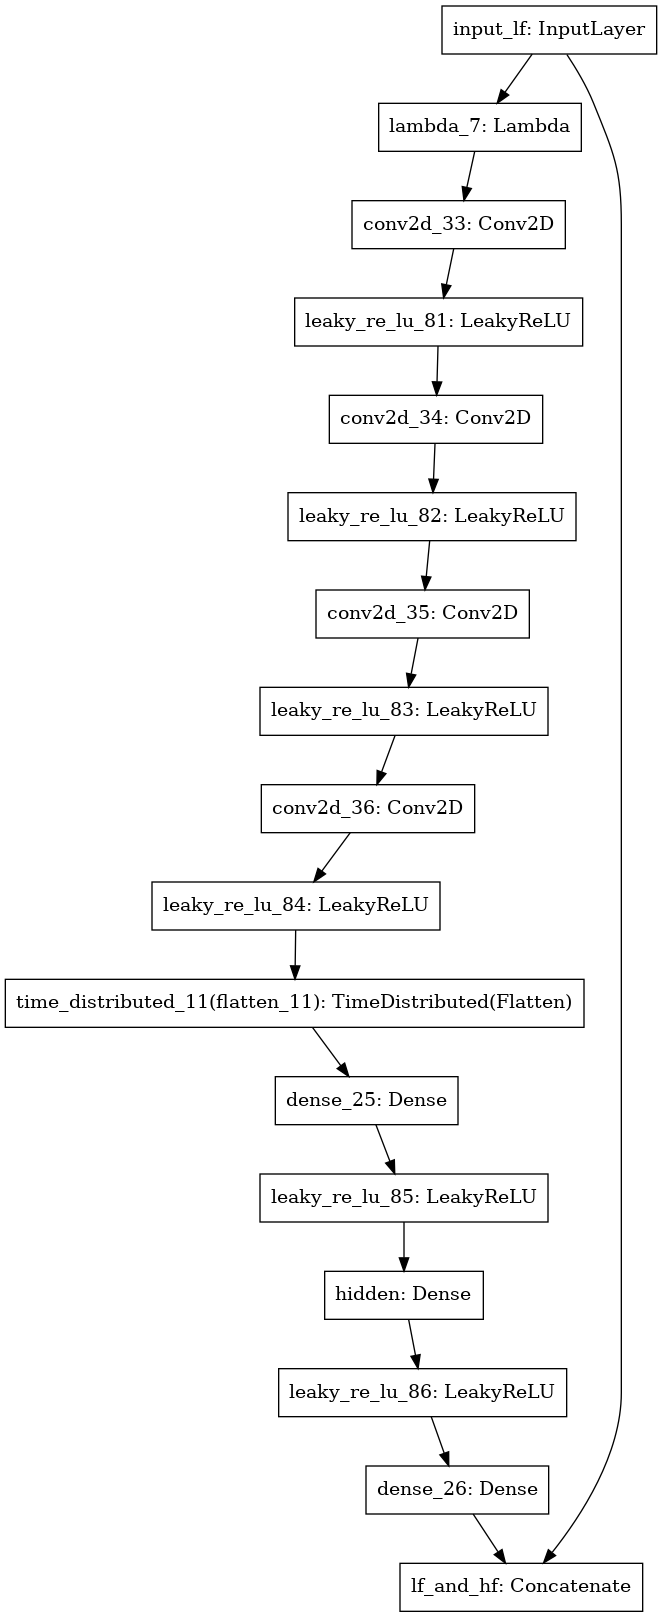

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, None, 129, 16 160         lambda_8[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_87 (LeakyReLU)      (None, None, 129, 16 0           conv2d_37[0][0]                  
__________________________________________________________________

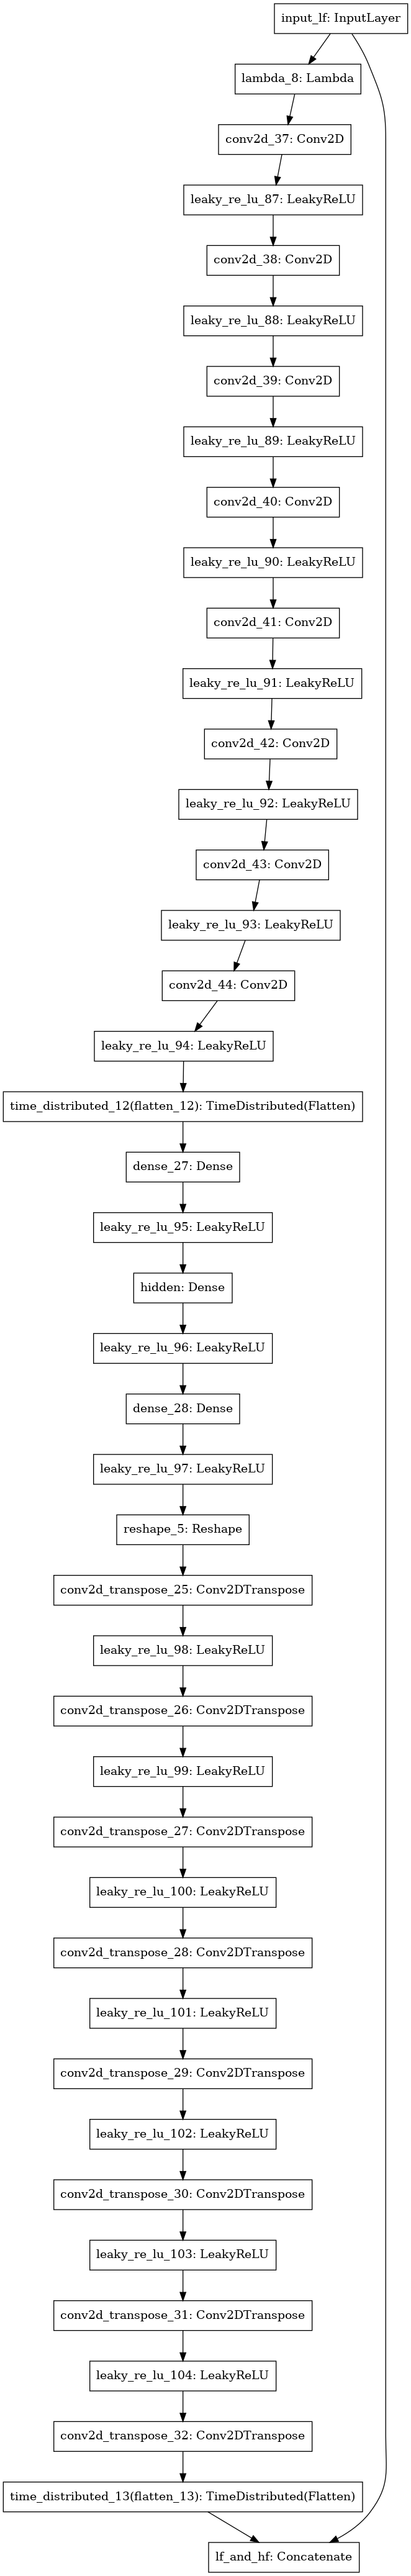

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, None, 129, 16 160         lambda_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_105 (LeakyReLU)     (None, None, 129, 16 0           conv2d_45[0][0]                  
__________________________________________________________________

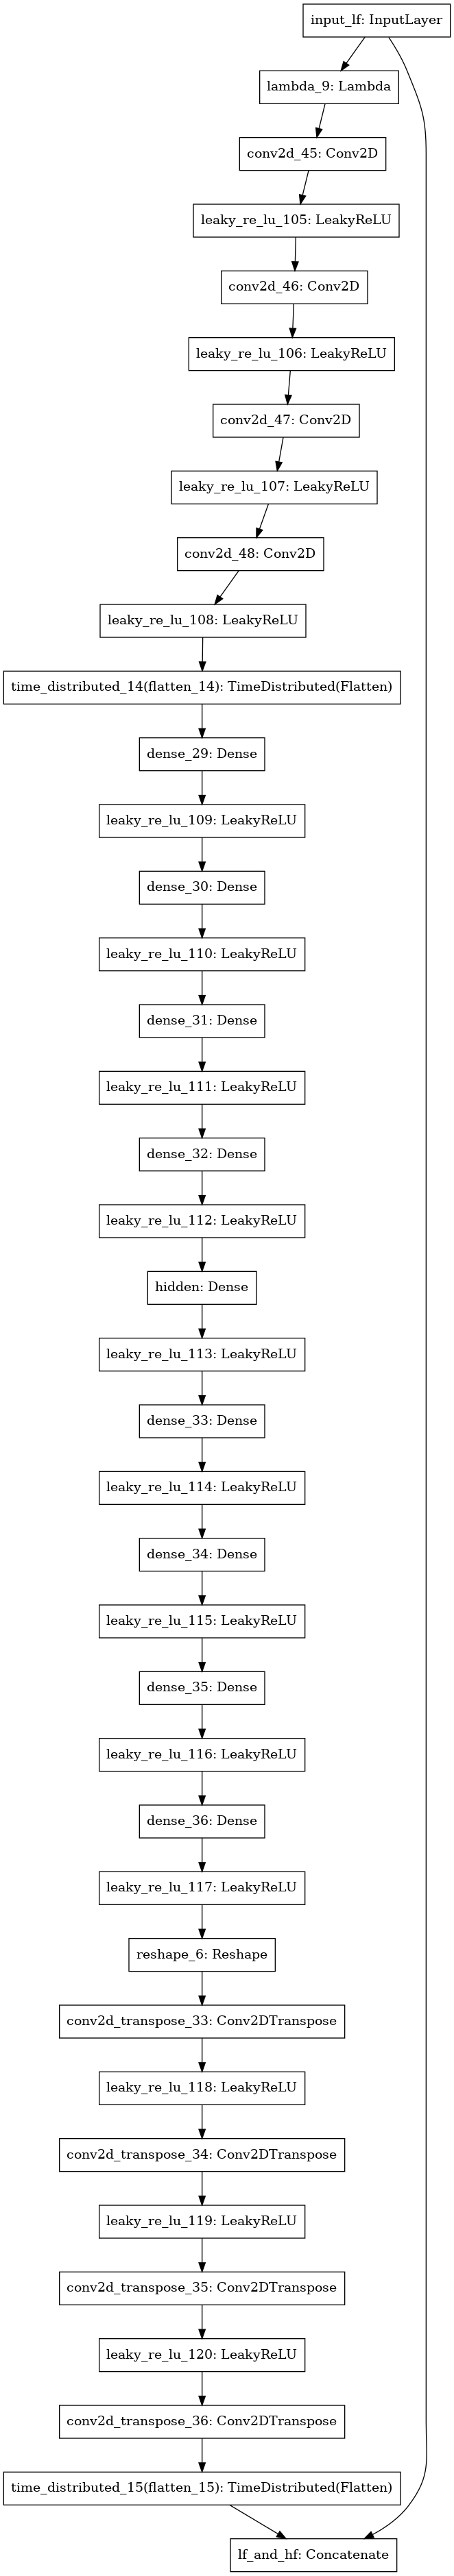

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, None, 129, 16 160         lambda_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_64 (LeakyReLU)      (None, None, 129, 16 0           conv2d_25[0][0]                  
__________________________________________________________________

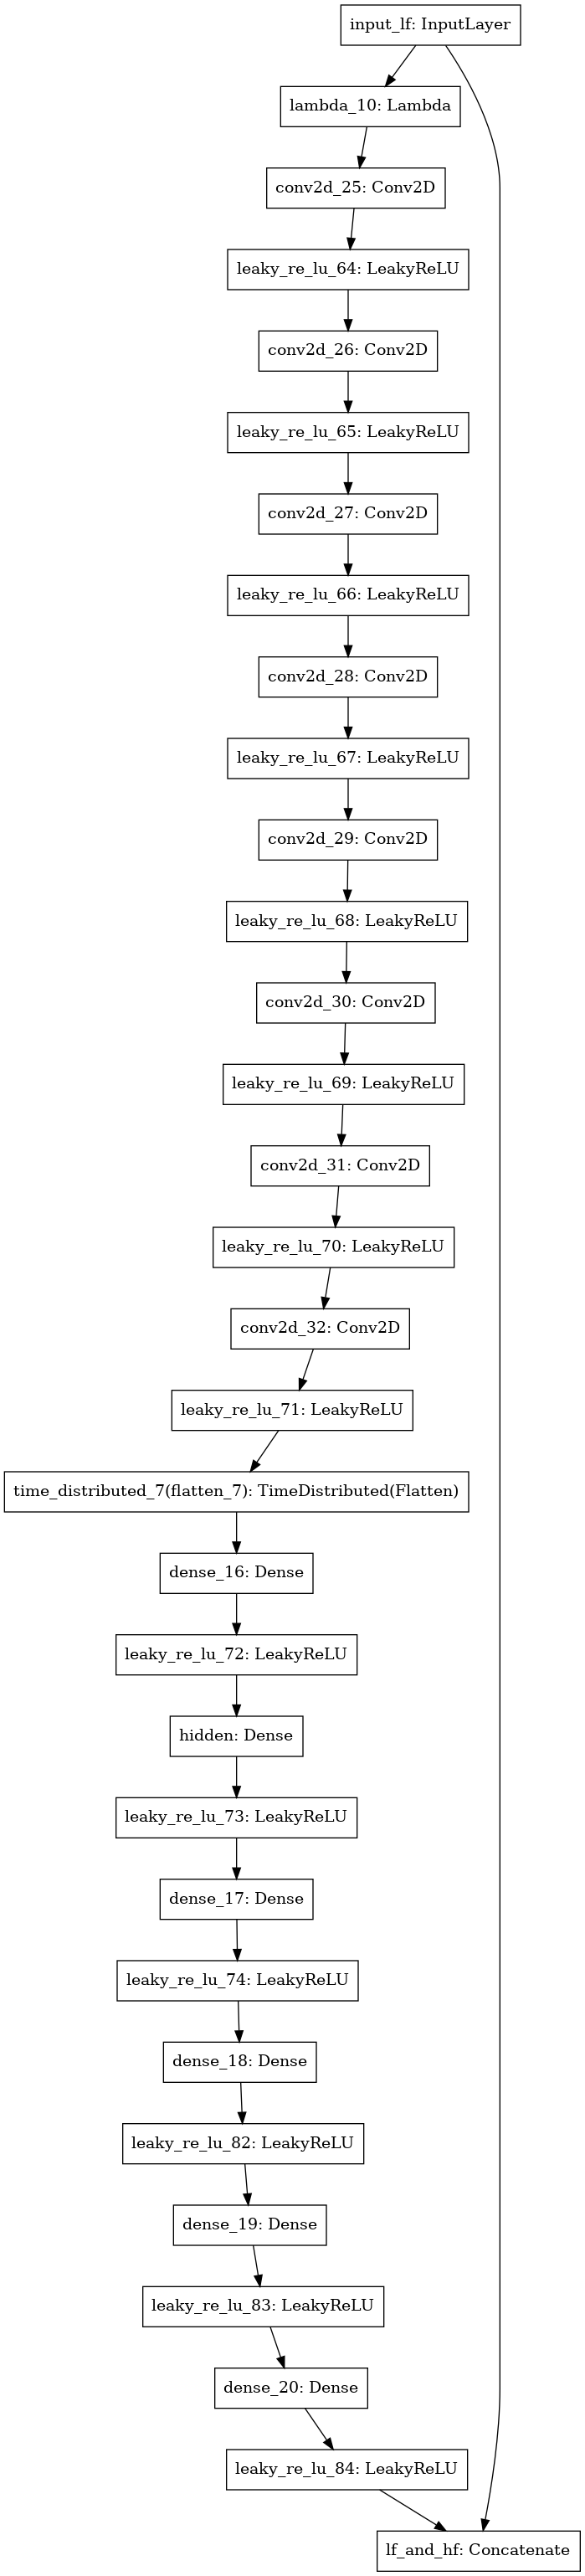

In [4]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

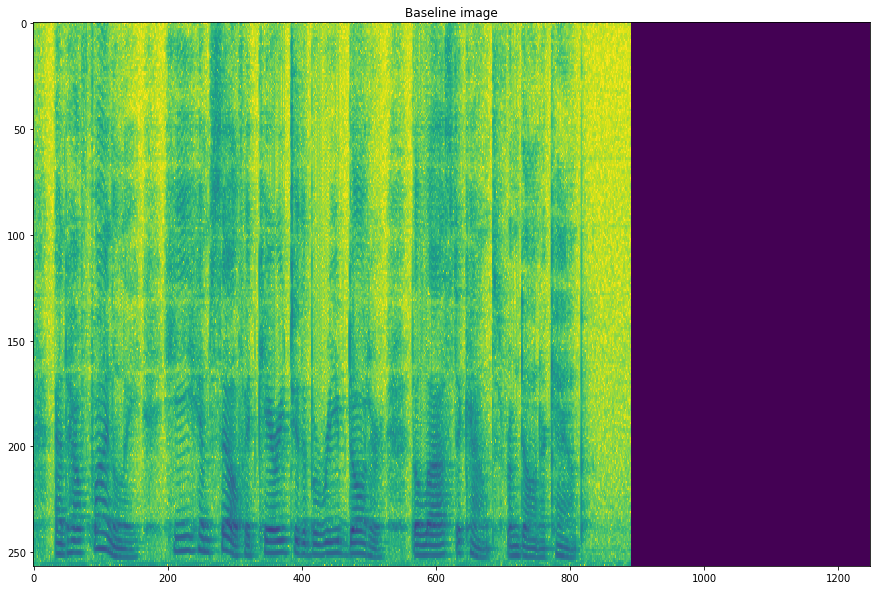

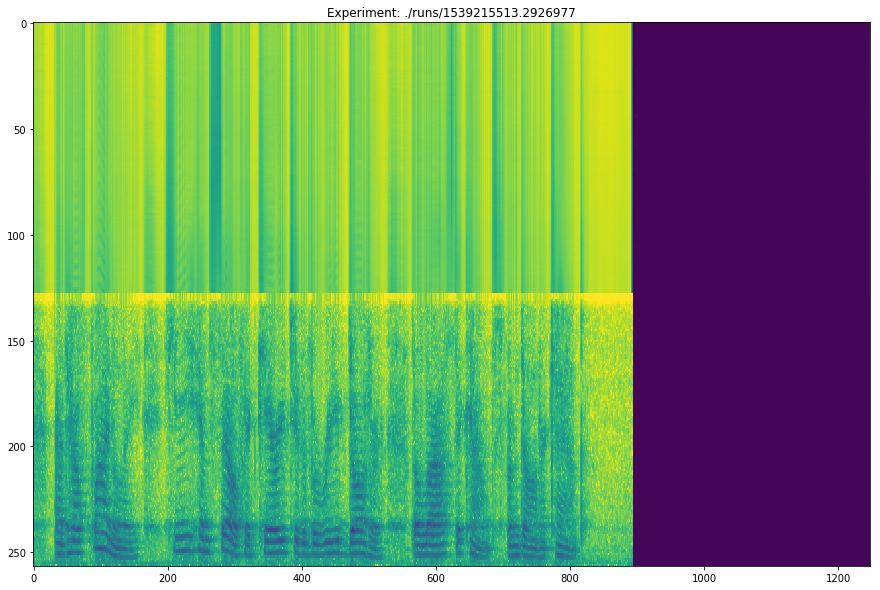

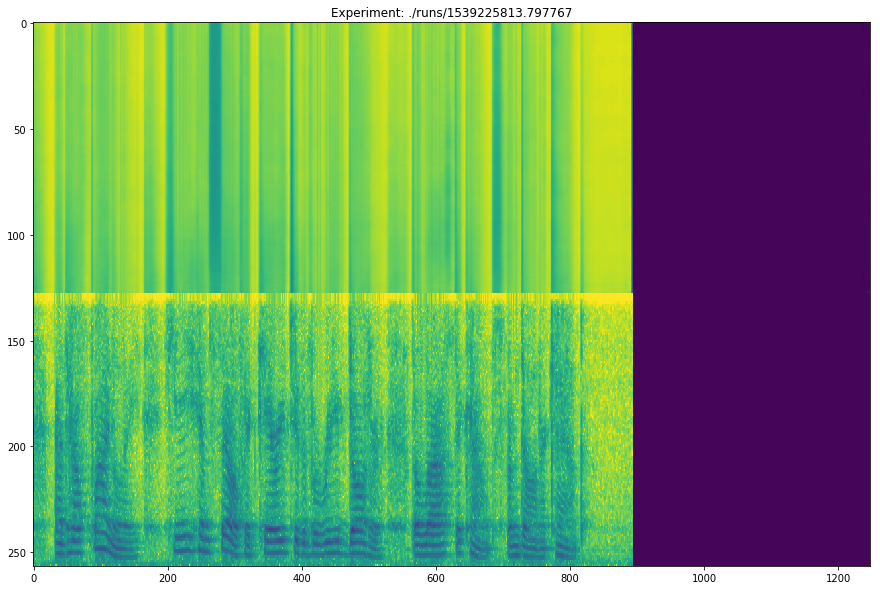

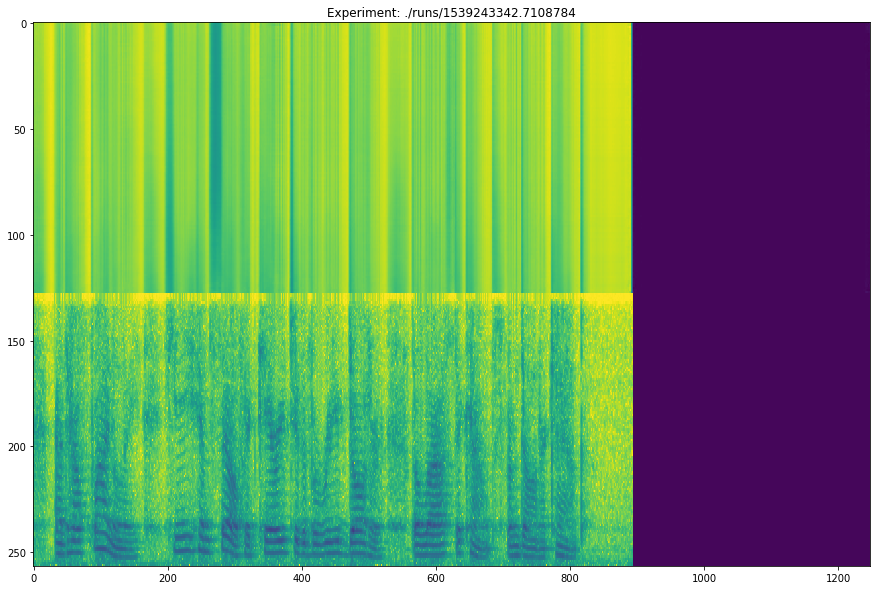

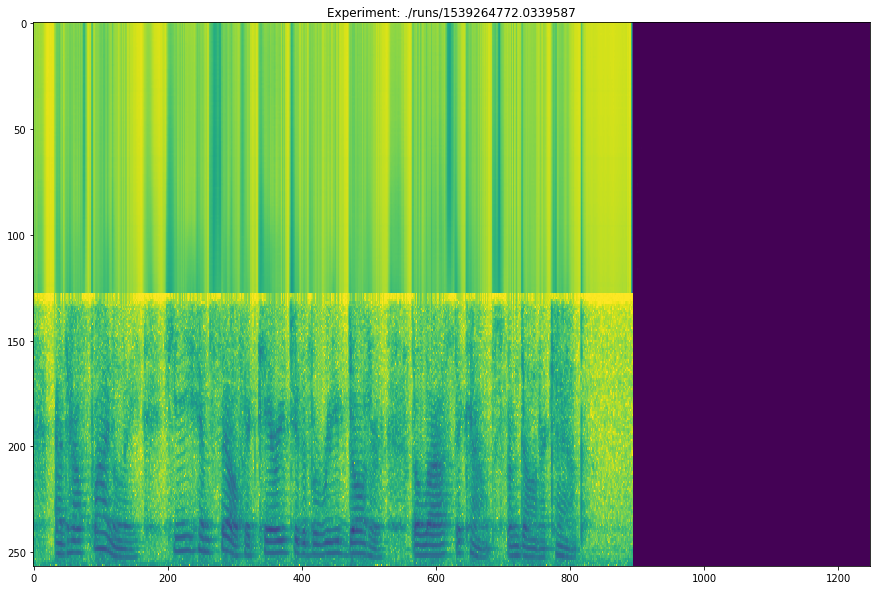

In [7]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]), aspect='auto')
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.show()

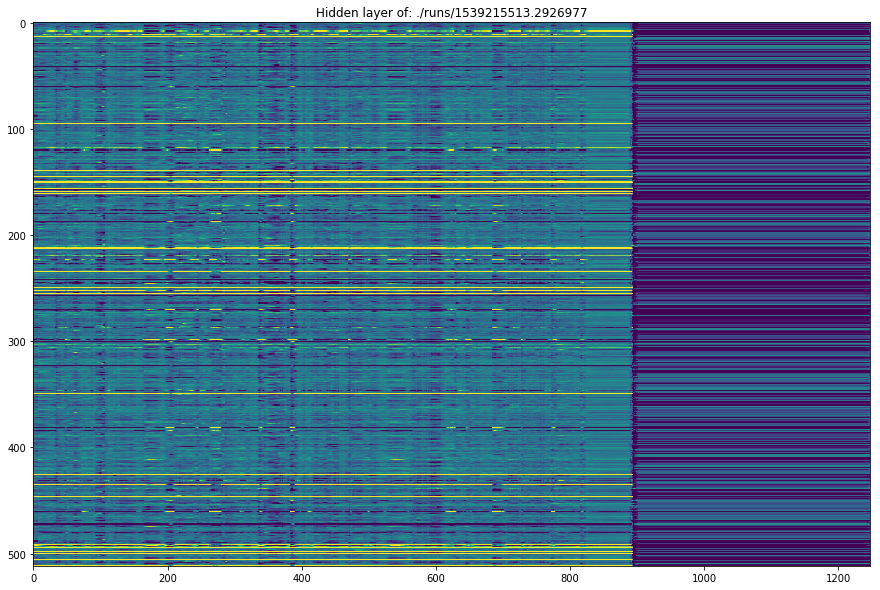

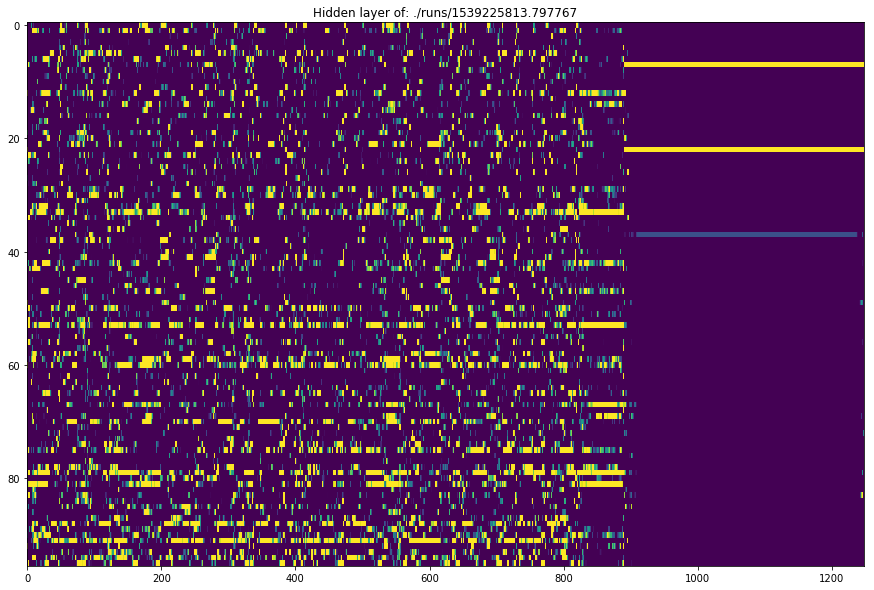

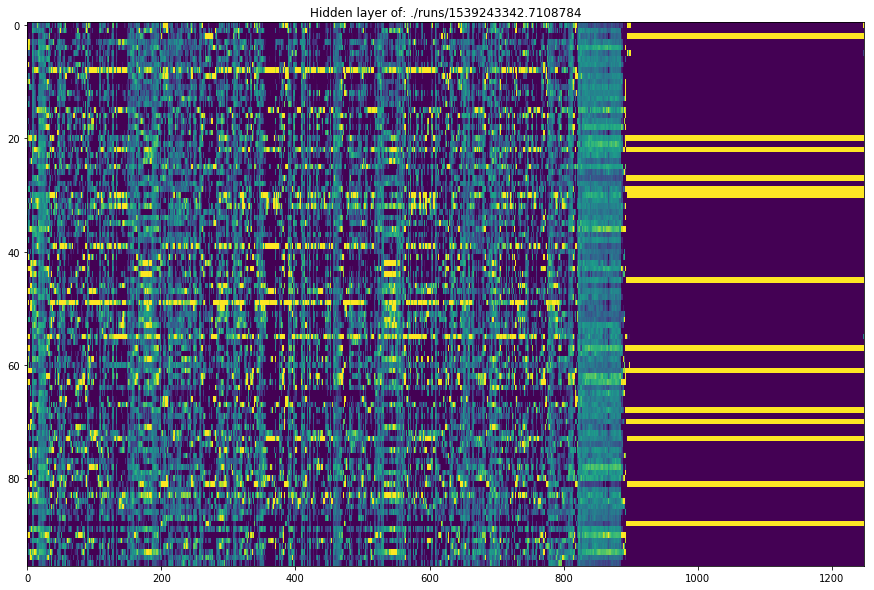

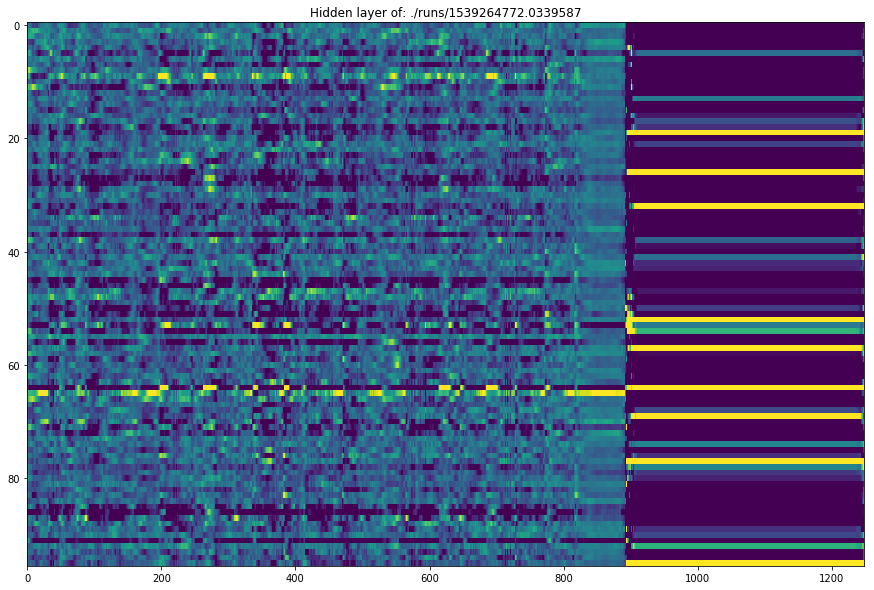

In [9]:
# hidden representation of each model - verify variability

image, gt = test

for name, mdl in zip(experiment_names, models):
    model = Model(mdl.input, [x.output for x in mdl.layers if x.name == "hidden"][0])
    prediction = model.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Hidden layer of: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto', vmin=-1, vmax=1)
    plt.show()

Groundtruth signal


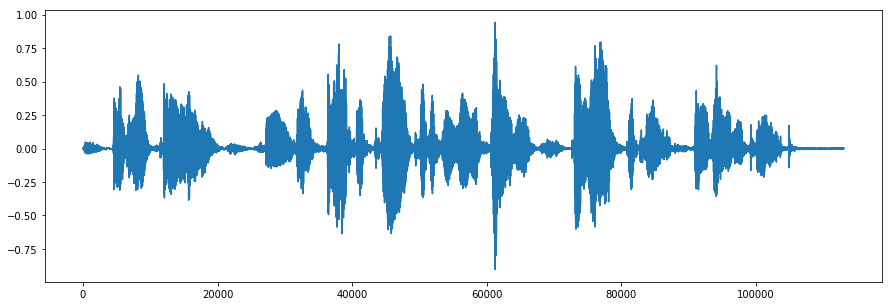

Input signal


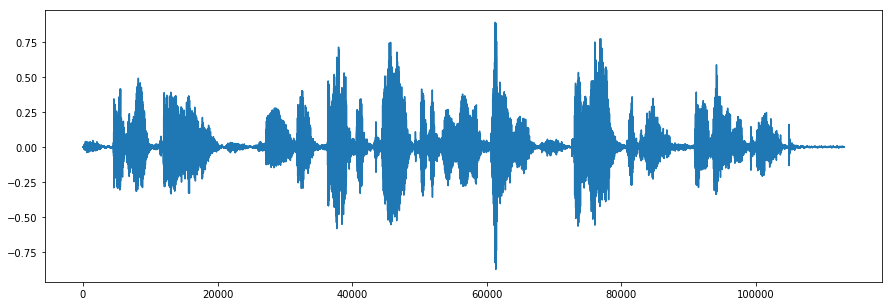

Prediction of ./runs/1539215513.2926977


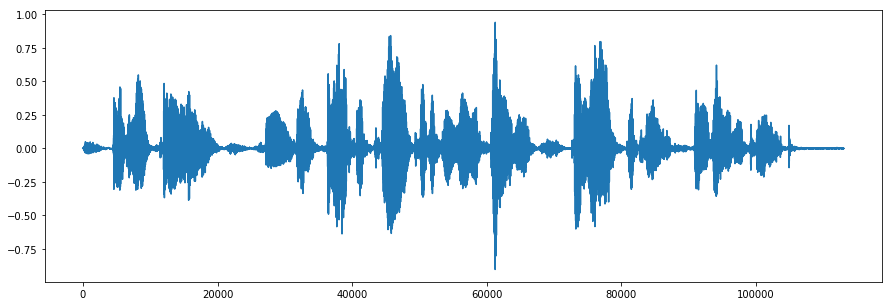

Prediction of ./runs/1539225813.797767


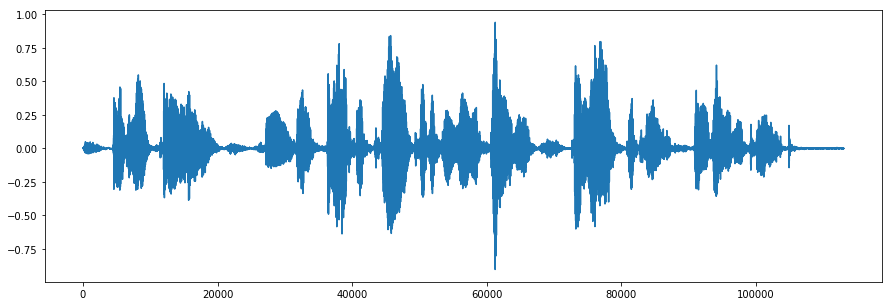

Prediction of ./runs/1539243342.7108784


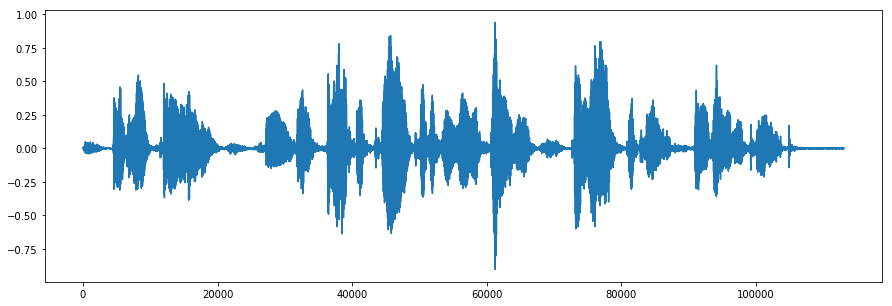

Prediction of ./runs/1539264772.0339587


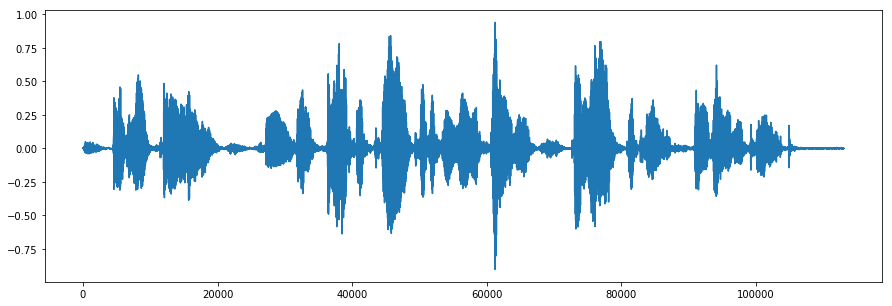

In [10]:
# predicted spectrograms

phase = gt[:] * 0
phase[:, :, :129] = orig_phase[:, :, :]
window = np.hamming(512)

print("Groundtruth signal")
sound = gt[0] * STD + MEAN
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)
length = len(np.where((gt[0, :, :] != 0).sum(1))[0]) - 4
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))

print("Input signal")
sound = image[0] * STD + MEAN
spec = np.zeros(gt[0].shape, np.complex)
spec[:,:129] = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :129] * 1j)
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]
    spec[:, :129] = gt[0, :, :129]
    sound = np.zeros(length * 128 + 512 - 128)
    spec *= STD
    spec += MEAN
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    plt.figure(figsize=(15,5))
    plt.plot(sound[:-1024])
    plt.show()
    display(Audio(sound[:-1024], rate=16000))


##### Metrics

In [11]:
"""
Note:

This is after supplication of gtruth lower frequencies (without noise). The original results, with noise are as follows:

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.14075
Predicted by model ./runs/1539215513.2926977: 1.529675 +- 0.48023423386405933
Predicted by model ./runs/1539225813.797767: 1.5438874999999999 +- 0.5032210993626459
Predicted by model ./runs/1539243342.7108784: 1.5448 +- 0.4954615373568366
"""

import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds[:, :, :129] = gt[:, :, :129]
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.1304625
Predicted by model ./runs/1539215513.2926977: 3.208375 +- 0.7740428343283077
Predicted by model ./runs/1539225813.797767: 3.2732750000000004 +- 0.8043025390827758
Predicted by model ./runs/1539243342.7108784: 3.225675 +- 0.8030622605844455
Predicted by model ./runs/1539264772.0339587: 3.2135624999999997 +- 0.7590566817397434


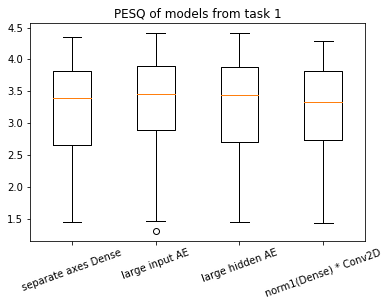

In [12]:
plot_model_names = ["separate axes Dense", "large input AE", "large hidden AE", "norm1(Dense) * Conv2D"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 1")
plt.show()

Text(0.5,1,'Percentage of preference across models, according to PESQ, task 1')

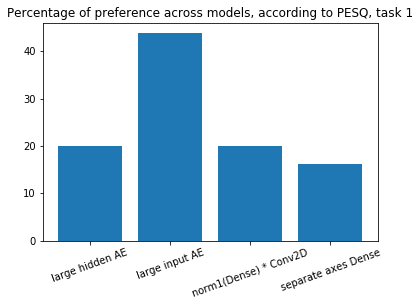

In [13]:
preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in sorted(c.keys())]
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 1")

In [14]:
# log power MSE

inp, gtruth = test
preds = mdl.predict(inp)

preds = gtruth * 0
preds[:, :, :129] = inp
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())

for name, mdl in zip(experiment_names, models):
    logmse=[]
    preds = mdl.predict(inp)
    preds[:, :, :129] = gt[:, :, :129]
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean())



Baseline log-power MSE: 7.71398
Log-power MSE of ./runs/1539215513.2926977: 0.096002266
Log-power MSE of ./runs/1539225813.797767: 0.096771315
Log-power MSE of ./runs/1539243342.7108784: 0.10031347
Log-power MSE of ./runs/1539264772.0339587: 0.09844932


In [17]:
# log-spectral distance


inp, gtruth = test
gtruth = STD * gtruth + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
lsd = []
innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = 2 / 513
        frame = inner[t]
        integral = frame.sum()
        sublsd.append(np.sqrt(step * integral))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = STD * mdl.predict(inp) + MEAN
    lsd = []
    innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = 2 / 513
            frame = inner[t]
            integral = frame.sum()
            sublsd.append(np.sqrt(step * integral))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean())

Log-spectral distance of baseline: 67.32151415760258
Log-spectral distance of ./runs/1539215513.2926977: 12.875008631507047
Log-spectral distance of ./runs/1539225813.797767: 12.89711320387047
Log-spectral distance of ./runs/1539243342.7108784: 12.933278895355798


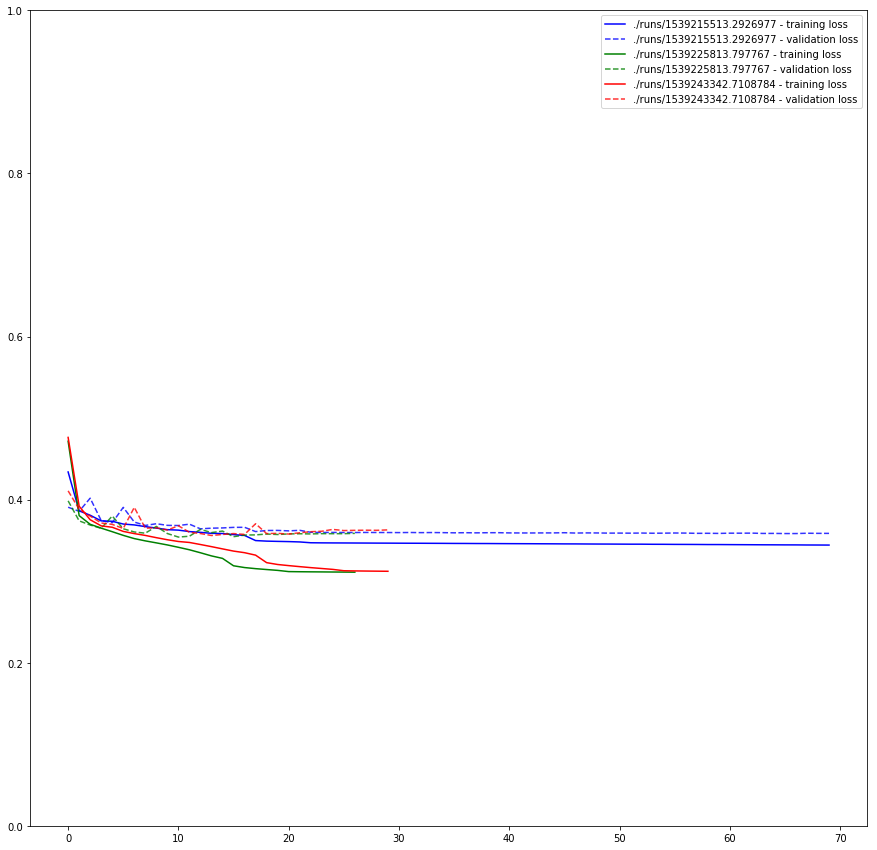

In [18]:
legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + ["dotted"] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    if type(loss[0]) == list:
        print("Model {} has multiple losses - not plotted".format(model))
    else:
        legend_labels.append(model + " - training loss")
        plt.plot(loss, linestyle=tl, color=color)    
        val_loss = hist['val_loss']
        plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
        legend_labels.append(model + " - validation loss")
plt.legend(legend_labels)
plt.ylim(0,1)
plt.show()

In [ ]:
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

import os
import numpy as np

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/zantyr/pickey.json"

def WER_for_file(recording):
    client = speech.SpeechClient()
    recording = recording * 2**15
    recording = recording.astype(np.int16)
    recording = recording.tobytes()
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code='en-US'
    )
    response = client.recognize(config, types.RecognitionAudio(content=recording))
    return response.results[0].alternatives[0].transcript

import editdistance

def WER_for_spec(spec, phase, transcript):
    spec = np.sqrt(np.exp(-spec)) * (np.exp(phase[0, :, :129] * 1j))
    sound = np.zeros(length * 128 + 512 - 128)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    transcript = WER_for_file(sound[:-1024])
    ED = editdistance.eval(transcript.upper().split(' '), true.upper().split(' '))
    return ED / len(transcript.split(' '))

for ix, fname in zip(range(TEST), test_filenames):
    test_case = test[:ix]
    phase_case = phase[:ix]
    true = open(fname).read()
    print(WER_for_spec(test_case, phase_case, fname))

In [ ]:
# Czy model z norm(Dense) * Conv rzeczywiscie modeluje kształt, czy wyjście Dense nie jest całe równe 1
# Czemu jest taka duza rozbieznosc miedzy treningiem a 